# Main Notebook

# Setup

In [33]:
# Uses hicdash v0.0.3.1 (packaged)
from hicdash.utilities import *
from hicdash.definitions import *
from hicdash.constants import *
from hicdash.plotters import *

In [34]:
from collections import Counter, defaultdict

import pyBigWig

import os

import matplotlib
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Arc

import scipy
from scipy import stats

from dataclasses import field, replace

In [35]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = "sans-serif"

## Utilities


### Reading Compartments

In [36]:
def read_compartments(compartment_file: str, resolution=100000) -> NDArray:
    df = pd.read_csv(compartment_file, sep='\s+', header=None)
    compartments = np.array(df.iloc[:, 3]) # compartment score
    return compartments

### Reading Insulations

In [37]:
def read_insulations(insulation_file) -> NDArray:
    return pd.read_csv(insulation_file).log2_insulation_score_100000.values

### Reading TADs

In [38]:
def read_tads(tad_file: str, res=25000, hierarchy_filter=0) -> list[GenomicRegion] | None: 
    # Default hierarchy filter to include only TADs
    if not os.path.isfile(tad_file):
        return None
    try:
        df = pd.read_csv(tad_file, sep='\s+', names=["chrom", "start", "end", "hierarchy"])
    except pd.errors.EmptyDataError:
        return []
    tads = []
    if hierarchy_filter is not None:
        df = df[df.hierarchy == hierarchy_filter]
    for _, (chr, start, end, hierarchy) in df.iterrows():
        tads.append(GenomicRegion(chr, start, end))
    return tads

### Reading Loops

In [39]:
def read_loops(loops_file, filter_chrom=None, filter_region=None) -> list[PairedRegion]:
    """Returns a sorted list of PairedRegion objects from a bedpe file.
    Expects file to have at least six columns: chr1, start1, end1, chr2, start2, end2.
    NOTE: loop file chromosomes are unprefixed in the default output
    """
    df = pd.read_csv(loops_file, sep="\t", names=BEDPE_COLUMNS + ["pvalue"], usecols=[0, 1, 2, 3, 4, 5, 6],
                    dtype={"chr1": str, "start1": np.int64, "end1": np.int64, "chr2": str, "start2": np.int64, "end2": np.int64, "pvalue": np.float64})
    if filter_chrom is not None or filter_region is not None:
        filter_chrom = filter_region.chrom if filter_region is not None else filter_chrom
        filter_chrom = chr_unprefix(filter_chrom)
        df = df[((df.chr1 == filter_chrom) & (df.chr2 == filter_chrom))]
    if filter_region is not None:
        df = df[(df.start1 > filter_region.start) & (df.start1 < filter_region.end) & (df.start2 > filter_region.start) & (df.start2 < filter_region.end)]
    pairs = [PairedRegion.from_bedpe_row(row) for _, row in df.iterrows() if row.pvalue <= 0.05] # retain only significant loops as all loops present in default output
    pairs.sort()
    return pairs

### Reading Neoloops

In [40]:
def read_neoloops(neoloops_file, filterA=None, filterB=None) -> list[PairedRegion]:
    """Returns a sorted list of PairedRegion objects from a bedpe file.
    Expects file to have at least six columns: chr1, start1, end1, chr2, start2, end2.
    """
    df = pd.read_csv(neoloops_file, sep="\t", names=BEDPE_COLUMNS + ["assembly"], usecols=[0, 1, 2, 3, 4, 5, 6],
                    dtype={"chr1": str, "start1": np.int64, "end1": np.int64, "chr2": str, "start2": np.int64, "end2": np.int64, "pvalue": np.float64})
    if filterA is not None and filterB is not None:
        df = df[((df.chr1 == filterA) & (df.chr2 == filterB)) | ((df.chr2 == filterA) & (df.chr1 == filterB))]
    pairs = [PairedRegion.from_bedpe_row(row) for _, row in df.iterrows()]
    pairs.sort()
    return pairs

### Reading CNV

In [41]:
def read_cnv_profile(cnv_profile_path):
    columns = ["chr", "start", "end", "value"]
    df_profile = pd.read_csv(cnv_profile_path, sep="\s+", names=columns)
    return df_profile

def read_cnv_segment(cnv_segment_path):
    columns = ["chr", "start", "end", "value"]
    df_segment = pd.read_csv(cnv_segment_path, sep="\s+", names=columns)
    return df_segment

### Reading Breakpoints

In [42]:
# Inter-chromosomal or anchors >5Mb only
def read_curated_calls(filepath):
    return [b for b in Breakpoint.list_from_breakfinder_file(filepath)
            if (b.breakendA.chrom != b.breakendB.chrom or 
            abs(b.breakendA.pos - b.breakendB.pos) > 5000000)]

### Plotting Compartments

In [43]:
def get_compartment_data(compartments, chr, start, end, res=100000):
    if chr == "chrX" or chr == "chrY": # exclude chrX / chrY
        return np.array([0]), 0, 0
    if res == 25000:
        compartment_regions = COMPARTMENT_REGIONS_25kb # cached compartment regions at 25kb
    else:
        compartment_regions = COMPARTMENT_REGIONS_100kb # cached compartment regions at 100kb
    pad_start = 0 
    pad_end = 0 
    comp_start = int(max(0, start // res* res))
    comp_end = int(min((end // res* res)+res, CHROM_SIZES[chr] // res * res))
    if start < 0:
        pad_start += -start // res
    # print("DEBUG: ", end, CHROM_SIZES[chr] // res * res)
    if end > CHROM_SIZES[chr] // res * res:
        pad_end += (end - CHROM_SIZES[chr]) // res
    # print(chr, comp_start, comp_end)
    comp_start_index = compartment_regions[(compartment_regions["chr"] == chr) & (compartment_regions["start"] == comp_start)]
    comp_end_index = compartment_regions[(compartment_regions["chr"] == chr) & (compartment_regions["start"] == comp_end)]
    # print("Comp start and end", comp_start_index, comp_end_index)

    compartment_array = compartments[comp_start_index.index[0]:comp_end_index.index[0]]
    # print("Comp array", compartment_array.min(), compartment_array.max())
    
    # Pad with zeros if needed
    if pad_start > 0:
        compartment_array = np.concatenate([np.zeros(int(pad_start)), compartment_array])
        comp_start = (start // res) * res
    if pad_end > 0:
        compartment_array = np.concatenate([compartment_array, np.zeros(int(pad_end))])
        comp_end = (end // res) * res + res
        
    return compartment_array, comp_start, comp_end

def plot_compartments(sample, region: GenomicRegion, ax, res=100000, vmax=0.5):
    chr, start, end = region.chrom, region.start, region.end
    if res == 25000:
        comp_file = sample.extra_comp_25kb
    else:
        comp_file = sample.profile.compartments # 100kb compartments by default
    comp_list = read_compartments(comp_file, resolution=res)
    comp_x, comp_start, comp_end = get_compartment_data(comp_list, chr, start, end, res=res)
    vmin = -vmax
    ax.imshow(np.expand_dims(comp_x, axis=0), aspect="auto", cmap="seismic", extent=(comp_start, comp_end, 0, 1), vmin=vmin, vmax=vmax)
    ax.set_xlim((start, end))
    if region.reverse:
        ax.invert_xaxis()
    blank_axis(ax)

## Constants

In [44]:
# Data profile: paths to all data files
@dataclass
class DataProfile:
    hic: str | None
    qc: str | None
    breakfinder: str | None
    mcool: str | None
    cnv_profile: str | None
    cnv_segment: str | None
    cnv_profile_250kb: str | None
    cnv_segment_250kb: str | None
    cnv_profile_500kb: str | None
    cnv_segment_500kb: str | None
    eaglec: str | None
    curated: str | None 
    curated_bedpe: str | None
    compartments: str | None 
    tads: str | None 
    loops_hicexplorer: str | None
    neoloops: str | None
    insulations: str | None

# Next, sort by unique_valid_pairs from qc
def get_uvp(sample_id):
    return pd.read_csv(f"../data/qc_deep/{sample_id}_v1.3_Arima_QC_deep.txt", sep='\s+')["Unique_valid_pairs"].values[0]

def exists_or_none(path: str):
    return path if os.path.exists(path) else None

def make_profile(sample_id: str, comp_res=100000):
    """Link a sample ID with all data files"""
    return DataProfile(
        hic=exists_or_none(f"../data/hic/{sample_id}_inter_30.hic"),
        qc=exists_or_none(f"../data/qc_deep/{sample_id}_v1.3_Arima_QC_deep.txt"),
        breakfinder=exists_or_none(f"../data/hic_breakfinder/{sample_id}.breaks.bedpe"),
        mcool=exists_or_none(f"../data/mcool/{sample_id}.mcool"),
        cnv_profile=exists_or_none(f"../data/cnv_profile/25000/{sample_id}_CNV_profile_25000.bedgraph"),
        cnv_segment=exists_or_none(f"../data/cnv_segment/25000/{sample_id}_CNV_segment_25000.bedgraph"),
        cnv_profile_250kb=exists_or_none(f"../data/cnv_profile/250000/{sample_id}_CNV_profile_250000.bedgraph"),
        cnv_segment_250kb=exists_or_none(f"../data/cnv_segment/250000/{sample_id}_CNV_segment_250000.bedgraph"),
        cnv_profile_500kb=exists_or_none(f"../data/cnv_profile/500000/{sample_id}_CNV_profile_500000.bedgraph"),
        cnv_segment_500kb=exists_or_none(f"../data/cnv_segment/500000/{sample_id}_CNV_segment_500000.bedgraph"),
        eaglec=exists_or_none(f"../data/eaglec/{sample_id}.CNN_SVs.5K_combined.txt"),
        curated=exists_or_none(f"../data/curated_breakpoints/{sample_id}_curated_breakpoints.tsv"),
        curated_bedpe=exists_or_none(f"../data/curated_breakpoints_converted/{sample_id}_curated_breakpoints.bedpe"),
        compartments=exists_or_none(f"../data/compartments/{comp_res}/{sample_id}.{comp_res}.bedgraph"),
        tads=exists_or_none(f"../data/tads/25000/{sample_id}.bed"),
        loops_hicexplorer=exists_or_none(f"../data/hicexplorer_loops/10000/{sample_id}_hicexplorer_loops_10000.bedpe") or exists_or_none(f"../data/loops/{sample_id}/merged_loops.bedpe"),
        neoloops=exists_or_none(f"../data/neoloops/90/{sample_id}.neoloops.bedpe"),
        insulations=exists_or_none(f"../data/insulations/res_10000_window_100000/{sample_id}_insulation_r10000_w100000.csv"),
    )

# Max value for H3K27ac bigwig tracks
GLOBAL_BW_MAX = 32

# Max value for observed/expected matrices
GLOBAL_OE_MAX = 2000

# Normalization for all Hi-C visualization (if unavailable/unconverged, default to VC_SQRT normalization)
HIC_NORM        = "SCALE"
HIC_NORM_BACKUP = "VC_SQRT"
MCOOL_BALANCE   = "weight"

# Plotting colours
BIGWIG_COLOUR = "royalblue"
CTCF_COLOUR = "seagreen"
LOOP_COLOUR = "royalblue"
CROSS_COLOUR = "royalblue"

# Colors for sample groups
GROUP_ORDER_COLORS = [
   ('PCN', "rebeccapurple"),
   ('CNS DLBCL', "royalblue"),
   ( "DLBCL (Richter transformation)", "dodgerblue"),
   ( 'DLBCL', "deepskyblue"),
   ( 'PMLBCL', "darkturquoise"),
   ( 'B-cell lymphoma NOS', "paleturquoise"),
   ( 'Burkitt lymphoma', "lightgreen"),
   ( 'Classic Hodgkins lymphoma', "cadetblue"),
   ( 'MCL', "yellowgreen"),
   ( 'B-ALL', "gold"),
   ( 'ALCL', "salmon"),
   ( 'T-ALL', "tomato"),
    ("ANBL6", "grey"),
    ("RCK8", "grey"),
    ("SU_DHL6", "grey"),
    ("UOCB6", "grey"),
    ("WSU_DLCL2", "grey"),
   ( 'PC', "mediumpurple"),
   ( 'MBC', "mediumslateblue"),
   ( 'GCBC', "steelblue"),
   ( 'NBC', "lightsteelblue"),
   ( 'HMEC', "gray"),
   ( 'HUVEC', "gray"),
   ( 'IMR90', "gray"),
   ( 'NHEK', "gray"),
   ( 'K562', "pink"),
   ( 'KBM7', "pink"),
   ( 'GM12878', "cornflowerblue"),

]

# Order of library prep values for plots
PREP_ORDER = [
    "Arima_FFPE",
    "In-situ_Fresh-Frozen",
    "In-situ_Culture",
]

# Convert plotting constants to dicts for easy access
GROUP_COLORS = { k: v for k, v in GROUP_ORDER_COLORS }
GROUP_ORDER = [ g[0] for g in GROUP_ORDER_COLORS ]
PREP_ORDER_DICT = { s: i for i, s in enumerate(PREP_ORDER) }
GROUP_ORDER_DICT = {s: i for i, s in enumerate(GROUP_ORDER) }

# Compartments (with blacklist annotation) and indices of compartments excluding blacklist
COMPARTMENT_REGIONS_100kb = pd.read_csv("../annotations/compartment_regions_100kb_blacklisted.csv", sep=",", header=0)
COMPARTMENT_SUBSET_INDICES = np.array((COMPARTMENT_REGIONS_100kb["blacklisted"] == False).to_list())

# Insulations and indices of insulations excluding blacklist
INSULATION_REGIONS = pd.read_csv("../annotations/insulation_regions_10000.csv") # cached insulation regions at 10kb
INSULATION_SUBSET_INDICES = np.array((INSULATION_REGIONS["is_bad_bin"] == False).to_list())

# Utility type for sample
@dataclass 
class Sample:
    meta: object
    profile: DataProfile
    uvp: float

    def to_arima(self, no_breakpoints=False):
        assert self.profile.hic is not None
        assert self.profile.qc is not None
        arima_sample = ArimaPipelineSample(
            self.meta.id_paper,
            self.profile.hic,
            self.profile.qc,
            self.profile.curated_bedpe
        )
        return arima_sample
            

# Utility function for saving plots
def figure_path(plot_name):
    return f"../figures/{plot_name}"

In [45]:
# Filepaths to bigwig files
BW_NAIVE = ("NBC", "../annotations/H3K27ac/01_naive_B_cell.H3K27ac.bw")
BW_PLASMA = ("PC", "../annotations/H3K27ac/02_plasma_cell.H3K27ac.bw")
BW_GERMINAL = ("GCBC", "../annotations/H3K27ac/03_germinal_center_B_cell.H3K27ac.bw")
BW_SUDHL5_LARGECELL = ("SUDHL5", "../annotations/H3K27ac/04_SUDHL5_H3K27ac.bw")
BW_KARPAS_DLBCL = ("Karpas422", "../annotations/H3K27ac/05_Karpas422_H3K27ac.bw")
BW_HT_BCL = ("HT", "../annotations/H3K27ac/06_HT_H3K27ac.bw")
BW_MYELOMA_ANBL6 = ("ANBL6", "../annotations/H3K27ac/07_ANBL6_H3K27ac.bw")
BW_PTCL_T8ML = ("T8ML1", "../annotations/H3K27ac/collaborators_Wilcox_lab_T8ML1_H3K27Ac_rep1.1m.bw")
BW_TALL = ("T-ALL°", "../annotations/H3K27ac/10_data-public_databases_blueprint_hg38bw_Tcell_Acute_Lymphocytic_Leukemia_S01S3FH1.ERX1347915.H3K27ac.bwa.GRCh38.bw")

BW_DL08 = ("DL08", "../annotations/H3K27ac/HPR131_AGRR009_DLBCL.H3K27ac.1m.bw")
BW_DL10 = ("DL10", "../annotations/H3K27ac/HPR174_AGRR020_DLBCL.H3K27ac.1m.bw")

# Dict of groups to default bigwig files (unless otherwise specified)
BW_DICT = {
    "DLBCL": BW_GERMINAL,
    "CNS DLBCL": BW_GERMINAL,
    "DLBCL (Richter transformation)": BW_GERMINAL,
    "Burkitt lymphoma": BW_GERMINAL,
    "PCN": BW_PLASMA,
    "B-cell lymphoma NOS": BW_GERMINAL,
    "PMLBCL": BW_GERMINAL,
    "Follicular lymphoma": BW_GERMINAL,
    "MCL": BW_GERMINAL,
    "Classic Hodgkins lymphoma": BW_GERMINAL,
    "T-ALL": BW_TALL,
    "B-ALL": BW_NAIVE,
    "ALCL": BW_GERMINAL, 
}

# Sample specific Bigwigs
BW_DICT_SAMPLES = {
    "DL08": BW_DL08,
    "DL10": BW_DL10,
}

# CTCF data
CTCF_BEDFILE = "../annotations/CTCF/CTCF_motifs_STORM_hg38.bed"
CTCF_DF = pd.read_csv(CTCF_BEDFILE, names=["chr", "start", "end", "direction"], sep=r"\s+")

### Read Samples

In [46]:
samplesheet = pd.read_csv("../metadata/lymphoma_meta.csv")

# Ensure groups are as expected and preps are as expected
assert set(GROUP_ORDER) == set(samplesheet.group.to_list())
assert set(PREP_ORDER) == set(samplesheet.prep.to_list())

# Collectors for different samples
samples           = []
samples_pub_rao   = []
samples_pub_merge = []
samples_pub_rep   = []
samples_lines     = []

headers = " | ".join([f"{s[:5]:5}" for s in DataProfile.__annotations__.keys()])
# print(f"|          file_id | " + headers + " |")
for i, row in samplesheet.iterrows():
    hic_file_id = row.id_file
    profile = make_profile(hic_file_id, comp_res=100000)
    if "merge" in hic_file_id:
        samples_pub_merge.append(Sample(row, profile, get_uvp(hic_file_id)))
    elif "GSE63525_" in hic_file_id:
        samples_pub_rao.append(Sample(row, profile, get_uvp(hic_file_id)))
    elif hic_file_id in ["ANBL6", "RCK8", "UOCB6", "SU_DHL6", "WSU_DLCL2"]:
        samples_lines.append(Sample(row, profile, get_uvp(hic_file_id)))
    else:
        samples.append(Sample(row, profile, get_uvp(hic_file_id)))
    def x(path: str | None): return "X" if path is not None else " "
    checklist = " | ".join([f"{x(s):>5}" for s in profile.__dict__.values()])
    # print(f"| {row.id_file:>16} | "  + checklist + " |")

# Load reps separately from merged
for sample in samples_pub_merge:
    for rep in [1, 2, 3]:
        new_id_file = sample.meta.id_file.replace("_merge", f"_rep{rep}")
        new_id_paper = sample.meta.id_paper.replace("_merge", f"_rep{rep}")
        new_meta = sample.meta.copy()
        new_meta.id_file = new_id_file
        new_meta.id_paper = new_id_paper
        new_uvp = get_uvp(new_id_file)
        new_sample = Sample( new_meta, make_profile(new_id_file), new_uvp, )
        samples_pub_rep.append(new_sample)

def sort_samples(samples): return sorted(samples,  key=lambda x: (PREP_ORDER_DICT[x.meta.prep], GROUP_ORDER_DICT[x.meta.group], -x.uvp))
samples = sort_samples(samples)
samples_pub_rao = sort_samples(samples_pub_rao)
samples_pub_merge = sort_samples(samples_pub_merge)
samples_pub_rep = sort_samples(samples_pub_rep)

samples_all_merge = samples + samples_pub_merge + samples_pub_rao  
samples_all_reps = samples + samples_pub_rep + samples_pub_rao  

In [47]:
arima_samples = [sample.to_arima() for sample in samples]
arima_samples_rao = [sample.to_arima() for sample in samples_pub_rao]
arima_samples_merge = [sample.to_arima() for sample in samples_pub_merge]
arima_samples_lines = [sample.to_arima() for sample in samples_lines]

In [48]:
SAMPLE_DICT = { sample.meta.id_paper: sample for sample in samples }
for sample in samples_pub_merge:
    SAMPLE_DICT[sample.meta.id_paper] = sample

### IG/TR Locus Constants

Helper for plotting.

In [49]:
def get_min_max(letter, biotype_prefix="IG", strip_prefix="IGH", contig="14", start=105586437, end=106879844, alt_prefix=None):
    in_locus = GENE_ANNOTATIONS.genes_at_locus(contig, start, end)
    if alt_prefix is None:
        igh_genes = [ g for g in in_locus if g.biotype == f"{biotype_prefix}_{letter}_gene" and g.gene_name.startswith(strip_prefix)]
        rects = [(x.gene_name.replace(strip_prefix, ""), x.start, x.end) for x in igh_genes if x.gene_name.startswith(strip_prefix)]
    else:
        igh_genes = [ g for g in in_locus if g.biotype == f"{biotype_prefix}_{letter}_gene" and (g.gene_name.startswith(strip_prefix) or g.gene_name.startswith(alt_prefix))]
        rects = [(x.gene_name.replace(strip_prefix, ""), x.start, x.end) for x in igh_genes if (x.gene_name.startswith(strip_prefix) or x.gene_name.startswith(alt_prefix))]
    # print(f"{len(igh_genes)} {biotype_prefix} {letter} genes.")
    igh_min = min(map(lambda x: x.start, igh_genes))
    igh_max = max(map(lambda x: x.end, igh_genes))
    return (igh_min, igh_max, rects)

IGH_LOCUS = { letter: get_min_max(letter, strip_prefix="IGH") for letter in "VDJC" }
IGH_REGION = GenomicRegion("chr14", 105586437, 106879844)

IGL_LOCUS = { letter : get_min_max(letter, contig="22", start=22026076, end=22922913, strip_prefix="IGL") for letter in "VJC" }
IGL_REGION = GenomicRegion("chr22", start=22026076, end=22922913)

TRA_LOCUS = { letter : get_min_max(letter, biotype_prefix="TR", contig="14", start=21621904, end=22552132, strip_prefix="TRA", alt_prefix="TRD") for letter in "VDJC" }
TRA_REGION = GenomicRegion("chr14", start=21621904, end=22552132)

LOCUS_COLORS = {
    "V": "#7d2424",
    "D": "#346634",
    "J": "#2a2a73",
    "C": "black"
}

## Standard Plots

In [50]:
# Auto-plot with special loci when plotting gene tracks
def plot_gene_track_autospecial(region: GenomicRegion, ax: plt.Axes, label_side=False, vertical=False, **kwargs):
    fontsize=12 if "fontsize" not in kwargs.keys() else kwargs["fontsize"]
    autolabel = None
    autoregion = None
    autolocus = None
    if region.overlaps(IGH_REGION):
        autolabel = "IGH Locus"
        autolocus = IGH_LOCUS
        autoregion = IGH_REGION
    elif region.overlaps(IGL_REGION):
        autolabel = "IGL Locus"
        autolocus = IGL_LOCUS
        autoregion = IGL_REGION
    elif region.overlaps(TRA_REGION):
        autolabel = "TRA Locus"
        autolocus = TRA_LOCUS
        autoregion = TRA_REGION
    if autolabel is not None and autolocus is not None:
        ax_lim = 5
        blank_axis(ax)
        text_mid_start = autoregion.start if region.start < autoregion.start < region.end else region.start
        text_mid_end = autoregion.end if region.start < autoregion.end  < region.end else region.end
        text_mid = (text_mid_start + text_mid_end) / 2
        if vertical:
            ax.set_ylim(region.end, region.start)
            ax.text(4, text_mid, autolabel, rotation=90, fontsize=fontsize, ha="right", va="center")
            for letter, (rmin, rmax, rects) in autolocus.items():
                mid = (max(rmin, region.start) + min(rmax, region.end)) / 2
                color = LOCUS_COLORS[letter]
                ax.vlines(0.75, rmin, rmax, colors=color, ls=":", lw=0.5)
                if letter != "C" or region.get_size() > 300000:
                    ax.text(4, mid, letter, ha="left", va="center", rotation=90, fontsize=7, color=color, clip_on=True)
                for (gene_name, rectmin, rectmax) in rects:
                    ax.add_patch(Rectangle((0, rectmin), 1.5, rectmax-rectmin, fc=color, ec=color))
                    if letter == "C" and region.get_size() <= 300000:
                        ax.text(4, (rectmin+rectmax)/2, gene_name, ha="left", va="center", rotation=90, fontsize=7, color=color, clip_on=True)
            ax.set_xlim(ax_lim, 0)
            ax.set_ylim(region.end, region.start)
            if region.reverse:
                ax.invert_yaxis()
        else:
            ax.set_xlim(region.start, region.end)
            if label_side:
                ax_lim=4
                if region.start < autoregion.start < region.end:
                    ha = "right" if not region.reverse else "left"
                    dx = - region.get_size() / 25
                    ax.text(autoregion.start + dx, 0,  autolabel, rotation=0, fontsize=fontsize, ha=ha, va="bottom")
                elif region.start < autoregion.end < region.end:
                    ha = "left" if not region.reverse else "right"
                    dx = region.get_size() / 25
                    ax.text(autoregion.end + dx, 0,  autolabel, rotation=0, fontsize=fontsize, ha=ha, va="bottom")
                else:
                    ax_lim=6
                    ax.text(region.end, 6,  autolabel, rotation=0, fontsize=fontsize, ha="right", va="top")
            else:
                ax.text(text_mid, 4,  autolabel, rotation=0, fontsize=fontsize, ha="center", va="bottom")
            for letter, (rmin, rmax, rects) in autolocus.items():
                mid = (max(rmin, region.start) + min(rmax, region.end)) / 2
                color = LOCUS_COLORS[letter]
                ax.hlines(0.75, rmin, rmax, colors=color, ls=":", lw=0.5)
                if letter != "C" or region.get_size() > 300000:
                    ax.text(mid, 4, letter, va="top", ha="center", rotation=0, fontsize=7, color=color, clip_on=True)
                for (gene_name, rectmin, rectmax) in rects:
                    ax.add_patch(Rectangle(( rectmin, 0), rectmax-rectmin, 1.5, fc=color, ec=color))
                    if letter == "C" and region.get_size() <= 300000:
                        ax.text((rectmin+rectmax)/2, 4, gene_name, va="top", ha="center", rotation=0, fontsize=7, color=color, clip_on=True)
            ax.set_ylim( 0, ax_lim)
            ax.set_xlim(region.start, region.end)
            if region.reverse:
                ax.invert_xaxis()
    else:
        plot_gene_track(region, ax=ax, vertical=vertical, **kwargs)

### Hi-C Matrix Plot

In [51]:
def plot_standard_matrix_plot(
    arima_sample: ArimaPipelineSample, 
    regionX: GenomicRegion,
    regionY: GenomicRegion,
    resolution: int, 
    measure="observed",
    normalization=HIC_NORM,
    norm_constant_normalize=False,
    vmax=None,
    bw_tuple: tuple[str, str]=None, # cell name, filename
    show_bw_top=True,
    show_bw_left=True,
    show_gene_top=True,
    show_gene_left=True,
    gene_track_top_ratio=None,
    gene_track_left_ratio=None,
    gene_filter: list[str]=None,
    figsize:tuple[int,int]=(2.8,2.8),
    show_breakpoints=True,
    all_same_line=True,
    mew=1,
    marker_size=5,
    crosshairs=True,
    show_neoloops=False,
    neoloop_lw=1,
    neoloop_ls="-",
    neoloop_radius=None,
    show_uvp=False,
    neoloop_region_filter=None,
    num_bins=None,
    bw_max=GLOBAL_BW_MAX,
):
    sample = SAMPLE_DICT[arima_sample.id]

    fig = plt.figure(figsize=figsize)
    
    gene_track_height_ratio = 0.125 if show_gene_top else 0
    if gene_track_top_ratio is not None and show_gene_top:
        gene_track_height_ratio=gene_track_top_ratio
        
    gene_track_width_ratio = 0.125 if show_gene_left else 0
    if gene_track_left_ratio is not None and show_gene_left:
        gene_track_width_ratio=gene_track_left_ratio
        
    bigwig_track_height_ratio = 0.18 if bw_tuple is not None and show_bw_top else 0
    bigwig_track_width_ratio = 0.18 if bw_tuple is not None and show_bw_left else 0
    width_ratios = [gene_track_width_ratio, bigwig_track_width_ratio, 1]
    height_ratios = [gene_track_height_ratio, bigwig_track_height_ratio, 1]
    spec = fig.add_gridspec(3, 3, width_ratios=width_ratios, height_ratios=height_ratios, wspace=0.05, hspace=0.02)

    ax_center = fig.add_subplot(spec[2, 2])
    ax_gene_left_y = fig.add_subplot(spec[2, 0])
    ax_gene_top_x = fig.add_subplot(spec[0, 2])
    ax_bigwig_left_y = fig.add_subplot(spec[2, 1])
    ax_bigwig_top_x = fig.add_subplot(spec[1, 2])

    plot_hic_region_matrix(
        arima_sample, regionX, regionY, resolution, 
        normalization=normalization, measure=measure, norm_constant_normalize=norm_constant_normalize, 
        ax=ax_center, vmax=vmax, show_breakpoints=show_breakpoints, breakpoint_highlight=1,
        marker_size=marker_size, mew=mew,
        crosshairs=crosshairs,
    )
    
    # Reduce fontsize of x and y tick labels
    ax_center.tick_params(axis="both", labelsize=9)
    
    # Remove center tick 
    ax_center.xaxis.get_major_ticks()[1].set_visible(False)
    ax_center.yaxis.get_major_ticks()[1].set_visible(False)

    if show_gene_top:
        if gene_track_top_ratio is not None:
            plot_gene_track_autospecial(regionX, gene_filter=gene_filter, centered_names=False, min_rows=0, protein_coding_only=False, ax=ax_gene_top_x,  fontsize=8, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line)
        else:
            plot_gene_track_autospecial(regionX, gene_filter=gene_filter, centered_names=False, max_rows=1, min_rows=0, protein_coding_only=False, ax=ax_gene_top_x,  fontsize=10, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line)
    else:
        ax_gene_top_x.axis('off')
    if show_gene_left:
        if gene_track_left_ratio is not None:
            plot_gene_track_autospecial(regionY, vertical=True, gene_filter=gene_filter, centered_names=False, protein_coding_only=False, ax=ax_gene_left_y, fontsize=8, min_rows=0, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line)
        else:
            plot_gene_track_autospecial(regionY, vertical=True, gene_filter=gene_filter, centered_names=False, protein_coding_only=False, ax=ax_gene_left_y, fontsize=10, max_rows=1, min_rows=0, arrowhead_width=0.25, arrowhead_length_proportion=0.025, all_same_line=all_same_line)
    else:
        ax_gene_left_y.axis('off')

    if bw_tuple is not None:
        bw_label, bw_filename = bw_tuple
        bw_handle = pyBigWig.open(bw_filename)
        if show_bw_top:
            if num_bins is None:
                num_bins = regionX.get_size() // 1000
            plot_bigwig_track(bw_handle, regionX, num_bins=num_bins, ax=ax_bigwig_top_x, color=BIGWIG_COLOUR, ymax=bw_max) 
            ax_bigwig_top_x.yaxis.set_visible(True)
            ax_bigwig_top_x.set_yticks([0, bw_max], [0, bw_max], fontsize=8, rotation=90)
            ax_bigwig_top_x.yaxis.tick_right()
            ax_bigwig_top_x.set_ylabel(f"H3K27ac\n({bw_label})", fontsize=8, rotation=90)
            ax_bigwig_top_x.yaxis.set_label_position("right")
            ax_bigwig_top_x.spines[["left"]].set_visible(False)
            ax_bigwig_top_x.spines[["right"]].set_visible(True)
            ax_bigwig_top_x.get_yticklabels()[0].set_va("bottom")
            ax_bigwig_top_x.get_yticklabels()[-1].set_va("center")
        else:
            ax_bigwig_top_x.axis('off')
        if show_bw_left:
            if num_bins is None:
                num_bins = regionY.get_size() // 1000
            plot_bigwig_track(bw_handle, regionY, num_bins=num_bins, vertical=True, ax=ax_bigwig_left_y, color=BIGWIG_COLOUR, ymax=bw_max)
            ax_bigwig_left_y.xaxis.set_visible(True)
            ax_bigwig_left_y.set_xticks([bw_max, 0], [ bw_max, 0], fontsize=8)
            ax_bigwig_left_y.xaxis.tick_bottom()
            ax_bigwig_left_y.spines[["bottom"]].set_visible(True)
            ax_bigwig_left_y.get_xticklabels()[0].set_ha("center")
            ax_bigwig_left_y.get_xticklabels()[-1].set_ha("right")
            ax_bigwig_left_y.set_xlabel(f"H3K27ac\n({bw_label})", fontsize=8)
        else:
            ax_bigwig_left_y.axis('off')
    else:
        ax_bigwig_left_y.axis('off')
        ax_bigwig_top_x.axis('off')

    if show_neoloops:
        neoloops = read_neoloops(sample.profile.neoloops)
        for neoloop in neoloops:
            if neoloop_region_filter is not None and not (neoloop_region_filter.overlaps(neoloop.regionA) or neoloop_region_filter.overlaps(neoloop.regionB)):
                continue
            if neoloop.regionA.overlaps(regionX) and neoloop.regionB.overlaps(regionY):
                startX = neoloop.regionA.start
                endX = neoloop.regionA.end
                startY = neoloop.regionB.start
                endY = neoloop.regionB.end
                transpose = False
            elif neoloop.regionB.overlaps(regionX) and neoloop.regionA.overlaps(regionY):
                startX = neoloop.regionA.start
                endX = neoloop.regionA.end
                startY = neoloop.regionB.start
                endY = neoloop.regionB.end
                transpose = True
            else:
                continue
            assert endX - startX == endY - startY
            posX = (startX + endX) / 2
            posY = (startY + endY) / 2
            if neoloop_radius is None:
                # radius = (endX - startX) * 2
                neoloop_radius = resolution * 6
            if transpose:
                circle = plt.Circle((posY, posX), neoloop_radius, ec=LOOP_COLOUR, fc="none", lw=neoloop_lw, ls=neoloop_ls,)
            else:
                circle = plt.Circle((posX, posY), neoloop_radius, ec=LOOP_COLOUR, fc="none", lw=neoloop_lw, ls=neoloop_ls,)
            ax_center.add_patch(circle)

        
    # Add title with sample id (and colored box next to it with group color)
    label_marker = "■"
    group_color = GROUP_COLORS[sample.meta.group]
    title = f"{sample.meta.id_paper} ({sample.meta.group})"
    fig.text(0.15, 0.947, label_marker, ha="left", va="center", fontsize=14, color=group_color, fontweight="bold")
    fig.text(0.23, 0.94, title, ha="left", va="center", fontsize=12, fontweight="bold")
    if show_uvp:
        fig.text(0.23, 0.90, f"UVP={(sample.uvp/1e6):.1f}M", ha="left", va="top", fontsize=8)

    return fig

#### Example

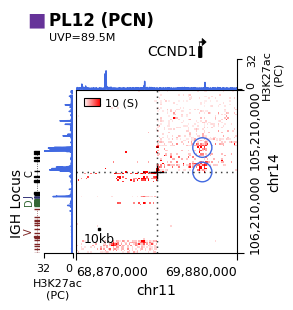

In [52]:
arima_sample =  arima_samples[0]
sample = SAMPLE_DICT[arima_sample.id]
bpoint = arima_sample.breakpoints[2]
regionX, regionY = bpoint.get_centered_regions_with_radius(500000)
resolution = 10000
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
gene_filter = ["CCND1"]
bw_tuple = BW_DICT[sample.meta.group]
fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter, vmax=10,
    show_neoloops=True, show_uvp=True)
fig.savefig(figure_path("test.svg"), bbox_inches="tight")

### Standard Triangle Plot

In [53]:
def plot_standard_triangle_plot(
    arima_sample: ArimaPipelineSample, 
    assembly: list[GenomicRegion],
    resolution: int, 
    keygenes=[], 
    norm=HIC_NORM,
    vmax=None, 
    gene_filter=None, 
    show_gene_full=False,
    hide_arrow_text=False, 
    max_bigwig=GLOBAL_BW_MAX, 
    size_base=1.2,
    gap_size=1,
    gap_value=0,
    show_neoloops=False,
    neoloop_filter: None | GenomicRegion=None,
    neoloop_interchrom_only=True,
    show_loops=False,
    loop_filter: None | GenomicRegion = None,
    loop_distance_filter=None,
    hr_gene=None, # height ratio of gene track
    show_bw1_track=False,
    bw1_pair=None,
    show_bw2_track=False,
    bw2_pair=None,
    show_cn_track=False,
    dot_size=1,
    plot_cnv_segments=False,
    cnv_lim=None,
    show_compartment_track=False,
    comp_abs_vmax=0.08,
    show_uvp=False,
    show_triangle_arcs=False,
    bw_num_bins=None,
):
    sample = SAMPLE_DICT[arima_sample.id] 
    
    assembled = arima_sample.get_assembled_hic(assembly, resolution, gap_size=gap_size, norm=norm, gap_value=gap_value)
    width_ratios = [abs(r.bin_range[1] - r.bin_range[0]) for r in assembled.plot_regions]

    hr_gene = hr_gene if hr_gene is not None else 1 if show_gene_full else 0.2
    hr_arc = 0.15 if show_triangle_arcs else 0
    hr_bw1 = 0.3 if show_bw1_track else 0
    hr_bw2 = 0.3 if show_bw2_track else 0
    hr_cn = 0.5 if show_cn_track else 0
    hr_comp = 0.1 if show_compartment_track else 0
    
    height_ratios_tracks = [hr_arc, hr_gene, hr_bw1, hr_bw2, hr_cn, hr_comp, 0.1, 0.2] # Gene, bigwig1, bigwig2, copy number, compartment, ctcf, arrow

    figheight = 2.5 + sum(height_ratios_tracks)
    figwidth = 5
    figsize = (size_base*figwidth, size_base*figheight)
    height_ratios = [2.5] + height_ratios_tracks
    fig = plt.figure(figsize=figsize)
    nrows = 1 + len(height_ratios_tracks)
    ncols = len(assembled.plot_regions)
    gs = fig.add_gridspec(nrows, ncols, wspace=0, hspace=0, height_ratios=height_ratios, width_ratios=width_ratios)

    ax_triangle = fig.add_subplot(gs[0, :])
    if vmax is None:
        vmax = np.nanmax(assembled.data) / 4
        
    plot_points = []
    if show_neoloops:
        neoloops = read_neoloops(sample.profile.neoloops)
        for neoloop in neoloops:
            hitsA = 0 
            hitsB = 0
            for region in assembly:
                if neoloop.regionA.overlaps(region):
                    hitsA += 1
                if neoloop.regionB.overlaps(region):
                    hitsB += 1
            if hitsA > 0 and hitsB > 0:
                if neoloop_filter is None or (neoloop_filter.overlaps(neoloop.regionA) or neoloop_filter.overlaps(neoloop.regionB)):
                    if (not neoloop_interchrom_only) or (neoloop.regionA.chrom != neoloop.regionB.chrom):
                        plot_points.append(neoloop)
    if show_loops:
        for plot_region in assembled.plot_regions:
            if plot_region.genomic_region is not None:
                new_loops = read_loops(sample.profile.loops_hicexplorer, filter_region=plot_region.genomic_region)
                for loop in new_loops:
                    if loop_filter is None or (loop_filter.overlaps(loop.regionA) or loop_filter.overlaps(loop.regionB)):
                        if loop_distance_filter is None or abs(loop.regionA.get_center() - loop.regionB.get_center()) > loop_distance_filter:
                            plot_points.append(loop)
    
    plot_assembled_triangle(
        assembled, resolution, ax=ax_triangle, 
        vmax=vmax, rasterized=True, aspect="auto", 
        normalization=norm, plot_points=plot_points,
        show_arcs=show_triangle_arcs
    )

    # ax_triangle.set_ylabel("Hi-C", fontsize=10, rotation=90, ha="right", va="center")
    ax_triangle.set_ylabel("")
    group_color = GROUP_COLORS[sample.meta.group]
    ax_triangle.text(-0.03, 0.908, "■", ha="right", va="center", fontsize=16, color=group_color, fontweight="bold", transform=ax_triangle.transAxes, clip_on=False)
    ax_triangle.text(0, 0.9, f"{arima_sample.id} ({sample.meta.group})", rotation=0, ha="left", va="center", fontsize=14, transform=ax_triangle.transAxes, clip_on=False, fontweight="bold")
    if show_uvp:
        ax_triangle.text(0, 0.85, f"UVP={(sample.uvp/1e6):.1f}M", ha="left", va="top", fontsize=9, transform=ax_triangle.transAxes, clip_on=False)
    
    for col, plot_region in enumerate(assembled.plot_regions):

        ax_arc = fig.add_subplot(gs[1, col])
        ax_gene = fig.add_subplot(gs[2, col])
        ax_bigwig1 = fig.add_subplot(gs[3, col])
        ax_bigwig2 = fig.add_subplot(gs[4, col])
        ax_cnv = fig.add_subplot(gs[5, col])
        ax_comp = fig.add_subplot(gs[6, col])
        ax_ctcf = fig.add_subplot(gs[7, col])
        ax_arrow = fig.add_subplot(gs[8, col])

        blank_axis(ax_arc)
        ax_arc.set_fc("none")
        
        all_nonarrow_tracks = [ax_gene, ax_bigwig1, ax_bigwig2, ax_cnv, ax_comp, ax_ctcf]
        
        if plot_region.genomic_region is None:
            for ax in [ax_gene] + all_nonarrow_tracks + [ax_arrow]:
                blank_axis(ax)
                ax.set_fc("none")
            continue
        else:
            # closest_to = bpoint.breakendA.pos if col == 0 else bpoint.breakendB.pos
            if show_gene_full:
                plot_gene_track_autospecial(plot_region.genomic_region, ax=ax_gene, 
                                            highlight_genes=keygenes, gene_filter=gene_filter,
                                            all_same_line=False, fontsize=10, label_side=True)
            else:
                plot_gene_track_autospecial(plot_region.genomic_region, ax=ax_gene, highlight_genes=keygenes, gene_filter=gene_filter, all_same_line=True, min_rows=0, max_rows=1, fontsize=12, label_side=True)
            ax_gene.set_ylabel("Genes", rotation=0, ha="right", va="center")

            if bw_num_bins is None:
                bw_num_bins=plot_region.genomic_region.get_size() // 2500
            if show_bw1_track and bw1_pair is not None:
                bw1_handle = pyBigWig.open(bw1_pair[1])
                bw1_label = bw1_pair[0]
                plot_bigwig_track(bw1_handle, plot_region.genomic_region, ymax=max_bigwig, label_right=False, ax=ax_bigwig1, num_bins=bw_num_bins, color=BIGWIG_COLOUR)
                ax_bigwig1.set_ylabel(f"H3K27ac\n({bw1_label})", rotation=0, ha="right", va="center")
            else:
                ax_bigwig1.axis('off')

            if show_bw2_track and bw2_pair is not None:
                bw2_handle = pyBigWig.open(bw2_pair[1])
                bw2_label = bw2_pair[0]
                plot_bigwig_track(bw2_handle, plot_region.genomic_region, ymax=max_bigwig, label_right=False, ax=ax_bigwig2, num_bins=bw_num_bins, color=BIGWIG_COLOUR)
                ax_bigwig2.set_ylabel(f"H3K27ac\n({bw2_label})", rotation=0, ha="right", va="center")
            else:
                ax_bigwig2.axis('off')

            if show_cn_track:
                cnv_lim = (-3, 3) if cnv_lim is None else cnv_lim
                plot_cnv_track(sample.profile.cnv_profile, sample.profile.cnv_segment, plot_region.genomic_region.chrom, ax=ax_cnv, locus_lim=(plot_region.genomic_region.start, plot_region.genomic_region.end), show_zero_line=True, cnv_lim=cnv_lim, plot_scatter=True, dot_size=dot_size, dot_alpha=1, plot_segments=plot_cnv_segments)
                ax_cnv.set_ylabel("Log2(CN)", rotation=0, fontsize=10, ha="right", va="center")
                if cnv_lim == (-3, 3):
                    ax_cnv.set_yticks([-2, 0, 2], [-2, 0, 2], fontsize=8)
                else:
                    ax_cnv.set_yticks([cnv_lim[0], 0, cnv_lim[1]], [cnv_lim[0], 0, cnv_lim[1]], fontsize=8)
                    ax_cnv.get_yticklabels()[0].set_va("bottom")
                    ax_cnv.get_yticklabels()[-1].set_va("top")
            else:
                ax_cnv.axis('off')

            if show_compartment_track:
                rstart = plot_region.genomic_region.start
                rend = plot_region.genomic_region.end
                plot_compartments(sample, plot_region.genomic_region, ax=ax_comp, vmax=comp_abs_vmax)
                ax_comp.set_ylabel("Compartments", rotation=0, fontsize=9, ha="right", va="center", y=0.7)
                blank_axis(ax_comp)
            else:
                ax_comp.axis('off')
 
            plot_ctcf_track("../annotations/CTCF/CTCF_motifs_STORM_hg38.bed", plot_region.genomic_region, ax=ax_ctcf)
            ax_ctcf.set_ylabel("CTCF Motifs", rotation=0, fontsize=9, ha="right", va="center", y=0.3)
            blank_axis(ax_ctcf)
            
            plot_arrow_track(plot_region.genomic_region, ax=ax_arrow)
            ax_arrow.set_ylabel("Region", rotation=0, fontsize=10, ha="right", va="center")
            
        for ax in [ax_gene] + all_nonarrow_tracks + [ax_arrow]:
            ax.set_fc("none")
            
        if col > 0:
            for ax in [ax_gene] + all_nonarrow_tracks + [ax_arrow]:
                ax.set_ylabel("")
                ax.set_yticks([])
                blank_axis(ax)
                
        if col == 0:
            for ax in [ax_bigwig1, ax_bigwig2]:
                ax.set_yticks([0, max_bigwig], ["0", max_bigwig], fontsize=8)
                ax.get_yticklabels()[0].set_va("bottom")
                ax.get_yticklabels()[-1].set_va("top")
        if show_triangle_arcs:
            if col == 0:
                ax_arc.spines[["left"]].set_visible(True)
                ax_arc.spines[["left"]].set_ec("gray")
            if col == len(assembled.plot_regions) - 1:
                ax_arc.spines[["right"]].set_visible(True)
                ax_arc.spines[["right"]].set_ec("gray")

        ax_gene.spines[["left", "right"]].set_visible(True)
        ax_gene.spines[["left", "right"]].set_ec("gray")
        for ax in all_nonarrow_tracks:
            ax.spines[["left", "right", "top"]].set_visible(True)
            ax.spines[["left", "right"]].set_ec("gray")
            ax.spines[["top"]].set_ec("lightgray")
            ax.spines[["top"]].set_linestyle(":")
            ax.spines[["left", "right"]].set_visible(True)
            ax.spines[["left", "right"]].set_ec("gray")

        if hide_arrow_text:
            text_arrows = ax_arrow.findobj(matplotlib.text.Text)
            for text in text_arrows:
                if "chr" in text.get_text():
                    text.set_text("")
                text.set_rotation(90)
                text.set_fontsize(6)

    if show_compartment_track:
        cax = fig.axes[0].inset_axes([0.85, 0.73, 0.15, 0.03])
        fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-comp_abs_vmax, vmax=comp_abs_vmax), cmap="seismic"), cax=cax, orientation='horizontal', ticks=[-comp_abs_vmax, 0, comp_abs_vmax])
        # cax.tick_params(rotation=-90, labelsize=7)
        cax.tick_params(labelsize=7)
        cax.get_xticklabels()[0].set_ha("left")
        cax.get_xticklabels()[-1].set_ha("right")
        cax.set_xticklabels([-comp_abs_vmax, 0, "+"+str(comp_abs_vmax)])
        cax.text(1,1.1, "Compartments", ha="right", va="bottom", transform=cax.transAxes, fontsize=8)
        
    return fig

#### Example

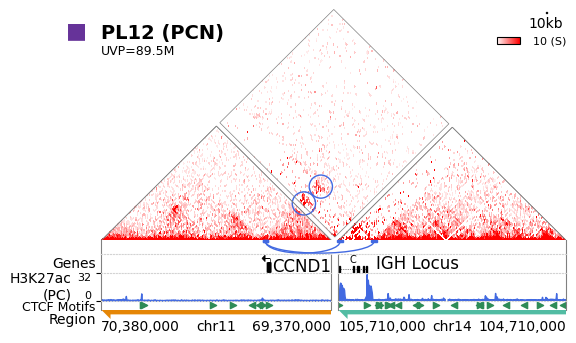

In [54]:
arima_sample =  arima_samples[0]
sample = SAMPLE_DICT[arima_sample.id]
bpoint = arima_sample.breakpoints[2]
regionLeft, regionRight = bpoint.get_reconstructed_regions_with_radius(1000000)
resolution = 10000
regionLeft = regionLeft.get_bin_aligned(resolution)
regionRight = regionRight.get_bin_aligned(resolution)
assembly = [regionLeft, regionRight]
gene_filter = ["CCND1"]
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_triangle_plot(
    arima_sample, assembly, resolution,
    gene_filter=gene_filter, gap_size=3,
    vmax=10,
    show_uvp=True, show_neoloops=True,
    show_bw1_track=True,
    bw1_pair=bw_tuple,
    show_triangle_arcs=True,
)

# General Features

## Correlations

In [72]:
reference = "GSE63525_GM12878"
samples_tilemap = samples + samples_pub_merge +  [ s for s in samples_pub_rao if s.meta.id_file != reference]
samples_tilemap += [s for s in samples_pub_rao if s.meta.id_file == reference]
ref_index = [ i for i,s in enumerate(samples_tilemap) if s.meta.id_file == reference][0]

In [74]:
arima_samples_tilemap = arima_samples + arima_samples_merge + [ s for s in arima_samples_rao if "GM12878" not in s.id]
arima_samples_tilemap += [s for s in arima_samples_rao if s.id == "*GM12878"]
assert(all(s.meta.id_paper == arima_sample.id for s, arima_sample in zip(samples_tilemap, arima_samples_tilemap)))

### Compartment Correlations

In [75]:
compartments_all_unfiltered = np.vstack([read_compartments(s.profile.compartments) for s in samples_tilemap ])
print(compartments_all_unfiltered.shape)
compartments_all = compartments_all_unfiltered[:, COMPARTMENT_SUBSET_INDICES] # blacklisted compartments excluded
print(compartments_all.shape)

(55, 28760)
(55, 26445)


In [76]:
compartment_correlations = [ scipy.stats.pearsonr(compartments_all[i, :], compartments_all[ref_index, :]).statistic for i in range(len(samples_tilemap))]
compartment_min =  np.min(compartment_correlations)
compartment_max = np.max([s for s, sample in zip(compartment_correlations, samples_tilemap) if sample.meta.id_file != reference])

In [77]:
compcorr_internal = [ n for i, n in enumerate(compartment_correlations) if samples_tilemap[i].meta.availability == "internal"]
compcorr_reference = [ n for i, n in enumerate(compartment_correlations) if samples_tilemap[i].meta.availability != "internal" and samples_tilemap[i].meta.id_file != reference]
print(len(compcorr_internal), np.mean(compcorr_internal), np.std(compcorr_internal))
print(len(compcorr_reference), np.mean(compcorr_reference), np.std(compcorr_reference))

44 0.7666447513595854 0.09405093964638846
10 0.7785958273636293 0.053257112158897585


### UVP

In [78]:
uvp_internal = [ get_uvp(sample.meta.id_file) for sample in samples_tilemap if sample.meta.availability == "internal" ]
uvp_min = np.min(uvp_internal)
uvp_max = np.max(uvp_internal)

In [79]:
raw_pairs_internal = [sample.qc.raw_pairs for sample in arima_samples]
uvp_proportions = [sample.qc.unique_valid_pairs / sample.qc.raw_pairs for sample in arima_samples]
print(np.min(raw_pairs_internal), np.max(raw_pairs_internal))
print(np.min(uvp_proportions), np.max(uvp_proportions))

101181210 535655271
0.01023139579616718 0.4352396235413442


In [80]:
print(uvp_min, uvp_max)

3509704 89513823


### Insulation Correlations

In [81]:
insulations_all_unfiltered = np.vstack([read_insulations(s.profile.insulations) for s in samples_tilemap ])
print(insulations_all_unfiltered.shape)
insulations_all = insulations_all_unfiltered[:, INSULATION_SUBSET_INDICES]
insulations_all = insulations_all[:, ~np.isnan(insulations_all).any(axis=0)]
print(insulations_all.shape)

(55, 308839)
(55, 248592)


In [82]:
insulation_correlations = [ scipy.stats.pearsonr(insulations_all[i, :], insulations_all[ref_index, :]).statistic for i in range(len(samples_tilemap))]
insulation_min =  np.min(insulation_correlations)
insulation_max = np.max([s for s, sample in zip(insulation_correlations, samples_tilemap) if sample.meta.id_file != reference])

In [83]:
insulation_corr_internal = [ n for i, n in enumerate(insulation_correlations) if samples_tilemap[i].meta.availability == "internal"]
insulation_corr_reference = [ n for i, n in enumerate(insulation_correlations) if samples_tilemap[i].meta.availability != "internal" and samples_tilemap[i].meta.id_file != reference]
print(len(insulation_corr_internal), np.mean(insulation_corr_internal), np.std(insulation_corr_internal))
print(len(insulation_corr_reference), np.mean(insulation_corr_reference), np.std(insulation_corr_reference))

44 0.6862518938736325 0.09208684822809651
10 0.687693560148442 0.04422556540223074


### TAD Boundary Correlations

In [84]:
def jaccard_similarity_sets(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

In [85]:
# This cell takes a while to run
def bin_position(position, resolution):
    return position // resolution * resolution

def get_tads_binned(sample: Sample, resolution=50000):
    binned = []
    for tad in read_tads(sample.profile.tads):
        binned.append((tad.chrom, bin_position(tad.start, resolution)))
        binned.append((tad.chrom, bin_position(tad.end, resolution)))
    return binned

ref_tads_binned = get_tads_binned(samples_tilemap[ref_index])
all_tads_binned = [None if sample.profile.tads is None else get_tads_binned(sample) for sample in samples_tilemap ]

In [86]:
tad_jaccards = [ None if tads is None else jaccard_similarity_sets(set(tads), set(ref_tads_binned)) for tads in all_tads_binned ]

In [87]:
tad_max = np.nanmax([ j for i, j in enumerate(tad_jaccards) if i != ref_index  and j is not None])
tad_min= np.nanmin([ j for j in tad_jaccards if j is not None])

In [88]:
tj_internal = [ n for i, n in enumerate(tad_jaccards) if samples_tilemap[i].meta.availability == "internal"]
tj_reference = [ n for i, n in enumerate(tad_jaccards) if samples_tilemap[i].meta.availability != "internal" and samples_tilemap[i].meta.id_file != reference]
print(len(tj_internal), np.mean(tj_internal), np.std(tj_internal))
print(len(tj_reference), np.mean(tj_reference), np.std(tj_reference))

44 0.2554093145622985 0.04352558861971036
10 0.24200385734401797 0.035168517295554584


### Loop Correlations

In [89]:
# This cell takes a while to run
def get_loops_binned(sample: Sample, resolution=50000):
    binned = []
    for loop in read_loops(sample.profile.loops_hicexplorer):
        anchorA = loop.regionA.get_center() // resolution * resolution
        anchorB =  loop.regionB.get_center() // resolution * resolution 
        binned.append((loop.regionA.chrom, anchorA, loop.regionB.chrom, anchorB))
    return binned 

ref_loops_binned = get_loops_binned(samples_tilemap[ref_index])
all_loops_binned = [ get_loops_binned(s) for s in samples_tilemap ]

In [90]:
loop_jaccards = [jaccard_similarity_sets(set(l), set(ref_loops_binned)) for l in all_loops_binned]

In [91]:
loop_max = np.nanmax([ l for i, l in enumerate(loop_jaccards) if i != ref_index  and l is not None])
loop_min= np.nanmin([ l for l in loop_jaccards if l is not None])

In [92]:
lj_internal = [ n for i, n in enumerate(loop_jaccards) if samples_tilemap[i].meta.availability == "internal"]
lj_reference = [ n for i, n in enumerate(loop_jaccards) if samples_tilemap[i].meta.availability != "internal" and samples_tilemap[i].meta.id_file != reference]
print(len(lj_internal), np.mean(lj_internal), np.std(lj_internal))
print(len(lj_reference), np.mean(lj_reference), np.std(lj_reference))

44 0.09580876528467569 0.060210495655304196
10 0.11543293916614701 0.02785470829362591


### SVs

In [93]:
svs_spread = [len(
    [b for b in arima_sample.breakpoints 
     if b.breakendA.chrom != b.breakendB.chrom 
     or abs(b.breakendA.pos - b.breakendB.pos) > 5000000])
              for arima_sample in arima_samples_tilemap ]
svs_max = np.max(svs_spread)
svs_min = np.min(svs_spread)
svs_max_trunc = np.max([sv for sv in svs_spread if sv != svs_max])

### Tabulated

In [94]:
for sample, vcomp, vins, vtad, vloop in zip(samples_tilemap, compartment_correlations, insulation_correlations, tad_jaccards, loop_jaccards):
    print(f"{sample.meta.id_paper}\t{get_uvp(sample.meta.id_file)}\t{vcomp:.2f}\t{vins:.2f}\t{vtad:.2f}\t{vloop:.2f}")

PL12	89513823	0.79	0.75	0.33	0.19
PL13	75106427	0.66	0.64	0.25	0.18
PL11	64839336	0.81	0.74	0.27	0.14
PL08	60541600	0.75	0.62	0.24	0.15
PL07	59939875	0.81	0.68	0.27	0.17
PL06	52591176	0.86	0.68	0.30	0.15
PL10	50894065	0.75	0.73	0.27	0.16
PL04	48639669	0.82	0.76	0.26	0.10
PL05	48181751	0.79	0.69	0.24	0.13
PL02	45382593	0.75	0.68	0.24	0.14
PL14	41327256	0.76	0.66	0.23	0.07
PL03	28381913	0.79	0.69	0.23	0.06
PL09	24961035	0.70	0.69	0.23	0.09
PL01	15756876	0.78	0.71	0.21	0.02
DC06	63325766	0.87	0.69	0.24	0.09
DC05	53519164	0.84	0.79	0.35	0.14
DC04	42742761	0.75	0.76	0.28	0.11
DC01	6819531	0.62	0.66	0.22	0.00
DC02	5640653	0.31	0.64	0.20	0.00
DC03	61310192	0.86	0.81	0.29	0.18
DL04	74954505	0.74	0.77	0.30	0.20
DL08	58297684	0.76	0.69	0.31	0.16
DL07	50831374	0.85	0.73	0.26	0.15
DL09	41944672	0.86	0.80	0.30	0.14
DL11	41438510	0.91	0.81	0.36	0.12
DL03	39766587	0.74	0.73	0.27	0.11
DL10	27074872	0.85	0.75	0.25	0.09
DL01	25417464	0.78	0.59	0.25	0.09
DL02	9769738	0.76	0.51	0.18	0.00
DL06	9062192	0.70

## Panels

### Horizontal Tilemap

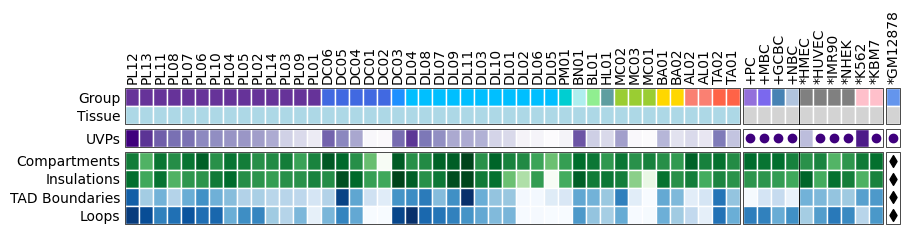

In [95]:
figsize = (10, 2)

fig, ax = plt.subplots(figsize=figsize)

tile_width = 1
tile_height = 1

tissue_colors = { 
    "Arima_FFPE": "lightblue",
    "Non-FFPE": "lightgray"
}

rows = ["ID", "Group", "Tissue", "UVPs", "Compartments", "Insulations", "TAD Boundaries", "Loops"]

ncols = len(samples_tilemap)
nrows = len(rows)

def plot_tile(row, col, color, xoffset=0, yoffset=0, ax=ax, ec="white"):
    x = xoffset + col - tile_width/2
    y = yoffset + row - tile_height/2
    rect = matplotlib.patches.Rectangle((x, y), tile_width, tile_height, fc=color, ec=ec, lw=1)
    ax.add_patch(rect)

yoffset_increment = 0.25

ylabel_pos = []
for col, (arima_sample, sample) in enumerate(zip(arima_samples_tilemap, samples_tilemap)):
    xoffset = 0 if sample.meta.availability == "internal" else 0.5 if sample.meta.id_paper == "*GM12878" else 0.25
    for row, row_name in enumerate(rows):
        yoffset = 0 
        if row >= 3: 
            yoffset += yoffset_increment
        if row >= 4:
            yoffset += yoffset_increment
        if col == 0:
            ylabel_pos.append(row+yoffset)
        match row_name:
            case "ID":
                ax.text(col + xoffset, tile_width/2 - tile_width/4 + yoffset, sample.meta.id_paper, fontsize=10, rotation=90, ha="center", va="bottom")
            case "Group":
                plot_tile(row, col, GROUP_COLORS[sample.meta.group], xoffset=xoffset, yoffset=yoffset)
            case "Tissue":
                color = tissue_colors[sample.meta.prep] if sample.meta.prep in tissue_colors else "lightgray"
                plot_tile(row, col, color, xoffset=xoffset, yoffset=yoffset)
            case "UVPs": 
                cmap = matplotlib.colormaps["Purples"]
                uvp_scaled = (sample.uvp - uvp_min) / (uvp_max - uvp_min)
                color = cmap(uvp_scaled)
                if sample.uvp > uvp_max:
                    plot_tile(row, col, "white", xoffset=xoffset, yoffset=yoffset)
                    ax.scatter([col+xoffset], [row+yoffset], marker="o", color=cmap.get_over())
                else:
                    plot_tile(row, col, color, xoffset=xoffset, yoffset=yoffset)
            case "Compartments":
                cmap = matplotlib.colormaps["Greens"]
                comp_corr = compartment_correlations[col]
                rescaled = (comp_corr - compartment_min) / (compartment_max - compartment_min)
                color = cmap(rescaled)
                text_color = "white" if rescaled > 0.5 else "black"
                if col == len(samples_tilemap) - 1:
                    plot_tile(row, col, "white", xoffset=xoffset, yoffset=yoffset)
                    ax.scatter([col+xoffset], [row+yoffset], marker="d", color="black")
                else:
                    plot_tile(row, col, color, xoffset=xoffset, yoffset=yoffset)
            case "Insulations":
                cmap = matplotlib.colormaps["Greens"]
                insulation_corr = insulation_correlations[col]
                rescaled = (insulation_corr - insulation_min) / (insulation_max - insulation_min)
                color = cmap(rescaled)
                if col== len(samples_tilemap) - 1:
                    plot_tile(row, col, "white", xoffset=xoffset, yoffset=yoffset)
                    ax.scatter([col+xoffset], [row+yoffset], marker="d", color="black")
                else:
                    plot_tile(row, col, color, xoffset=xoffset, yoffset=yoffset)
            case "TAD Boundaries":
                cmap = matplotlib.colormaps["Blues"]
                tad_jac = tad_jaccards[col]
                rescaled = (tad_jac - tad_min) / (tad_max - tad_min)
                color = cmap(rescaled)
                if col == len(samples_tilemap) - 1:
                    plot_tile(row, col, "white", xoffset=xoffset, yoffset=yoffset)
                    ax.scatter([col+xoffset], [row+yoffset], marker="d", color="black")
                else:
                    plot_tile(row, col, color, xoffset=xoffset, yoffset=yoffset)
            case "Loops":
                cmap = matplotlib.colormaps["Blues"]
                loop_jac = loop_jaccards[col]
                rescaled = (loop_jac - loop_min) / (loop_max - loop_min)
                color = cmap(rescaled)
                if col == len(samples_tilemap) - 1:
                    plot_tile(row, col, "white", xoffset=xoffset, yoffset=yoffset)
                    ax.scatter([col+xoffset], [row+yoffset], marker="d", color="black")
                else:
                    plot_tile(row, col, color, xoffset=xoffset, yoffset=yoffset)
            case _:
                pass

# Add rectangles
xoffset_increment = 0.25
col_lims = [
    (0-tile_height / 2, 43+tile_height / 2), 
    (43+tile_height/2 + 0.25, 47+tile_height/2+0.25),
    (47+tile_height/2 + 0.25, 53+tile_height/2+0.25),
    (53+tile_height/2 + 0.5, 54+tile_height/2+0.5),
]
row_lims = [
    (1-tile_width/2, 2+tile_width/2), 
    (2+tile_width/2+xoffset_increment, 3+tile_width/2+xoffset_increment), 
    (3+tile_width/2+xoffset_increment*2, 7+tile_width/2+xoffset_increment*2)
]
for (yrect0, yrect1) in row_lims:
    for (xrect0, xrect1) in col_lims:
        ax.add_patch(Rectangle((xrect0, yrect0), xrect1-xrect0, yrect1-yrect0, fc="none", ec="black", lw=0.5, clip_on=False))

ax.set_xlim((-tile_width/2, ncols+tile_width/2+xoffset-1))
ax.set_ylim((-tile_height/2, nrows-tile_height/2+yoffset))
ax.invert_yaxis()

ax.spines[["top", "left", "right", "bottom"]].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

ax.set_yticks(ylabel_pos[1:], rows[1:]) # Skip ID yticklabel
ax.tick_params(axis=u'both', which=u'both',length=0)

fig.savefig(figure_path("cohort_overview_topology_tilemap.svg"), bbox_inches="tight")

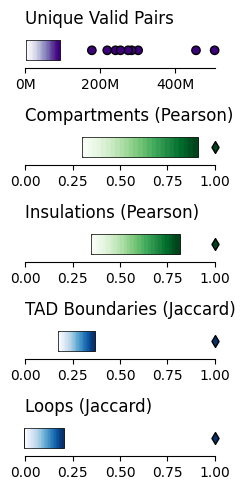

In [96]:
fig, ax = plt.subplots(5, 1, figsize=(2.5, 5))

@dataclass
class TileColorbarSpec:
    title: str
    colormap: object 
    accessor: callable
    clim: tuple[float, float]
    axlim: tuple[float | None, float | None] = (0, None)

specs = [
    TileColorbarSpec(
        "Unique Valid Pairs",
        matplotlib.colormaps["Purples"],
        lambda i, s: s.uvp,
        (uvp_min, uvp_max),
        (0, None)
    ),

     TileColorbarSpec(
        "Compartments (Pearson)",
        matplotlib.colormaps["Greens"],
        lambda i, s: compartment_correlations[i],
        (compartment_min, compartment_max),
        (0, 1),
    ),
    TileColorbarSpec(
        "Insulations (Pearson)",
        matplotlib.colormaps["Greens"],
        lambda i, s: insulation_correlations[i],
        (insulation_min, insulation_max),
        (0, 1)
    ),
    TileColorbarSpec(
        "TAD Boundaries (Jaccard)",
        matplotlib.colormaps["Blues"],
        lambda i, s: tad_jaccards[i],
        (tad_min, tad_max),
        (0, 1)
    ),
    TileColorbarSpec(
        "Loops (Jaccard)",
        matplotlib.colormaps["Blues"],
        lambda i, s: loop_jaccards[i],
        (loop_min, loop_max),
        (0, 1)
    ),
]

def plot_colormap_rectangle(axmin, axmax, colormap, ax):
    num_rects = 25
    rect = matplotlib.patches.Rectangle((axmin, -1), axmax-axmin, 2, fc="none", ec="black", lw=2, clip_on=False)
    ax.add_patch(rect)
    # Make 25 colormap values
    cmap_values = colormap(np.linspace(0, 1, num=num_rects))
    rwidth = (axmax - axmin) / num_rects
    for i in range(num_rects):
        rect = matplotlib.patches.Rectangle((axmin+i*rwidth, -1), rwidth, 2, color=cmap_values[i])
        ax.add_patch(rect)

for i, spec in enumerate(specs):
    ax_spec = ax[i]
    # Exclude reference sample if correlation metric
    # if spec.axlim[1] == 1:
        # all_values = [ spec.accessor(i, s) for i, s in enumerate(samples) if i != ref_index ]
    # else:
        # all_values = [ spec.accessor(i, s) for i, s in enumerate(samples) ]
    all_values = [ spec.accessor(i, s) for i, s in enumerate(samples_tilemap) ]
    marker = "d" if spec.axlim[1] == 1 else "o"
    full_max = np.max([v for v in all_values if v is not None])
    xmin, xmax = spec.axlim
    xmax = full_max if xmax is None else xmax
    rmin, rmax = spec.clim
    plot_colormap_rectangle(rmin, rmax, spec.colormap, ax_spec)

    scatter_points = [v for v in all_values if v is not None and (v < rmin or v > rmax) ]
    scatter_colors = [ spec.colormap.get_over() if v > rmax else spec.colormap.get_under() for v in scatter_points]
    ax_spec.scatter(scatter_points, [0]*len(scatter_points), c=scatter_colors, edgecolors="black", clip_on=False, marker=marker)
    
    ax_spec.set_xlim((xmin, xmax))
    ax_spec.set_ylim((-2, 2))
    ax_spec.set_title(spec.title, ha="left", x=0)
    ax_spec.spines[["top", "left", "right"]].set_visible(False)
    ax_spec.set_yticks([])

    if spec.title == "Unique Valid Pairs":
        ax_spec.xaxis.set_major_formatter(lambda x, pos: f"{int(x/1e6)}M")

fig.tight_layout()
fig.savefig(figure_path("tilemap_colorbars.svg"), bbox_inches="tight")

### Vertical Tilemap

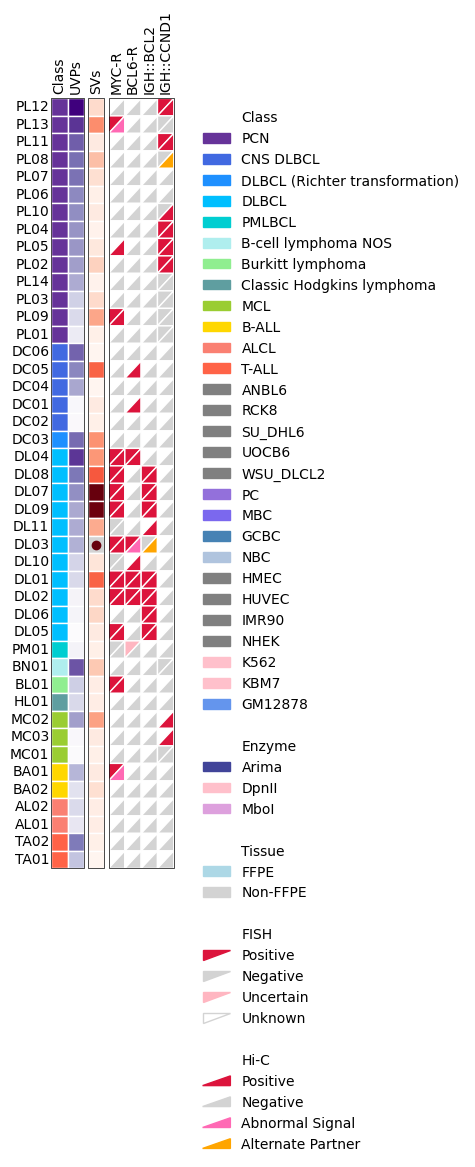

In [97]:
# figsize=(0.2, 6)
save_name="supp1_tilemap.svg"
is_mini = True
if is_mini:
    figsize=(2, 10)
    save_name="fig1_tilemap.svg"

columns = ["ID", "Class", "UVPs",  "SVs", "MYC-R", "BCL6-R", "IGH::BCL2", "IGH::CCND1", ]

nrows = len(samples)
ncols = len(columns)

fig, ax = plt.subplots(figsize=figsize)

tile_width = 1
tile_height = 1

tissue_colors = { 
    "Arima_FFPE": "lightblue",
    "Non-FFPE": "lightgray"
}


enzyme_colors = {
    "Arima": "#414499",
    "DpnII": "pink",
    "MboI": "plum",
}

unknown_color = "white"
negative_color = "lightgray"
positive_color = "crimson"
other_fish_color = "lightpink"
asterisk_color = "hotpink"
hic_detected_color = "crimson"
other_color = "orange"

def plot_tile(row, col, color, xoffset=0, yoffset=0, ax=ax):
    x = xoffset + col - tile_width/2
    y = yoffset + row - tile_height/2
    rect = matplotlib.patches.Rectangle((x, y), tile_width, tile_height, fc=color, ec="white", lw=1)
    ax.add_patch(rect)

def plot_triangle(row, col, color, side, xoffset=0, yoffset=0):
    match side:
        case "upper left":
            c1 = (xoffset+col-tile_width/2, yoffset+row-tile_height/2)
            c2 = (xoffset+col+tile_width/2, yoffset+row-tile_height/2)
            c3 = (xoffset+col-tile_width/2, yoffset+row+tile_height/2)
        case "lower right": 
            c1 = (xoffset+col+tile_width/2, yoffset+row+tile_height/2)
            c2 = (xoffset+col+tile_width/2, yoffset+row-tile_height/2)
            c3 = (xoffset+col-tile_width/2, yoffset+row+tile_height/2)
        case _: 
            raise ValueError(f"Unknown side: {side}. Must be either 'upper left' or 'lower right'")
    poly = matplotlib.patches.Polygon([c1, c2, c3], fc=color, ec="white", lw=1)
    ax.add_patch(poly)

def has_gene_rearrangement(arima_sample: ArimaPipelineSample, gene: str):
    # Only looking at rearrangements (not dups/amplifications)
    svs = [s for s in arima_sample.breakpoints if s.breakendA.chrom != s.breakendB.chrom or abs(s.breakendA.pos - s.breakendB.pos) > 5000000]
    found = False
    rearrangements = []
    rearranged_genes = []
    for sv in svs:
        regionA, regionB = sv.get_reconstructed_regions_with_radius(radius=1000000)
        nearbyA = regionA.get_contained_genes()
        nearbyB = regionB.get_contained_genes()
        nearby = [g.gene_name for g in nearbyA + nearbyB]
        if gene in nearby:
            found = True
            rearrangements.append(sv)
            rearranged_genes += nearby
    return found, rearrangements, list(set(rearranged_genes))

gene_rearrangements = defaultdict(list)

xoffset_increment = 0.25
xlabel_pos = []
for row, (arima_sample, sample) in enumerate(zip(arima_samples, samples)):
    yoffset = 0 if sample.meta.availability == "internal" else 0.25
    for col, column in enumerate(columns):
        xoffset = 0 
        if col > 2: 
            xoffset = xoffset + xoffset_increment
        if col > 3:
            xoffset = xoffset + xoffset_increment
        if row == 0:
            xlabel_pos.append(col+xoffset)
        match column:
            case "ID": 
                ax.text(tile_width/2 - tile_width/8 + xoffset, row + yoffset, sample.meta.id_paper, fontsize=10, ha="right", va="center")
            case "Class":
                plot_tile(row, col, GROUP_COLORS[sample.meta.group], xoffset=xoffset, yoffset=yoffset)
            case "Tissue":
                color = tissue_colors[sample.meta.prep] if sample.meta.prep in tissue_colors else "lightgray"
                plot_tile(row, col, color, xoffset=xoffset, yoffset=yoffset)
            case "Enzyme":
                color = enzyme_colors[sample.meta.enzyme]
                plot_tile(row, col, color, xoffset=xoffset, yoffset=yoffset)
            case "UVPs": 
                cmap = matplotlib.colormaps["Purples"]
                uvp_scaled = (sample.uvp - uvp_min) / (uvp_max - uvp_min)
                color = cmap(uvp_scaled)
                if not is_mini:
                    plot_tile(row, col, color, xoffset=xoffset, yoffset=yoffset)
                    text_color = "white" if sample.uvp > 40000000 else "black"
                    ax.text(col+xoffset, row+yoffset, f"{int(sample.uvp/1e6)}M", fontsize=8, color=text_color, ha="center", va="center")
                else:
                    if sample.uvp > uvp_max:
                        plot_tile(row, col, "lightgray", xoffset=xoffset, yoffset=yoffset)
                        ax.scatter([col+xoffset], [row+yoffset], marker="o", color=cmap.get_over())
                    else:
                        plot_tile(row, col, color, xoffset=xoffset, yoffset=yoffset)
            case "SVs":
                cmap = matplotlib.colormaps["Reds"]
                num_svs = svs_spread[row]
                sv_scaled = (num_svs - svs_min) / (svs_max_trunc - svs_min)
                color = cmap(sv_scaled)
                if not is_mini:
                    plot_tile(row, col, color, xoffset=xoffset, yoffset=yoffset)
                    text_color = "white" if sv_scaled > 0.5 else "black"
                    ax.text(col+xoffset, row+yoffset, f"{num_svs}", fontsize=8, color=text_color, ha="center", va="center")
                else:
                    if num_svs > svs_max_trunc:
                        plot_tile(row, col, "lightgray", xoffset=xoffset, yoffset=yoffset)
                        ax.scatter([col+xoffset], [row+yoffset], marker="o", color=cmap.get_over())
                    else:
                        plot_tile(row, col, color, xoffset=xoffset, yoffset=yoffset)
            case "MYC-R" | "BCL6-R" | "IGH::BCL2" | "IGH::CCND1":
                gene = column.replace("-R", "") if column in ["MYC-R", "BCL6-R"] else "BCL2" if "BCL2" in column else "CCND1" if "CCND1" in column else ""
                column_name = column.replace("-", "_").replace("IGH::", "").lower()
                column_name = "igh_" + column_name + "_r" if gene in {"BCL2", "CCND1"} else column_name
                if isinstance(sample.meta[column_name], str):
                    if sample.meta[column_name] == "positive":
                        color_left = positive_color
                    elif sample.meta[column_name] == "negative":
                        color_left = negative_color
                    else:
                        color_left = other_fish_color
                else:
                    color_left = unknown_color
                bool_has_gene_rearrangement, rearrangements, rearranged_genes = has_gene_rearrangement(arima_sample, gene)
                color_right = negative_color
                # Highlight rearrangement with alternate partner
                if bool_has_gene_rearrangement:
                    gene_rearrangements[gene].append((sample, rearrangements))
                    if column_name.startswith("igh"):
                        if any(g.startswith("IGH") for g in rearranged_genes):
                            color_right = hic_detected_color
                        else:
                            color_right = other_color
                    else:
                        # Highlight rearrangements that have abnormal signal/faint signal on Hi-C
                        if gene == "MYC" and sample.meta.id_paper == "BA01":
                            color_right = asterisk_color
                        elif gene == "BCL6" and sample.meta.id_paper == "DL03":
                            color_right = asterisk_color
                        else:
                            color_right = hic_detected_color
                # Highlight rearrangements with alternate partner / other abnormal signal on Hi-C
                if column == "IGH::CCND1" and sample.meta.id_paper == "PL08":
                    color_right = other_color
                elif gene == "MYC" and sample.meta.id_paper == "PL13":
                    color_right = asterisk_color
                plot_triangle(row, col, color_left, "upper left", xoffset=xoffset, yoffset=yoffset)
                plot_triangle(row, col, color_right, "lower right", xoffset=xoffset, yoffset=yoffset)


# Draw rectangles
row_lims = [
    (0-tile_height / 2, 43+tile_height / 2), 
]
    # (43+tile_height/2 + 0.25, 54+tile_height/2+0.25)]
col_lims = [
    (1-tile_width/2, 2+tile_width/2), 
    (2+tile_width/2+xoffset_increment, 3+tile_width/2+xoffset_increment), 
    (3+tile_width/2+xoffset_increment*2, 7+tile_width/2+xoffset_increment*2)
]
for (yrect0, yrect1) in row_lims:
    for (xrect0, xrect1) in col_lims:
        ax.add_patch(Rectangle((xrect0, yrect0), xrect1-xrect0, yrect1-yrect0, fc="none", ec="black", lw=0.5, clip_on=False))
    
# Custom legend
legend_handles = []
legend_labels = []
def add_legend_title(title, spacer=True):
    if spacer:
        legend_handles.append(matplotlib.patches.Rectangle((0,0), 0, 0, color="white"))
        legend_labels.append("")
    legend_handles.append(matplotlib.patches.Rectangle((0,0), 0, 0, color="white"))
    legend_labels.append(title)
    # legend_labels.append(title)
def add_legend_dict_colors(d):
    for name, color in d.items():
        legend_handles.append(matplotlib.patches.Patch(color=color))
        legend_labels.append(name.replace("Arima_", ""))
        
add_legend_title("Class", spacer=False)
add_legend_dict_colors(GROUP_COLORS)
add_legend_title("Enzyme")
add_legend_dict_colors(enzyme_colors)
add_legend_title("Tissue")
add_legend_dict_colors(tissue_colors)
add_legend_title("FISH")

class LegendTriangle:
    def __init__(self, color, loc, ec=None):
        self.color=color
        if ec is None:
            self.edgecolor=color
        else:
            self.edgecolor=ec
        self.loc=loc
class LegendTriangleHandler:
    def legend_artist(self, orig_handle, fontsize, handlebox):
        x, y = handlebox.xdescent, handlebox.ydescent
        w, h = handlebox.width, handlebox.height
        if orig_handle.loc == "upper left":
            corners = [[x, y], [x, y + h], [x + w, y + h]]
        elif orig_handle.loc == "lower right":
            corners = [[x, y], [x + w, y + h], [x + w, y]]
        triangle = matplotlib.patches.Polygon(corners, fc=orig_handle.color, ec=orig_handle.edgecolor, transform=handlebox.get_transform(), lw=1)
        handlebox.add_artist(triangle)
        return triangle
legend_handles.append(LegendTriangle(positive_color, "upper left"))
legend_labels.append("Positive")
legend_handles.append(LegendTriangle(negative_color, "upper left"))
legend_labels.append("Negative")
legend_handles.append(LegendTriangle(other_fish_color, "upper left"))
legend_labels.append("Uncertain")
legend_handles.append(LegendTriangle(unknown_color, "upper left", "lightgray"))
legend_labels.append("Unknown")
add_legend_title("Hi-C")
legend_handles.append(LegendTriangle(hic_detected_color, "lower right"))
legend_labels.append("Positive")
legend_handles.append(LegendTriangle(negative_color, "lower right"))
legend_labels.append("Negative")
legend_handles.append(LegendTriangle(asterisk_color, "lower right"))
legend_labels.append("Abnormal Signal")
legend_handles.append(LegendTriangle(other_color, "lower right"))
legend_labels.append("Alternate Partner")

ax.legend(handles=legend_handles, labels=legend_labels, loc="upper left", bbox_to_anchor=(1,1), frameon=False, handler_map={LegendTriangle: LegendTriangleHandler})

ax.set_xlim((-tile_width/2, ncols+tile_width/2+xoffset))
ax.set_ylim((-tile_height/2, nrows-tile_height/2+yoffset))
ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
ax.set_yticks([])
ax.set_xticks(xlabel_pos[1:], columns[1:], rotation=90, ha="center", va="bottom")
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.tick_params(axis=u'both', which=u'both',length=0)

fig.savefig(figure_path(save_name), bbox_inches="tight")

### TAD Plotting

In [98]:
def plot_tad_region(gregion: GenomicRegion, goi: str|None):
    nrows = len(samples_all_merge) + 2
    fig, ax = plt.subplots(nrows, 1, figsize=(2.8, 5.6), height_ratios=[2.5, 1.5] + [1] * len(samples_all_merge))
    fig.subplots_adjust(hspace=0)
    
    ax_gene = ax[0]
    ax_ctcf = ax[1]

    if goi is None:
        gene_filter = None
    else:
        gene_filter = [goi]
    plot_gene_track(gregion, gene_filter=gene_filter, min_rows=0, max_rows=1, fontsize=10, ax=ax_gene)
    plot_ctcf_track(CTCF_BEDFILE, gregion, ax=ax_ctcf)
    
    for i, sample in list(enumerate(samples_all_merge)):
        color = GROUP_COLORS[sample.meta.group]
        ax_sample = ax[i+2]
    
        tads = pd.read_csv(sample.profile.tads, names=["chrom", "start", "end", "hierarchy"], sep="\t")
        chrom = gregion.chrom
        start = gregion.start
        end = gregion.end
        tads = tads[((tads.chrom == chr_unprefix(chrom)) | (tads.chrom == chrom)) & (tads.hierarchy == 0)]
        for _, tad in tads.iterrows():
            if gregion.overlaps(GenomicRegion(tad.chrom, tad.start, tad.end)):
                if tad.hierarchy == 0:
                    s = 20
                ax_sample.scatter([tad.start], [0], marker=9, color=color, s=s)
                ax_sample.scatter([tad.end], [0], marker=8, color=color, s=s)
                ax_sample.barh(0, tad.end - tad.start, left = tad.start, color=color, height=0.5)
    
        ax_sample.set_xlim((start, end))
        ax_sample.set_ylim(-1, 1)
        blank_axis(ax_sample)
    
    ax[1].set_ylabel("CTCF\nMotifs", rotation=0, ha="right", va="center", fontsize=8,)
    ax[-1].spines[["bottom"]].set_visible(True)
    ax_sample.set_xticks([start, end], [f"{start:,}", f"{end:,}"])
    ax_sample.get_xticklabels()[0].set_horizontalalignment("left")
    ax_sample.get_xticklabels()[-1].set_horizontalalignment("right")
    ax_sample.set_xlabel(chrom)
    return fig

#### Example

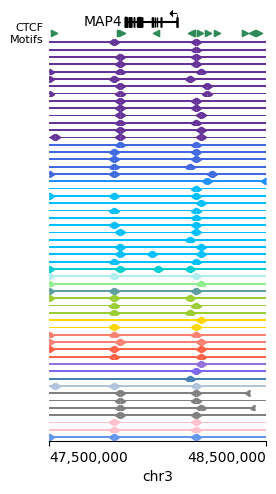

In [99]:
tad_region = GenomicRegion("chr3", 47500000,48500000)
fig = plot_tad_region(tad_region, goi=None)

### Tilemap B

Regions of interest:

In [100]:
cmap_uvp =  matplotlib.colormaps["Greys"]
cmap_compartments =  matplotlib.colormaps["Greens"]
cmap_insulations =  matplotlib.colormaps["Greens"]
cmap_tads =  matplotlib.colormaps["Blues"]
cmap_loops =  matplotlib.colormaps["Blues"]

cmap_scores_compartments = matplotlib.colormaps["seismic"]
cmap_scores_insulations = matplotlib.colormaps["BrBG"]
cmap_scores_loops = matplotlib.colormaps["Oranges"]

In [101]:
comp_region = GenomicRegion("chr3", 175000000, 182500000)
comp_subset_chrom = COMPARTMENT_REGIONS_100kb[(COMPARTMENT_REGIONS_100kb.chr == comp_region.chrom)]
comp_subset_start = comp_subset_chrom[comp_subset_chrom.start == comp_region.start].index[0]
comp_subset_end = comp_subset_chrom[comp_subset_chrom.start == comp_region.end].index[0]

In [102]:
ins_region = GenomicRegion("chr3", 186000000, 187000000) # comparison
ins_subset_chrom = INSULATION_REGIONS[(INSULATION_REGIONS.chrom == ins_region.chrom)]
ins_subset_start = ins_subset_chrom[ins_subset_chrom.start == ins_region.start].index[0]
ins_subset_end = ins_subset_chrom[ins_subset_chrom.start == ins_region.end].index[0]

In [103]:
loop_resolution = 10000

loop_region = GenomicRegion("chr3", 122520000, 122720000).get_bin_aligned(loop_resolution)
loop_anchor = GenomicPosition("chr3", 122560000)

loop_regionX = loop_region
loop_regionY = GenomicRegion(loop_anchor.chrom, loop_anchor.pos, loop_anchor.pos + loop_resolution).get_bin_aligned(loop_resolution)

all_virtual_data = []
for arima_sample in arima_samples_tilemap:
    virtual_data = arima_sample.get_hic_region_data(loop_regionX, loop_regionY, resolution=loop_resolution, normalization=HIC_NORM)
    virtual_data = virtual_data / virtual_data.max()
    all_virtual_data.append(virtual_data)

In [104]:
max_overall_uvp = np.max([ get_uvp(sample.meta.id_file) for sample in samples_tilemap])

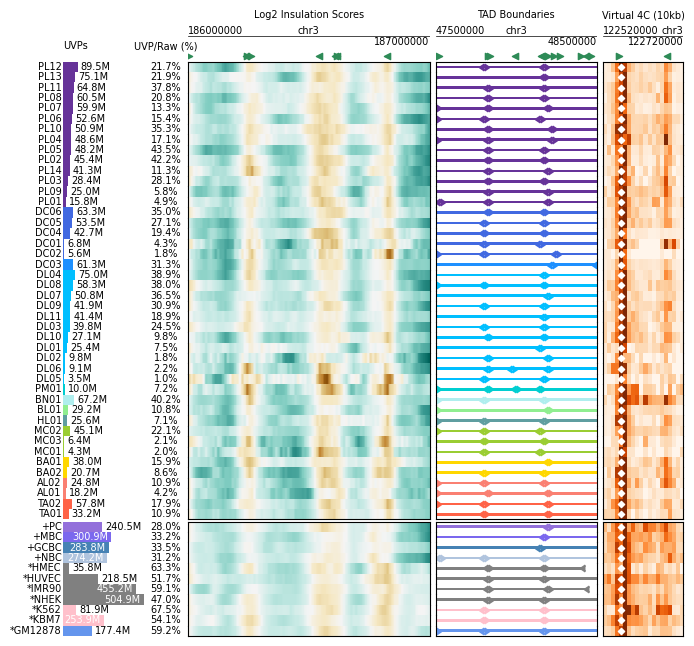

In [105]:
nrows = 2 + 1 + len(samples_tilemap)

ncols = 5

height_ratios = [3, 1] + [1] * len(samples) + [0.2] + [1] * (len(samples_pub_merge) + len(samples_pub_rao))
row_to_i_sample = [None, None] + list(range(len(samples))) + [None] + [l + len(samples) for l in range(len(samples_pub_merge + samples_pub_rao))]
row_start_pub = [i for i, v in enumerate(row_to_i_sample) if v is None][-1] + 1

width_ratios = [5, 2, 15, 10, 5]

figsize=(8,8)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, height_ratios = height_ratios, width_ratios=width_ratios)
fig.subplots_adjust(hspace=0, wspace=0.05)

vmin_comp = -0.06
vmax_comp = abs(vmin_comp)
vmin_ins = -2
vmax_ins = abs(vmin_ins)

vmin_loops = 0
vmax_loops = 1

tile_width = 1
tile_height = 1
marker_size = 10
xoffset=0

def plot_tile(xcenter, color, ax):
    ycenter = tile_height / 2
    x = xcenter - tile_width/2
    y = ycenter - tile_height/2
    rect = matplotlib.patches.Rectangle((x, y), tile_width, tile_height, fc=color, ec="white", lw=1, clip_on=False)
    ax.add_patch(rect)

for row in range(nrows):

    for col in range(ncols):
        ax = axes[row, col]
        ax.set_fc("none")
        ax.set_xticks([])
        ax.set_yticks([])
        i_sample = row_to_i_sample[row]
        
        if row == 0:
            blank_axis(ax)
            match col:
                case 0:
                    ax.set_xlim(0, max_overall_uvp)
                    ax.text(0,0, "UVPs", fontsize=7, transform=ax.transAxes, ha="left", va="bottom")
                case 1:
                    ax.text(0.5,0, "UVP/Raw (%)", fontsize=7, transform=ax.transAxes, ha="center", va="bottom")
                case 2:
                    ax.plot([0, 1], [0, 0], lw=0.5, color="black")
                    ax.text(0, 0, ins_region.start, fontsize=7, ha="left", va="bottom")
                    ax.text(0.5, 0, ins_region.chrom, fontsize=7, ha="center", va="bottom")
                    ax.text(1, -0.1, ins_region.end, fontsize=7, ha="right", va="top")
                    ax.set_xlim(0, 1)
                    ax.set_ylim(-1, 1)
                    ax.text(0.5, 1, "Log2 Insulation Scores", fontsize=7, ha="center", va="bottom")
                case 3:
                    ax.plot([0, 1], [0, 0], lw=0.5, color="black")
                    ax.text(0, 0, tad_region.start, fontsize=7, ha="left", va="bottom")
                    ax.text(0.5, 0, tad_region.chrom, fontsize=7, ha="center", va="bottom")
                    ax.text(1, -0.1, tad_region.end, fontsize=7, ha="right", va="top")
                    ax.set_xlim(0, 1)
                    ax.set_ylim(-1, 1)
                    ax.text(0.5, 1, "TAD Boundaries", fontsize=7, ha="center", va="bottom")
                case 4:
                    ax.plot([0, 1], [0, 0], lw=0.5, color="black")
                    ax.text(0, 0, loop_regionX.start, fontsize=7, ha="left", va="bottom")
                    ax.text(1, 0, loop_regionX.chrom, fontsize=7, ha="right", va="bottom")
                    ax.text(1, -0.1, loop_regionX.end, fontsize=7, ha="right", va="top")
                    ax.set_xlim(0, 1)
                    ax.set_ylim(-1, 1)
                    ax.text(0.5, 1, f"Virtual 4C ({int_to_resolution(loop_resolution)})", fontsize=7, ha="center", va="bottom")
                case _:
                    pass
            continue
        if row == 1:
            match col:
                case 2:
                    plot_ctcf_track(CTCF_BEDFILE, ins_region, ax=ax)
                case 3:
                    plot_ctcf_track(CTCF_BEDFILE, tad_region, ax=ax)
                case 4:
                    plot_ctcf_track(CTCF_BEDFILE, loop_regionX, ax=ax)
                case _:
                    blank_axis(ax)
            continue
            
        if i_sample is None:
            blank_axis(ax)
            continue
            
        sample = samples_tilemap[i_sample]       
        match col:
            case 0: # Tiles
                sample_color = GROUP_COLORS[sample.meta.group]
                ax.set_ylim(0, tile_height)
                ax.text(-max_overall_uvp/50, tile_height / 2, sample.meta.id_paper, fontsize=7, va="center", ha="right")
                ax.barh(tile_height/2, width = sample.uvp, height=tile_height, color=sample_color)
                if sample.uvp / max_overall_uvp < 0.5:
                    ax.text(sample.uvp + (max_overall_uvp / 25), tile_height/2, f"{sample.uvp/1e6:.1f}M", color="black", ha="left", va="center", fontsize=7)
                else:
                    ax.text(sample.uvp - (max_overall_uvp / 25), tile_height/2, f"{sample.uvp/1e6:.1f}M", color="white", ha="right", va="center", fontsize=7)
                ax.set_xlim(0, max_overall_uvp)
                ax.spines[["top", "left", "right", "bottom"]].set_visible(False)

            case 1:
                sample_color = GROUP_COLORS[sample.meta.group]
                ax.set_ylim(0, tile_height)
                qc = QCData.from_file(sample.profile.qc)
                percent_uvp = 100 * sample.uvp / qc.raw_pairs
                ax.text(0.5, 0.5, f"{percent_uvp:.1f}%", color="black", ha="center", va="center", fontsize=7, transform=ax.transAxes)
                ax.spines[["top", "left", "right", "bottom"]].set_visible(False)

            case 2: # Insulations
                sample_insulations = np.expand_dims(insulations_all_unfiltered[i_sample, ins_subset_start:ins_subset_end], axis=0)
                ax.imshow(sample_insulations, cmap=cmap_scores_insulations, vmin=vmin_ins, vmax=vmax_ins, aspect="auto")
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines[[ "top", "bottom" ]].set_visible(False)
                if row == 2 or row == row_start_pub:
                    ax.spines[[ "top"]].set_visible(True)
                elif row == row_start_pub-2 or row == nrows-1:
                    ax.spines[[ "bottom"]].set_visible(True)
                    
            case 3: # TADS
                color = GROUP_COLORS[sample.meta.group]
                tads = pd.read_csv(sample.profile.tads, names=["chrom", "start", "end", "hierarchy"], sep="\t")
                chrom = tad_region.chrom
                start = tad_region.start
                end = tad_region.end
                tads = tads[((tads.chrom == chr_unprefix(chrom)) | (tads.chrom == chrom)) & (tads.hierarchy == 0)]
                for _, tad in tads.iterrows():
                    if tad_region.overlaps(GenomicRegion(tad.chrom, tad.start, tad.end)):
                        if tad.hierarchy == 0:
                            s = 20
                            ax.scatter([tad.start], [0], marker=9, color=color, s=s)
                            ax.scatter([tad.end], [0], marker=8, color=color, s=s)
                            ax.barh(0, tad.end - tad.start, left = tad.start, color=color, height=0.5)
                ax.set_xlim((start, end))
                ax.set_ylim(-1, 1)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines[[ "top", "bottom" ]].set_visible(False)
                if row == 2 or row == row_start_pub:
                    ax.spines[[ "top"]].set_visible(True)
                elif row == row_start_pub-2 or row == nrows-1:
                    ax.spines[[ "bottom"]].set_visible(True)
 
                    
            case 4: # Loops
                sample_loops = all_virtual_data[i_sample]
                ax.imshow(sample_loops, cmap=cmap_scores_loops, vmin=vmin_loops, vmax=vmax_loops, aspect="auto", extent=[loop_regionX.start, loop_regionX.end, 0, 1])
                ax.scatter(loop_anchor.pos + loop_resolution / 2, 0.5, marker="D", fc="white", ec="white", s=marker_size)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines[[ "top", "bottom" ]].set_visible(False)
                if row == 2 or row == row_start_pub:
                    ax.spines[[ "top"]].set_visible(True)
                elif row == row_start_pub-2 or row == nrows-1:
                    ax.spines[[ "bottom"]].set_visible(True)
               
            case _:
                continue

fig.savefig(figure_path("topology_map.svg"), bbox_inches="tight")

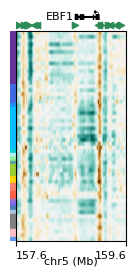

In [106]:
highlight_ins_region = GenomicRegion("chr5", 157620000, 159620000) #EBF1
highlight_ins_subset_chrom = INSULATION_REGIONS[(INSULATION_REGIONS.chrom == highlight_ins_region.chrom)]
highlight_ins_subset_start = highlight_ins_subset_chrom[highlight_ins_subset_chrom.start == highlight_ins_region.start].index[0]
highlight_ins_subset_end = highlight_ins_subset_chrom[highlight_ins_subset_chrom.start == highlight_ins_region.end].index[0]

fig, ax = plt.subplots(3, 2, figsize=(1.5,3), height_ratios=[1, 1, 20], width_ratios=[1, 18])
fig.subplots_adjust(hspace=0, wspace=0)
ax_gene = ax[0, 1]
ax_ctcf = ax[1, 1]
ax_main = ax[2, 1]
ax[0, 0].axis('off')
ax[1, 0].axis('off')
ax_bar = ax[2, 0]
plot_gene_track(highlight_ins_region, gene_filter=["EBF1"], ax=ax_gene, all_same_line=True)
plot_ctcf_track(CTCF_BEDFILE, highlight_ins_region, ax=ax_ctcf)

for i, sample in enumerate(samples_tilemap):
    color = GROUP_COLORS[sample.meta.group]
    rect = matplotlib.patches.Rectangle((0, i), 1, 1, color=color)
    ax_bar.add_patch(rect)
ax_bar.set_ylim(0, len(samples_tilemap))
ax_bar.invert_yaxis()
blank_axis(ax_bar)

ax_main.imshow(insulations_all_unfiltered[:, highlight_ins_subset_start:highlight_ins_subset_end], cmap=cmap_scores_insulations, vmin=vmin_ins, vmax=vmax_ins, aspect="auto")

xmin, xmax = ax_main.get_xlim()
ax_main.set_xticks([xmin, xmax], [f"{highlight_ins_region.start/1e6:.1f}", f"{highlight_ins_region.end/1e6:.1f}"], fontsize=8)
ax_main.get_xticklabels()[0].set_ha("left")
ax_main.get_xticklabels()[-1].set_ha("right")
ax_main.set_xlabel(highlight_ins_region.chrom + " (Mb)", fontsize=8, va="bottom")

ax_main.set_yticks([])
fig.savefig(figure_path("fig1_temp_insulation_roi.svg"), bbox_inches="tight")

In [107]:
loop_region = GenomicRegion("chr11", 33800000, 34050000).get_bin_aligned(loop_resolution)
loop_anchor = GenomicPosition("chr11", 33850000)

loop_regionX = loop_region
loop_regionY = GenomicRegion(loop_anchor.chrom, loop_anchor.pos, loop_anchor.pos + loop_resolution).get_bin_aligned(loop_resolution)

all_virtual_data = []
for arima_sample in arima_samples_tilemap:
    virtual_data = arima_sample.get_hic_region_data(loop_regionX, loop_regionY, resolution=loop_resolution, normalization=HIC_NORM)
    virtual_data = virtual_data / virtual_data.max()
    all_virtual_data.append(virtual_data)

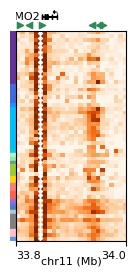

In [108]:
fig, ax = plt.subplots(3, 2, figsize=(1.5,3), height_ratios=[1, 1, 20], width_ratios=[1, 18])
fig.subplots_adjust(hspace=0, wspace=0)
ax_gene = ax[0, 1]
ax_ctcf = ax[1, 1]
ax_main = ax[2, 1]
ax[0, 0].axis('off')
ax[1, 0].axis('off')
ax_bar = ax[2, 0]

for i, sample in enumerate(samples_tilemap):
    color = GROUP_COLORS[sample.meta.group]
    rect = matplotlib.patches.Rectangle((0, i), 1, 1, color=color)
    ax_bar.add_patch(rect)
ax_bar.set_ylim(0, len(samples_tilemap))
ax_bar.invert_yaxis()
blank_axis(ax_bar)

plot_gene_track(loop_regionX, gene_filter=["LMO2"], ax=ax_gene, all_same_line=True)
plot_ctcf_track(CTCF_BEDFILE, loop_regionX, ax=ax_ctcf)
ax_main.imshow(np.vstack(all_virtual_data), vmin=0, vmax=1, cmap="Oranges", aspect="auto", 
               extent=[loop_regionX.start, loop_regionX.end, -0.5, len(samples) - 0.5])

xmin, xmax = ax_main.get_xlim()
ymin, ymax = ax_main.get_ylim()
ax_main.set_xticks([xmin, xmax], [f"{loop_regionX.start/1e6:.1f}", f"{loop_regionX.end/1e6:.1f}"], fontsize=8)
ax_main.get_xticklabels()[0].set_ha("left")
ax_main.get_xticklabels()[-1].set_ha("right")
ax_main.set_xlabel(loop_regionX.chrom + " (Mb)", fontsize=8, va="bottom")

for i in range(len(samples_tilemap)):
    ax_main.scatter([loop_anchor.pos + resolution /2], [i], marker="D", c="white", s=4)

ax_main.set_ylim((ymin, ymax))
ax_main.set_yticks([])
fig.savefig(figure_path("fig1_temp_loop_roi.svg"), bbox_inches="tight")

# Composite Hi-C at LMO2

In [120]:
dlbcl_samples = []
plasmacytoma_samples = []

for sample in samples:
    if sample.meta.group == "DLBCL":
        if sample.meta.id_paper not in {"DL04"}: # exclude non-GCB:
            dlbcl_samples.append(sample)
    elif sample.meta.group == "PCN":
        plasmacytoma_samples.append(sample)

assert(len(dlbcl_samples) == 10)
assert(len(plasmacytoma_samples) == 14)

averaged_dlbcl = []
averaged_plasmacytoma = []
resolution = 5000

region = GenomicRegion("chr11", 33710000, 34110000).get_bin_aligned(resolution=resolution)

# Weight by UVP - rescale to matrix max and re-weight by UVP
def rescale(mat):
    return (mat - mat.min()) / (mat.max() - mat.min())

for samples_group, averaged in zip([dlbcl_samples, plasmacytoma_samples], [averaged_dlbcl, averaged_plasmacytoma]):
    for sample in samples_group:
        sample_arima = sample.to_arima()
        
        try:
            hic_data = sample_arima.get_hic_region_data(region, region, resolution=resolution, normalization=HIC_NORM)
        except: # unconverged scale normalization, use backup norm
            hic_data = sample_arima.get_hic_region_data(region, region, resolution=resolution, normalization=HIC_NORM_BACKUP)
        
        hic_data = np.nan_to_num(hic_data)
        
        # Rescale between 0 and 1
        if hic_data.max() > hic_data.min():
            hic_data = rescale(hic_data)
        
        # Weight by uvp
        hic_data = hic_data * sample.uvp
        
        averaged.append(hic_data)
    
averaged_dlbcl = rescale(np.mean(np.stack(averaged_dlbcl, axis=2), axis=2))
averaged_plasmacytoma = rescale(np.mean(np.stack(averaged_plasmacytoma, axis=2), axis=2))

merged_hic = np.triu(averaged_plasmacytoma, k=1) + np.tril(averaged_dlbcl)

File did not contain SCALE normalization vectors for one or both chromosomes at 5000 BP


In [141]:
ctcf_pos = []
ctcf_neg = []
ctcf_bed = pd.read_csv("../annotations/CTCF/CTCF_motifs_STORM_hg38.bed", names=["chr", "start", "end", "direction"], sep=r"\s+")
for i, row in ctcf_bed[ctcf_bed.chr == region.chrom].iterrows():
    if GenomicRegion(row.chr, row.start, row.end).overlaps(region):
        if row.direction == "+":
            ctcf_pos.append((row.start + row.end) / 2)
        elif row.direction == "-":
            ctcf_neg.append((row.start + row.end) / 2)

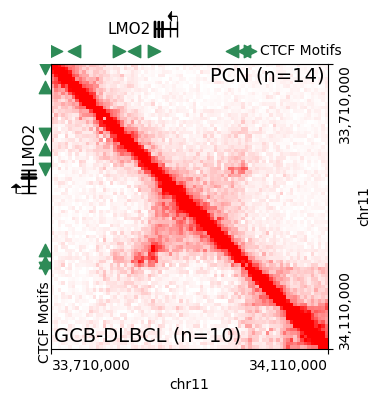

In [144]:
fig, axes = plt.subplots(3, 3, height_ratios=[1, 0.5,  10], width_ratios=[1, 0.5,  10], figsize=(4.1, 4.4))
fig.subplots_adjust(wspace=0, hspace=0.05)

ax = axes[2, 2]
ax_gene_top = axes[0, 2]
ax_gene_left = axes[2, 0]
ax_ctcf_top = axes[1, 2]
ax_ctcf_left = axes[2,1]

axes[0,0].set_visible(False)
axes[0,1].set_visible(False)
axes[1,0].set_visible(False)
axes[1,1].set_visible(False)

ax.imshow(merged_hic, cmap=REDMAP, vmax=0.25, extent=[region.start, region.end, region.end, region.start], aspect="auto")
ax.text(0.01, 0.01, f"GCB-DLBCL (n={len(dlbcl_samples)})", transform=ax.transAxes, ha="left", va="bottom", fontsize=14)
ax.text(0.99, 0.99, f"PCN (n={len(plasmacytoma_samples)})", transform=ax.transAxes, ha="right", va="top", fontsize=14)
ax.set_yticks([region.start, region.end], [f"{region.start:,}", f"{region.end:,}"], rotation=90)
ax.yaxis.tick_right()
ax.set_xticks([region.start, region.end], [f"{region.start:,}", f"{region.end:,}"])
ax.get_xticklabels()[0].set_ha("left")
ax.get_xticklabels()[-1].set_ha("right")
ax.get_yticklabels()[0].set_va("top")
ax.get_yticklabels()[-1].set_va("bottom")
ax.set_xlabel(region.chrom)
ax.set_ylabel(region.chrom)
ax.yaxis.set_label_position("right")

plot_gene_track(region, gene_filter = ["LMO2"], ax=ax_gene_top, min_rows=0, max_rows=1, fontsize=11, arrowhead_width=0.25)
plot_gene_track(region, gene_filter = ["LMO2"], ax=ax_gene_left, vertical=True, min_rows=0, max_rows=1, fontsize=11, arrowhead_width=0.25)

ax_ctcf_top.scatter(ctcf_pos, [0] * len(ctcf_pos),  marker=">", color=CTCF_COLOUR, s=80)
ax_ctcf_top.scatter(ctcf_neg, [0] * len(ctcf_neg),  marker="<", color=CTCF_COLOUR, s=80)
ax_ctcf_top.set_xlim(region.start, region.end)
ax_ctcf_top.text(1.05, 0.5, "CTCF Motifs", ha="right", va="center", transform=ax_ctcf_top.transAxes)
blank_axis(ax_ctcf_top)

ax_ctcf_left.scatter([0] * len(ctcf_pos), ctcf_pos, marker="v", color=CTCF_COLOUR, s=80)
ax_ctcf_left.scatter([0] * len(ctcf_neg), ctcf_neg, marker="^", color=CTCF_COLOUR, s=80)
ax_ctcf_left.set_ylim(region.start, region.end)
ax_ctcf_left.invert_yaxis()
ax_ctcf_left.text(0.5, -0.05, "CTCF Motifs", rotation=90, ha="center", va="bottom", transform=ax_ctcf_left.transAxes)
blank_axis(ax_ctcf_left)

fig.savefig(figure_path("LMO2_loop.svg"), bbox_inches="tight")

# Compartment PCA

In [145]:
from sklearn.decomposition import PCA

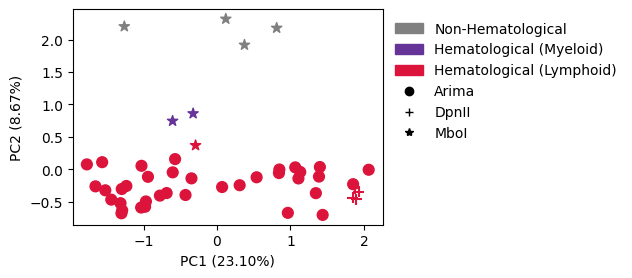

In [151]:
COMPARTMENT_REGIONS_100kb = pd.read_csv("../annotations/compartment_regions_100kb_blacklisted.csv", sep=",", header=0)
compartment_subset_indices = np.array((COMPARTMENT_REGIONS_100kb["blacklisted"] == False).to_list())

def plot_pca(samples: list[Sample]):
    all_compartments = np.array([read_compartments(s.profile.compartments) for s in samples])
    
    colors = [ "grey" if s.meta.group in {"HMEC", "HUVEC", "IMR90", "NHEK"} else "rebeccapurple" if s.meta.group in {"K562", "KBM7"} else "crimson"  for s in samples]
    
    markers = [ m if (m := s.meta.id_paper[0]) in {"*", "^", "+"} else "o"  for s in samples ]
    sizes = [ 100 * min(1, s.uvp / 100000000) for s in samples]
    pca = PCA(n_components=2)
    pca.fit(all_compartments)
    compartments_pca = pca.transform(all_compartments)
    
    fig, ax = plt.subplots(1, 1, figsize=(4.0, 2.8))
    for marker in ["o", "^", "+", "*"]:
        sub_indices = [ i for i, m in enumerate(markers) if m == marker ]
        sub_colors = [c for i, c in enumerate(colors) if i in sub_indices ]
        sub_sizes = [a for i, a in enumerate(sizes) if i in sub_indices ]
        ax.scatter(compartments_pca[sub_indices, 0], compartments_pca[sub_indices, 1], c=sub_colors, marker=marker, s=60)
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")

    legend_handles = []
    legend_labels = []
    for group, color in [("Non-Hematological", "grey"), ("Hematological (Myeloid)", "rebeccapurple"), ("Hematological (Lymphoid)", "crimson")]:
        legend_handles.append(matplotlib.patches.Patch(color=color))
        legend_labels.append(group)
    for (marker, label) in (("o", "Arima"), ("+", "DpnII"), ("*", "MboI")):
        legend_handles.append(matplotlib.lines.Line2D([],[], linestyle="None", marker=marker, color="black"))
        legend_labels.append(label)

    ax.legend(handles=legend_handles, labels=legend_labels, loc="upper left", bbox_to_anchor=(1,1), frameon=False)

    return fig

# Samples with sufficient quality
fig = plot_pca([s for s in samples_all_merge if s.uvp > 10000000])

fig.savefig(figure_path("compartment_PCA.svg"), bbox_inches="tight")

## Compartments at Loci

In [153]:
samples_compartments = samples_all_merge
all_compartments_full = np.array([read_compartments(s.profile.compartments) for s in samples_compartments])

def plot_compartments(samples, chr, bin_start, radius=10*100000, gene_filter=None, figsize=(2.8, 5.4), bw_pair=BW_KARPAS_DLBCL, start=None, end=None, gene_track_height=3, bigwig_track_height=4):
    bw_name, bw_filepath = bw_pair
    fig = plt.figure(figsize=figsize)
    resolution = 100000
    
    nrows = 3+len(samples)
    gs = fig.add_gridspec(nrows, 4, width_ratios=[0.5, 12, 0.2, 0.5], height_ratios = [gene_track_height,bigwig_track_height, 0.3]+[1]*len(samples))
    fig.subplots_adjust(wspace=0.02, hspace=0)

    if start is not None and end is not None and bin_start is None:
        pass
    else:
        start = (bin_start - radius) // resolution * resolution
        end = (bin_start + radius) // resolution * resolution
        if start < 0 or end > CHROM_SIZES[chr]:
            raise ValueError("Plot will be incorrect: out of bounds")

    ax_gene = fig.add_subplot(gs[0, 1])
    max_rows = 1 if gene_filter is not None else 6
    min_rows = 1 if gene_filter is not None else 2
    plot_gene_track(GenomicRegion(chr, start, end), ax=ax_gene, gene_filter=gene_filter, max_rows=max_rows, min_rows=min_rows, arrowhead_width=0.2, arrowhead_length=(end-start)/60, arrow_length=(end-start)/60, fontsize=10)

    ax_bigwig = fig.add_subplot(gs[1, 1])
    bw = pyBigWig.open(bw_filepath)
    bigwig_max = 20
    plot_bigwig_track(bw, GenomicRegion(chr, start, end), ax=ax_bigwig, color=BIGWIG_COLOUR, ymax=bigwig_max)
    ax_bigwig.yaxis.set_visible(True)
    ax_bigwig.set_ylim((0, bigwig_max))
    ax_bigwig.set_yticks([0, int(bigwig_max)], [0, int(bigwig_max)])
    ax_bigwig.yaxis.tick_right()
    ax_bigwig.get_yticklabels()[0].set_va("bottom")
    ax_bigwig.spines[["right"]].set_visible(True)
    ax_bigwig.spines[["left"]].set_visible(False)
    ax_bigwig.set_ylabel(f"H3K27ac\n({bw_name})", rotation=0, ha="left", va="center", fontsize=8)
    print("Bigwig track ylim: ", ax_bigwig.get_ylim())

    ax_spacer = fig.add_subplot(gs[2, :])
    blank_axis(ax_spacer)
    
    subset_chr = COMPARTMENT_REGIONS_100kb[(COMPARTMENT_REGIONS_100kb.chr == chr)]
    subset_start = subset_chr[subset_chr.start == start].index[0]
    subset_end = subset_chr[subset_chr.start == end].index[0]
    vmin = -0.05
    vmax = 0.05
    symm = max(abs(vmin), abs(vmax))
    vmin = -symm
    vmax = symm
    

    for i, sample in enumerate(samples):
        row = 3+i
        ax_tile = fig.add_subplot(gs[row, 0])
        ax_comp = fig.add_subplot(gs[row, 1])
        ax_space = fig.add_subplot(gs[row, 2])
        blank_axis(ax_space)
        blank_axis(ax_tile)

        rect = matplotlib.patches.Rectangle((0, 0), 1, 1, color=GROUP_COLORS[sample.meta.group])
        ax_tile.add_patch(rect)
        ax_tile.set_xlim((0, 1))
        ax_tile.set_ylim((0, 1))

        comp_array = all_compartments_full[i, subset_start:subset_end]
        im = ax_comp.matshow(np.expand_dims(comp_array, axis=0), aspect="auto", extent=(start, end, 0, 1), cmap="seismic", vmin=vmin, vmax=vmax)
        blank_axis(ax_comp)
        if i == 0:
            ax_comp.spines[["top"]].set_visible(True)
    ax_comp.set_xticks([start, end], [f"{start:,}", f"{end:,}"])
    ax_comp.set_xlabel(chr)
    ax_comp.spines[["bottom"]].set_visible(True)
    ax_comp.xaxis.tick_bottom()
    ax_comp.get_xticklabels()[0].set_horizontalalignment("left")
    ax_comp.get_xticklabels()[-1].set_horizontalalignment("right")

    cax = fig.add_subplot(gs[3:, 3])
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params(rotation=90)
    for tick in cax.yaxis.get_majorticklabels():
        tick.set_va("center")
    return fig

Bigwig track ylim:  (0.0, 20.0)


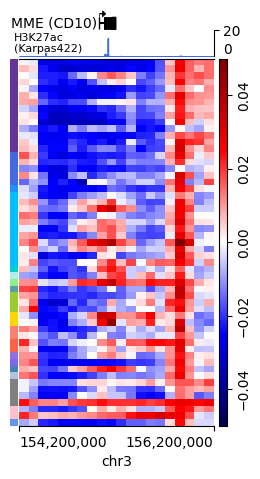

In [155]:
fig = plot_compartments(samples_compartments, "chr3", 155200000, gene_filter=["MME"])
gene_text = fig.axes[0].findobj(matplotlib.text.Text)[0]
gene_text.set_text("MME (CD10)")
gene_text.set_clip_on(False)
fig.savefig(figure_path("cohort_compartments_MME.svg"), bbox_inches="tight")

Bigwig track ylim:  (0.0, 20.0)


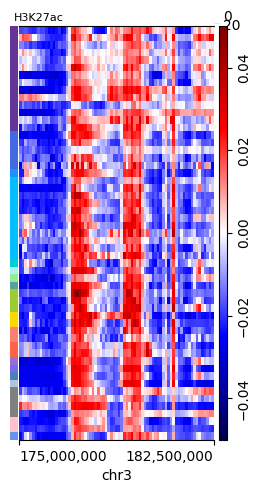

In [156]:
fig = plot_compartments(samples_compartments, "chr3", None, gene_filter=None, start=175000000, end=182500000, gene_track_height=0, bigwig_track_height=0)

fig.savefig(figure_path("cohort_compartments_similarity.svg"), bbox_inches="tight")

# CTCF Motif Enrichment

## Loop Anchors

In [157]:
sizes = []
for sample in samples:
    loops = read_loops(sample.profile.loops_hicexplorer)
    for loop in loops:
        size1 = loop.regionA.end - loop.regionA.start
        size2 = loop.regionB.end - loop.regionB.start
        sizes.append(size1)
        sizes.append(size2)
print(set(sizes))
    

{10000}


In [158]:
%%time
all_samples_loop_anchors_with_ctcf = {}
for sample in samples:
    loops = read_loops(sample.profile.loops_hicexplorer)
    all_anchors_with_ctcf = []
    for loop in loops:
        chrom = loop.regionA.chrom
        assert loop.regionB.chrom == chrom
        assert loop.regionA.start < loop.regionB.start
        assert (loop.regionA.end - loop.regionA.start) == (loop.regionB.end - loop.regionB.start)
        dfsub = CTCF_DF[(CTCF_DF.chr == chrom)]
        dfsub_a = dfsub[(dfsub.start >= loop.regionA.start) & (dfsub.end <= loop.regionA.end)]
        dfsub_b = dfsub[(dfsub.start >= loop.regionB.start) & (dfsub.end <= loop.regionB.end)]
        anchors_with_ctcf = 0
        pair_type = None
        if len(dfsub_a) > 0:
            anchors_with_ctcf += 1
            orientation_a_set = set(dfsub_a.direction)
            if len(orientation_a_set) > 1:
                pair_type = "ambiguous"
            orientation_a = list(orientation_a_set)[0]
        if len(dfsub_b) > 0:
            anchors_with_ctcf += 1
            orientation_b_set = set(dfsub_b.direction)
            if len(orientation_b_set) > 1:
                pair_type = "ambiguous"
            orientation_b = list(orientation_b_set)[0]
        if anchors_with_ctcf == 2 and pair_type is None:
            pair_type = "tandem" if orientation_a == orientation_b else "convergent" if orientation_a == "+" and orientation_b == "-" else "divergent" if orientation_a == "-" and orientation_b == "+" else "ERROR"
        all_anchors_with_ctcf.append((anchors_with_ctcf, pair_type))
    all_samples_loop_anchors_with_ctcf[sample.meta.id_paper] = all_anchors_with_ctcf
    print(sample.meta.id_paper, "done")

PL12 done
PL13 done
PL11 done
PL08 done
PL07 done
PL06 done
PL10 done
PL04 done
PL05 done
PL02 done
PL14 done
PL03 done
PL09 done
PL01 done
DC06 done
DC05 done
DC04 done
DC01 done
DC02 done
DC03 done
DL04 done
DL08 done
DL07 done
DL09 done
DL11 done
DL03 done
DL10 done
DL01 done
DL02 done
DL06 done
DL05 done
PM01 done
BN01 done
BL01 done
HL01 done
MC02 done
MC03 done
MC01 done
BA01 done
BA02 done
AL02 done
AL01 done
TA02 done
TA01 done
CPU times: user 2min 50s, sys: 3.03 ms, total: 2min 50s
Wall time: 2min 52s


In [85]:
import random

In [86]:
%%time
control_random_samples_loop_anchors_with_ctcf = {}
for sample in samples:
    loops = read_loops(sample.profile.loops_hicexplorer)
    all_anchors_with_ctcf = []
    for loop in loops:
        chrom = loop.regionA.chrom
        assert loop.regionB.chrom == chrom
        assert loop.regionA.start < loop.regionB.start
        assert (loop.regionA.end - loop.regionA.start) == (loop.regionB.end - loop.regionB.start)
        chrom_size = CHROM_SIZES[chrom]
        loop_size = loop.regionA.end - loop.regionA.start
        try:
            compartment_subset = COMPARTMENT_REGIONS_100kb[(COMPARTMENT_REGIONS_100kb.chr == chrom) & (COMPARTMENT_REGIONS_100kb.blacklisted == False)]
            random_comp = random.randint(0, len(compartment_subset)-1)
            start = compartment_subset.iloc[random_comp].start
            end = compartment_subset.iloc[random_comp]. end
        except:
            start = 0
            end = CHROM_SIZES[chrom]
        randomA_pos = random.randint(start+loop_size//2, end-loop_size//2)
        loopA_start = randomA_pos - loop_size//2
        loopA_end = randomA_pos + loop_size//2
        randomB_pos = random.randint(start+loop_size//2, end-loop_size//2)
        loopB_start = randomB_pos - loop_size//2
        loopB_end = randomB_pos + loop_size//2
        dfsub = CTCF_DF[(CTCF_DF.chr == chrom)]
        dfsub_a = dfsub[(dfsub.start >= loopA_start) & (dfsub.end <= loopA_end)]
        dfsub_b = dfsub[(dfsub.start >= loopB_start) & (dfsub.end <= loopB_end)]
        anchors_with_ctcf = 0
        pair_type = None
        if len(dfsub_a) > 0:
            anchors_with_ctcf += 1
            orientation_a_set = set(dfsub_a.direction)
            if len(orientation_a_set) > 1:
                pair_type = "ambiguous"
            orientation_a = list(orientation_a_set)[0]
        if len(dfsub_b) > 0:
            anchors_with_ctcf += 1
            orientation_b_set = set(dfsub_b.direction)
            if len(orientation_b_set) > 1:
                pair_type = "ambiguous"
            orientation_b = list(orientation_b_set)[0]
        if anchors_with_ctcf == 2 and pair_type is None:
            pair_type = "tandem" if orientation_a == orientation_b else "convergent" if orientation_a == "+" and orientation_b == "-" else "divergent" if orientation_a == "-" and orientation_b == "+" else "ERROR"
        all_anchors_with_ctcf.append((anchors_with_ctcf, pair_type))
    control_random_samples_loop_anchors_with_ctcf[sample.meta.id_paper] = all_anchors_with_ctcf
    print(sample.meta.id_paper, "done")

PL12 done
PL13 done
PL11 done
PL08 done
PL07 done
PL06 done
PL10 done
PL04 done
PL05 done
PL02 done
PL14 done
PL03 done
PL09 done
PL01 done
DC06 done
DC05 done
DC04 done
DC01 done
DC02 done
DC03 done
DL04 done
DL08 done
DL07 done
DL09 done
DL11 done
DL03 done
DL10 done
DL01 done
DL02 done
DL06 done
DL05 done
PM01 done
BN01 done
BL01 done
HL01 done
MC02 done
MC03 done
MC01 done
BA01 done
BA02 done
AL02 done
AL01 done
TA02 done
TA01 done
CPU times: user 6min 27s, sys: 196 ms, total: 6min 27s
Wall time: 6min 29s


In [112]:
for sample in samples:
    loops = read_loops(sample.profile.loops_hicexplorer)
    anchors = all_samples_loop_anchors_with_ctcf[sample.meta.id_paper]
    controls = control_random_samples_loop_anchors_with_ctcf[sample.meta.id_paper]
    
    assert len(loops) == len(anchors)
    assert len(loops) == len(controls)
    
    num_zero_anchor = len([a for a, _ in anchors if a == 0])
    num_one_anchor = len([a for a, _ in anchors if a == 1])
    num_two_anchor = len([a for a, _ in anchors if a == 2])
    num_two_anchor_convergent = len([a for a, b in anchors if a == 2 and b == "convergent"])
    num_two_anchor_tandem = len([a for a, b in anchors if a == 2 and b == "tandem"])
    num_two_anchor_divergent = len([a for a, b in anchors if a == 2 and b == "divergent"])
    num_two_anchor_ambiguous = len([a for a, b in anchors if a == 2 and b == "ambiguous"])
    control_zero_anchor = len([a for a, b in controls if a == 0])
    control_one_anchor = len([a for a, b in controls if a == 1])
    control_two_anchor = len([a for a, b in controls if a == 2])
    control_two_anchor_convergent = len([a for a, b in controls if a == 2 and b == "convergent"])
    control_two_anchor_tandem = len([a for a, b in controls if a == 2 and b == "tandem"])
    control_two_anchor_divergent = len([a for a, b in controls if a == 2 and b == "divergent"])
    control_two_anchor_ambiguous = len([a for a, b in controls if a == 2 and b == "ambiguous"])
    
    print(sample.meta.id_paper, len(loops), (1 - num_zero_anchor / len(loops)), num_zero_anchor, num_one_anchor, num_two_anchor, num_two_anchor_convergent, num_two_anchor_tandem, num_two_anchor_divergent, num_two_anchor_ambiguous,
          control_zero_anchor, control_one_anchor, control_two_anchor, control_two_anchor_convergent, control_two_anchor_tandem, control_two_anchor_divergent, control_two_anchor_ambiguous)

PL12 6660 0.6891891891891893 2070 1988 2602 2054 253 5 290 5743 815 102 8 82 10 2
PL13 5570 0.71508078994614 1587 1605 2378 1840 261 11 266 4757 718 95 12 67 13 3
PL11 3983 0.6675872457946272 1324 1305 1354 1070 134 6 144 3404 524 55 9 36 5 5
PL08 4375 0.6962285714285714 1329 1210 1836 1491 152 6 187 3747 557 71 8 50 7 6
PL07 4693 0.723204773066269 1299 1394 2000 1600 191 3 206 4041 570 82 7 57 11 7
PL06 4296 0.7346368715083799 1140 1377 1779 1374 181 10 214 3660 558 78 9 56 11 2
PL10 4583 0.6914684704342133 1414 1384 1785 1451 144 11 179 3953 553 77 12 54 5 6
PL04 2247 0.7650200267022698 528 723 996 812 79 2 103 1910 303 34 1 24 7 2
PL05 2948 0.771370420624152 674 936 1338 1061 123 6 148 2509 388 51 7 32 8 4
PL02 3210 0.7757009345794392 720 999 1491 1184 131 4 172 2770 382 58 9 41 5 3
PL14 1533 0.7964774951076321 312 474 747 604 52 1 90 1301 204 28 1 22 1 4
PL03 1243 0.7892196299275945 262 370 611 493 44 0 74 1062 168 13 3 8 0 2
PL09 2593 0.6089471654454299 1014 755 824 618 92 4 110 2

In [105]:
all_num_any_anchor = []
all_num_zero_anchor = []
all_num_one_anchor = []
all_num_two_anchor = []
all_num_two_anchor_convergent = []
all_num_two_anchor_tandem = []
all_num_two_anchor_divergent = []
all_num_two_anchor_multiple = []

all_control_zero_anchor = []
all_control_one_anchor = []
all_control_two_anchor = []
all_control_two_convergent = []
all_control_two_tandem = []
all_control_two_divergent = []
all_control_two_multiple = []

all_num_loops = []
labels = []
colors = []

for sample in samples:
    loops = read_loops(sample.profile.loops_hicexplorer)
    anchors = all_samples_loop_anchors_with_ctcf[sample.meta.id_paper]
    controls = control_random_samples_loop_anchors_with_ctcf[sample.meta.id_paper]
    
    assert len(loops) == len(anchors)
    assert len(loops) == len(controls)

    num_zero_anchor = len([a for a, _ in anchors if a == 0])
    num_one_anchor = len([a for a, _ in anchors if a == 1])
    num_two_anchor = len([a for a, _ in anchors if a == 2])
    num_two_anchor_convergent = len([a for a, b in anchors if a == 2 and b == "convergent"])
    num_two_anchor_tandem = len([a for a, b in anchors if a == 2 and b == "tandem"])
    num_two_anchor_divergent = len([a for a, b in anchors if a == 2 and b == "divergent"])
    num_two_anchor_ambiguous = len([a for a, b in anchors if a == 2 and b == "ambiguous"])
    control_zero_anchor = len([a for a, b in controls if a == 0])
    control_one_anchor = len([a for a, b in controls if a == 1])
    control_two_anchor = len([a for a, b in controls if a == 2])
    control_two_anchor_convergent = len([a for a, b in controls if a == 2 and b == "convergent"])
    control_two_anchor_tandem = len([a for a, b in controls if a == 2 and b == "tandem"])
    control_two_anchor_divergent = len([a for a, b in controls if a == 2 and b == "divergent"])
    control_two_anchor_ambiguous = len([a for a, b in controls if a == 2 and b == "ambiguous"])
    
    num_any_anchor = num_one_anchor + num_two_anchor

    all_num_loops.append(len(loops))
    all_num_any_anchor.append(num_any_anchor)
    all_num_zero_anchor.append(num_zero_anchor)
    all_num_one_anchor.append(num_one_anchor)
    all_num_two_anchor.append(num_two_anchor)
    all_num_two_anchor_convergent.append(num_two_anchor_convergent)
    all_num_two_anchor_tandem.append(num_two_anchor_tandem)
    all_num_two_anchor_divergent.append(num_two_anchor_divergent)
    all_num_two_anchor_multiple.append(num_two_anchor_ambiguous)
    
    all_control_zero_anchor.append(control_zero_anchor)
    all_control_one_anchor.append(control_one_anchor)
    all_control_two_anchor.append(control_two_anchor)
    all_control_two_convergent.append(control_two_anchor_convergent)
    all_control_two_tandem.append(control_two_anchor_tandem)
    all_control_two_divergent.append(control_two_anchor_divergent)
    all_control_two_multiple.append(control_two_anchor_ambiguous)
    
    labels.append(sample.meta.id_paper)
    colors.append(GROUP_COLORS[sample.meta.group])


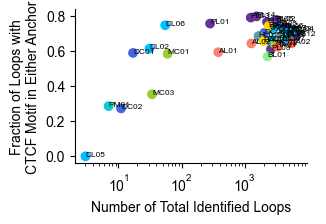

In [93]:
fig, ax = plt.subplots(figsize=(3,2))

ys = [a / b for a, b in zip(all_num_any_anchor, all_num_loops)]
ax.scatter(all_num_loops, ys, c=colors)

for (x, y, label) in zip(all_num_loops, ys, labels):
    ax.text(x, y, label, fontsize=6)
# ax.set_aspect("equal", adjustable="box")
# ax.plot([0, 6000], [0, 6000], linestyle=":", color="gray")
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlabel("Number of Total Identified Loops")
ax.set_ylabel("Fraction of Loops with\nCTCF Motif in Either Anchor")


ax.set_xscale("log")
fig.savefig(figure_path("supp1_ctcf_fraction_scatter.svg"), bbox_inches="tight")

/tmp/ipykernel_2189677/3613744500.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90, fontsize=8)


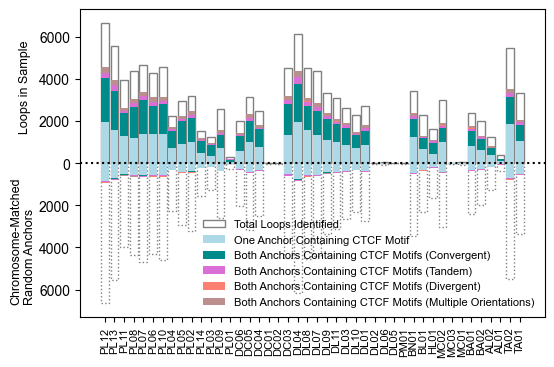

In [111]:
fig, ax = plt.subplots(figsize=(6,4))

ax.bar(labels, all_num_loops, ec="gray", fc="none", label="Total Loops Identified")

ax.bar(labels, all_num_one_anchor, fc="lightblue", label="One Anchor Containing CTCF Motif")
bottom = np.array(all_num_one_anchor)

# ax.bar(labels, all_num_two_anchor, fc="dodgerblue", bottom=all_num_one_anchor, label="Both Anchors Containing CTCF Motif")
ax.bar(labels, all_num_two_anchor_convergent, fc="darkcyan", bottom=bottom, label="Both Anchors Containing CTCF Motifs (Convergent)")
bottom += np.array(all_num_two_anchor_convergent)
ax.bar(labels, all_num_two_anchor_tandem, fc="orchid", bottom=bottom, label="Both Anchors Containing CTCF Motifs (Tandem)")
bottom += np.array(all_num_two_anchor_tandem)
ax.bar(labels, all_num_two_anchor_divergent, fc="salmon", bottom=bottom, label="Both Anchors Containing CTCF Motifs (Divergent)")
bottom += np.array(all_num_two_anchor_divergent)
ax.bar(labels, all_num_two_anchor_multiple, fc="rosybrown", bottom=bottom, label="Both Anchors Containing CTCF Motifs (Multiple Orientations)")

ax.bar(labels, [x*-1 for x in all_num_loops], ec="gray", fc="none", ls="dotted")
ax.bar(labels, [x*-1 for x in all_control_one_anchor], fc="lightblue")
bottom = np.array([x*-1 for x in all_control_one_anchor])

# ax.bar(labels, [x*-1 for x in all_control_two_anchor], fc="dodgerblue", bottom=[x*-1 for x in all_control_one_anchor])
ax.bar(labels, -1*np.array(all_control_two_convergent), fc="darkcyan", bottom=bottom)
bottom -= np.array(all_control_two_convergent)
ax.bar(labels, -1*np.array(all_control_two_tandem), fc="orchid", bottom=bottom)
bottom -= np.array(all_control_two_tandem)
ax.bar(labels, -1*np.array(all_control_two_divergent), fc="salmon", bottom=bottom)
bottom -= np.array(all_control_two_divergent)
ax.bar(labels, -1*np.array(all_control_two_multiple), fc="rosybrown", bottom=bottom)
bottom -= np.array(all_control_two_multiple)


yticks = list(range(-6000, 8000, 2000))
ax.set_yticks(yticks, [abs(t) for t in yticks])

ax.text(-0.13, 0.75, "Loops in Sample", rotation=90, ha="left", va="center", transform=ax.transAxes, fontsize=9)
ax.text(-0.15, 0.25, "Chromosome-Matched\nRandom Anchors", rotation=90, ha="left", va="center", transform=ax.transAxes, fontsize=9)

ax.set_xticklabels(labels, rotation=90, fontsize=8)
ax.axhline(0, ls=":", color="black")
ax.legend(bbox_to_anchor=(1,0), loc="lower right", fontsize=8, frameon=False)


fig.savefig(figure_path("supp1_ctcf_motif_stacked_bar.svg"), bbox_inches="tight")

## TAD Boundaries Anchors

In [194]:
%%time
resolution = 25000
all_samples_tad_boundaries_with_ctcf = {}
all_samples_tad_control_with_ctcf = {}
for sample in samples:
    all_tads = read_tads(sample.profile.tads, hierarchy_filter=0)
    tad_boundary_set = set()
    for tad in all_tads:
        tad_boundary_set.add((tad.chrom, tad.start))
        tad_boundary_set.add((tad.chrom, tad.end))
    num_boundaries_with_ctcf = 0
    num_control_with_ctcf =0 
    for boundary in tad_boundary_set:
        chrom = boundary[0]
        pos = boundary[1]
        dfsub = CTCF_DF[(CTCF_DF.chr == chrom)]
        dfsub_test = dfsub[(dfsub.start >= pos-resolution) & (dfsub.end <= pos+resolution)]
        if len(dfsub_test) > 0:
            num_boundaries_with_ctcf+= 1

        # Control
        try:
            compartment_subset = COMPARTMENT_REGIONS_100kb[(COMPARTMENT_REGIONS_100kb.chr == chrom) & (COMPARTMENT_REGIONS_100kb.blacklisted == False)]
            random_comp = random.randint(0, len(compartment_subset)-1)
            start = compartment_subset.iloc[random_comp].start
            end = compartment_subset.iloc[random_comp]. end
        except:
            start = 0
            end = CHROM_SIZES[chrom]
        random_pos = random.randint(start+resolution//2, end-resolution//2)
        dfsub_control = dfsub[(dfsub.start >= random_pos-resolution) & (dfsub.end <= random_pos+resolution)]
        if len(dfsub_control) > 0:
            num_control_with_ctcf+= 1
    all_samples_tad_boundaries_with_ctcf[sample.meta.id_paper] = num_boundaries_with_ctcf
    all_samples_tad_control_with_ctcf[sample.meta.id_paper] = num_control_with_ctcf
    print(sample.meta.id_paper, "done")

PL12 done
PL13 done
PL11 done
PL08 done
PL07 done
PL06 done
PL10 done
PL04 done
PL05 done
PL02 done
PL14 done
PL03 done
PL09 done
PL01 done
DC06 done
DC05 done
DC04 done
DC01 done
DC02 done
DC03 done
DL04 done
DL08 done
DL07 done
DL09 done
DL11 done
DL03 done
DL10 done
DL01 done
DL02 done
DL06 done
DL05 done
PM01 done
BN01 done
BL01 done
HL01 done
MC02 done
MC03 done
MC01 done
BA01 done
BA02 done
AL02 done
AL01 done
TA02 done
TA01 done
CPU times: user 12min 2s, sys: 250 ms, total: 12min 2s
Wall time: 12min 6s


In [195]:
for sample in samples:
    num_boundaries = len(read_tads(sample.profile.tads, hierarchy_filter=0))
    num_boundaries_with_ctcf = all_samples_tad_boundaries_with_ctcf[sample.meta.id_paper]
    num_control_with_ctcf = all_samples_tad_control_with_ctcf[sample.meta.id_paper]
    print(sample.meta.id_paper, num_boundaries, num_boundaries_with_ctcf, num_control_with_ctcf)

PL12 4798 2972 1487
PL13 4058 2658 1286
PL11 4770 3060 1514
PL08 5050 2754 1519
PL07 4769 2923 1521
PL06 4129 2604 1341
PL10 4713 2820 1455
PL04 4949 3103 1571
PL05 3740 2480 1172
PL02 4469 2804 1345
PL14 4746 2857 1493
PL03 4801 3093 1507
PL09 4931 3283 1532
PL01 5572 3380 1732
DC06 3819 2462 1258
DC05 4396 2936 1429
DC04 4773 3254 1487
DC01 6253 3348 2010
DC02 6304 3531 1942
DC03 4239 3069 1290
DL04 4446 3002 1455
DL08 4742 3032 1480
DL07 3846 2638 1179
DL09 4150 2901 1274
DL11 4577 3189 1438
DL03 5018 3396 1648
DL10 4297 2884 1316
DL01 5440 3258 1647
DL02 6014 3093 1899
DL06 6015 3226 1867
DL05 5119 2576 1592
PM01 5763 3158 1772
BN01 4097 2670 1334
BL01 4755 2941 1478
HL01 4468 2991 1408
MC02 3632 2481 1179
MC03 5759 2969 1779
MC01 5832 2751 1776
BA01 4516 3061 1474
BA02 4357 2940 1334
AL02 5400 3042 1696
AL01 5333 3221 1654
TA02 4241 2789 1320
TA01 4279 2843 1343


In [196]:
all_num_tad_boundaries = [all_samples_tad_boundaries_with_ctcf[s.meta.id_paper] for s in samples]
all_controls = [-all_samples_tad_control_with_ctcf[s.meta.id_paper] for s in samples]
all_frac_tad_boundaries = [all_samples_tad_boundaries_with_ctcf[s.meta.id_paper] / 
                          len(read_tads(s.profile.tads, hierarchy_filter=0)) for s in samples]
all_frac_controls = [- all_samples_tad_control_with_ctcf[s.meta.id_paper] / 
                          len(read_tads(s.profile.tads, hierarchy_filter=0)) for s in samples]
tad_colors = [GROUP_COLORS[s.meta.group] for s in samples]
xpos = list(range(len(samples)))
labels = [s.meta.id_paper for s in samples]

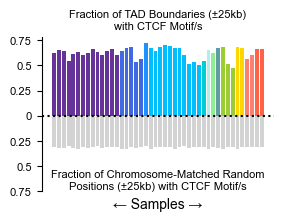

In [213]:
fig, ax = plt.subplots(figsize=(3,2))

# ax.scatter(all_num_tad_boundaries, all_frac_tad_boundaries, c=tad_colors)
ax.bar(xpos, all_frac_tad_boundaries, color=tad_colors)
ax.bar(xpos, all_frac_controls, color="lightgray")
# ax.set_aspect("equal", adjustable="box")
# ax.plot([0, 6000], [0, 6000], linestyle=":", color="gray")
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlabel("← Samples →")
ax.set_ylabel("")
ax.set_title("Fraction of TAD Boundaries (±25kb)\nwith CTCF Motif/s", fontsize=8)

ax.axhline(0, color="black", ls=":")
ax.spines[["bottom"]].set_visible(False)

yticks = [-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75]
ax.set_yticks(yticks, [abs(t) for t in yticks], fontsize=8)

ax.set_xticks([])
ax.text(0.5, 0, "Fraction of Chromosome-Matched Random\nPositions (±25kb) with CTCF Motif/s", rotation=0, ha="center", va="bottom", transform=ax.transAxes, fontsize=8)
# ax.set_xlabel("Fraction of Chromosome-Matched Random\nPositions (±25kb) with CTCF Motif/s", fontsize=8)


# ax.set_xscale("log")
fig.savefig(figure_path("ctcf_tad_fraction_scatter.svg"), bbox_inches="tight")

# Matrix Plots

### DL03

[chr18:63320000>::[chr22:22905000>


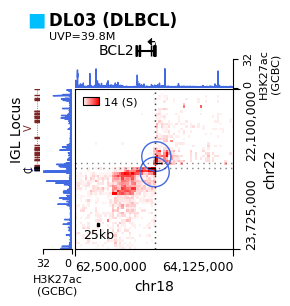

In [55]:
sample_id = "DL03"
chromA = "chr18"
chromB = "chr22"
gene_filter = ["BCL2"]
promoter = GENE_ANNOTATIONS.genes_by_name("BCL2")[0].end
resolution = 25000
radius = 800000
neoloop_region_filter = GenomicRegion("chr18", promoter-resolution, promoter+resolution)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]

bpoint = [bp for bp in arima_sample.breakpoints if bp.breakendA.chrom == chromA and bp.breakendB.chrom == chromB]
bpoint = bpoint[1]
print(bpoint)

regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter, vmax=14,
    show_neoloops=True, show_uvp=True,
    neoloop_region_filter=neoloop_region_filter,
    figsize=(2.75, 2.75),
)

fig.savefig(figure_path(f"{sample_id}_{bpoint.breakendA.chrom}_{bpoint.breakendB.chrom}_matrix.svg"), bbox_inches="tight")

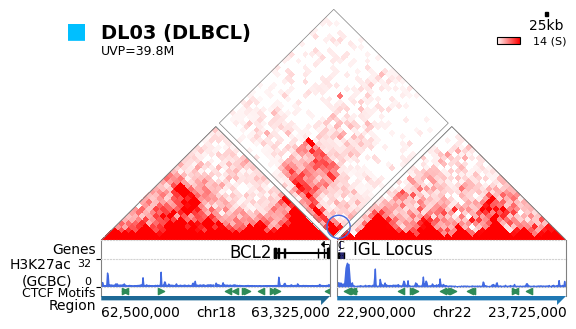

In [56]:
regionLeft, regionRight = bpoint.get_reconstructed_regions_with_radius(radius)
regionLeft = regionLeft.get_bin_aligned(resolution)
regionRight = regionRight.get_bin_aligned(resolution)

assembly = [regionLeft, regionRight]

fig = plot_standard_triangle_plot(
    arima_sample, assembly, resolution,
    gene_filter=gene_filter, gap_size=1,
    show_uvp=True, show_neoloops=True,
    show_bw1_track=True,
    bw1_pair=bw_tuple,
    vmax=14,
    neoloop_filter=neoloop_region_filter,
    
)

fig.savefig(figure_path(f"{sample_id}_{bpoint.breakendA.chrom}_{bpoint.breakendB.chrom}_triangle.svg"), bbox_inches="tight")

## PL08

<chr12:4150000]::<chr14:105860000]


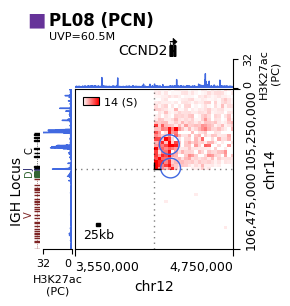

In [57]:
sample_id = "PL08"
chromA = "chr12"
chromB = "chr14"
gene_filter = ["CCND2"]
goi = GENE_ANNOTATIONS.genes_by_name("CCND2")[0]
promoter = goi.start
resolution = 25000
radius = 600000
neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), promoter-resolution, promoter+resolution)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]

bpoint = [bp for bp in arima_sample.breakpoints if bp.breakendA.chrom == chromA and bp.breakendB.chrom == chromB]
bpoint = bpoint[0]
print(bpoint)

regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter, vmax=14,
    show_neoloops=True, show_uvp=True,
    neoloop_region_filter=neoloop_region_filter,
    figsize=(2.75, 2.75),
    neoloop_radius=resolution*3
)

fig.savefig(figure_path(f"{sample_id}_{bpoint.breakendA.chrom}_{bpoint.breakendB.chrom}.svg"), bbox_inches="tight")

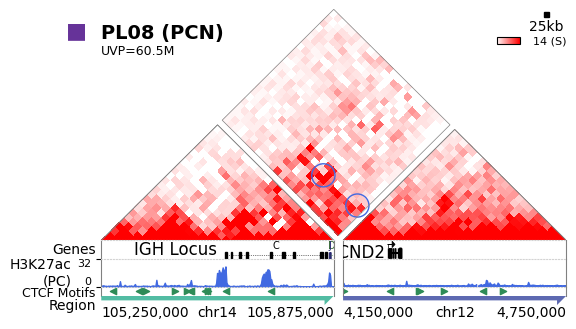

In [58]:
bpoint.breakendA, bpoint.breakendB = bpoint.breakendB, bpoint.breakendA
regionLeft, regionRight = bpoint.get_reconstructed_regions_with_radius(radius)
regionLeft = regionLeft.get_bin_aligned(resolution)
regionRight = regionRight.get_bin_aligned(resolution)

assembly = [regionLeft, regionRight]

fig = plot_standard_triangle_plot(
    arima_sample, assembly, resolution,
    gene_filter=gene_filter, gap_size=1,
    show_uvp=True, show_neoloops=True,
    show_bw1_track=True,
    bw1_pair=bw_tuple,
    vmax=14,
    neoloop_filter=neoloop_region_filter,
    
)


fig.savefig(figure_path(f"{sample_id}_{bpoint.breakendA.chrom}_{bpoint.breakendB.chrom}_triangle.svg"), bbox_inches="tight")

## PL07

[chr14:105740000>::[chr20:40190000>


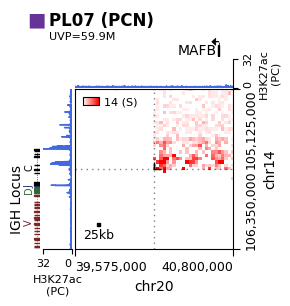

In [59]:
sample_id = "PL07"
chromA = "chr14"
chromB = "chr20"
gene_filter = ["MAFB"]
goi = GENE_ANNOTATIONS.genes_by_name("MAFB")[0]
promoter = goi.end
resolution = 25000
radius = 600000
neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), promoter-resolution, promoter+resolution)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]

bpoint = [bp for bp in arima_sample.breakpoints if bp.breakendA.chrom == chromA and bp.breakendB.chrom == chromB]
bpoint = bpoint[0]
print(bpoint)

regionY, regionX = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter, vmax=14,
    show_neoloops=True, show_uvp=True,
    neoloop_region_filter=neoloop_region_filter,
    figsize=(2.75, 2.75),
    neoloop_radius=resolution*3
)

fig.savefig(figure_path(f"{sample_id}_{bpoint.breakendA.chrom}_{bpoint.breakendB.chrom}.svg"), bbox_inches="tight")

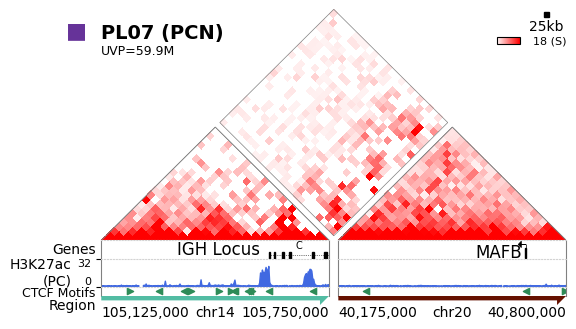

In [60]:
regionLeft, regionRight = bpoint.get_reconstructed_regions_with_radius(radius)
regionLeft = regionLeft.get_bin_aligned(resolution)
regionRight = regionRight.get_bin_aligned(resolution)

assembly = [regionLeft, regionRight]

fig = plot_standard_triangle_plot(
    arima_sample, assembly, resolution,
    gene_filter=gene_filter, gap_size=1,
    show_uvp=True, show_neoloops=True,
    show_bw1_track=True,
    bw1_pair=bw_tuple,
    vmax=18,
    neoloop_filter=neoloop_region_filter,
    
)


fig.savefig(figure_path(f"{sample_id}_{bpoint.breakendA.chrom}_{bpoint.breakendB.chrom}_triangle.svg"), bbox_inches="tight")

## PL13

[chr14:105859000>::[chr16:79171000>


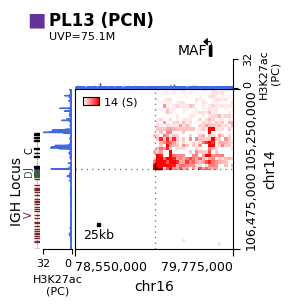

In [61]:
sample_id = "PL13"
chromA = "chr14"
chromB = "chr16"
gene_filter = ["MAF"]
goi = GENE_ANNOTATIONS.genes_by_name("MAF")[0]
promoter = goi.end
resolution = 25000
radius = 600000
neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), promoter-resolution, promoter+resolution)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]

bpoint = [bp for bp in arima_sample.breakpoints if bp.breakendA.chrom == chromA and bp.breakendB.chrom == chromB]
bpoint = bpoint[0]
# bpoint.breakendA, bpoint.breakendA = bpoint.breakendB, bpoint.breakendA
print(bpoint)

regionY, regionX = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter, vmax=14,
    show_neoloops=True, show_uvp=True,
    neoloop_region_filter=neoloop_region_filter,
    figsize=(2.75, 2.75),
    neoloop_radius=resolution*3
)

fig.savefig(figure_path(f"{sample_id}_{bpoint.breakendA.chrom}_{bpoint.breakendB.chrom}.svg"), bbox_inches="tight")

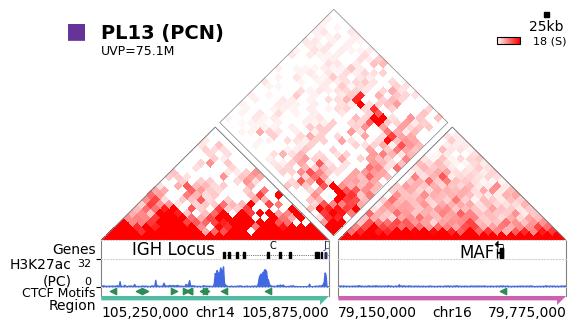

In [65]:
regionLeft, regionRight = bpoint.get_reconstructed_regions_with_radius(radius)
regionLeft = regionLeft.get_bin_aligned(resolution)
regionRight = regionRight.get_bin_aligned(resolution)

assembly = [regionLeft, regionRight]

fig = plot_standard_triangle_plot(
    arima_sample, assembly, resolution,
    gene_filter=gene_filter, gap_size=1,
    show_uvp=True, show_neoloops=True,
    show_bw1_track=True,
    bw1_pair=bw_tuple,
    vmax=18,
    neoloop_filter=neoloop_region_filter,
    
)


fig.savefig(figure_path(f"{sample_id}_{bpoint.breakendA.chrom}_{bpoint.breakendB.chrom}_triangle.svg"), bbox_inches="tight")

# BCL6 Case with FISH

In [66]:
bcl6_prom_start = 187745725 - 7500
bcl6_prom_end = 187745725 + 7500
enhancer_start = 187745725 +150000
enhancer_end = 187745725 +260000

se2_start = 187745725 + 340000
se2_end = se2_start+40000

se3_start = 187745725 + 480000
se3_end = se3_start+15000

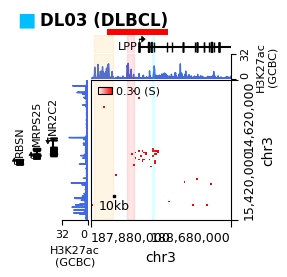

In [67]:
arima_sample = [s for s in arima_samples if s.id == "DL03"][0]
sample = [s for s in samples if s.meta.id_paper == "DL03"][0]

chr_search = "chr3"
pos_search = 15020000
breakpoints = arima_sample.breakpoints
bpoint = [bpoint for bpoint in breakpoints if bpoint.breakendA.chrom == chr_search and bpoint.breakendA.pos == pos_search][0]
gene_filter = ["NR2C2", "MRPS25", "RBSN", "LPP"]
resolution = 10000
radius = 40 * resolution

regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

regionY, regionX = regionX, regionY

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    figsize=(2.85, 2.4),
    gene_filter=gene_filter, 
    vmax=0.3,
    show_neoloops=False, 
    show_uvp=False,
    all_same_line=False,
    show_gene_top=True,
    gene_track_top_ratio=0.125,
    show_gene_left=True,
    gene_track_left_ratio=0.35,
)

ax_gene = fig.axes[2]

orange_start = 187971619
orange_end = 188320198
green_start = 186890568
green_end = 187706403


rect_orange = Rectangle(( orange_start, 0.5), orange_end-orange_start, 0.25, fc="red", ec="none", clip_on=False)
rect_green = Rectangle((green_start, 0.5), green_end-green_start, 0.25, fc="green", ec="none", clip_on=False)
ax_gene.add_patch(rect_orange)
ax_center = fig.axes[0]

ax_gene.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
fig.axes[4].axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
ax_center.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)

ax_gene.axvspan(se2_start, se2_end, color="red", alpha=0.1)
fig.axes[4].axvspan(se2_start, se2_end, color="red", alpha=0.1)
ax_center.axvspan(se2_start, se2_end, color="red", alpha=0.1)

ax_gene.axvspan(se3_start, se3_end, color="cyan", alpha=0.1)
fig.axes[4].axvspan(se3_start, se3_end, color="cyan", alpha=0.1)
ax_center.axvspan(se3_start, se3_end, color="cyan", alpha=0.1)

rxmin, rxmax = regionX.start, regionX.end
rymin, rymax = regionY.start, regionY.end

fig.savefig(figure_path(f"supp4_{arima_sample.id}_BCL6_1_zoom.svg"), bbox_inches="tight")

187880000 14620000 188680000 15420000


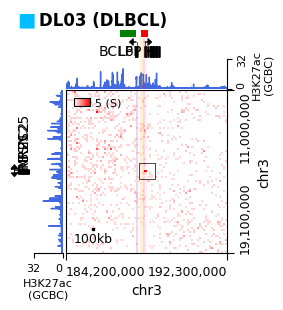

In [68]:
resolution = 100000
radius = 40 * resolution

gene_filter = ["NR2C2", "MRPS25", "RBSN", "LPP", "BCL6"]
regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

regionY, regionX = regionX, regionY

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter, 
    vmax=5,
    show_neoloops=False, 
    show_uvp=False,
    all_same_line=True,
    show_gene_top=True,
    show_gene_left=True,
    num_bins=2500,
)

ax_gene = fig.axes[2]
# ax_gene.set_fc("yellow")

orange_start = 187971619
orange_end = 188320198
green_start = 186890568
green_end = 187706403


rect_orange = Rectangle(( orange_start, 0.5), orange_end-orange_start, 0.25, fc="red", ec="none", clip_on=False)
rect_green = Rectangle((green_start, 0.5), green_end-green_start, 0.25, fc="green", ec="none", clip_on=False)
ax_gene.add_patch(rect_orange)
ax_gene.add_patch(rect_green)
ax_center = fig.axes[0]
ax_center.axvspan(bcl6_prom_start, bcl6_prom_end, color="purple", alpha=0.1)

ax_gene.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
fig.axes[4].axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
ax_center.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)


ax_gene.axvspan(se2_start, se2_end, color="red", alpha=0.1)
fig.axes[4].axvspan(se2_start, se2_end, color="red", alpha=0.1)
ax_center.axvspan(se2_start, se2_end, color="red", alpha=0.1)

ax_gene.axvspan(se3_start, se3_end, color="violet", alpha=0.1)
fig.axes[4].axvspan(se3_start, se3_end, color="violet", alpha=0.1)
ax_center.axvspan(se3_start, se3_end, color="violet", alpha=0.1)

rect = Rectangle((rxmin, rymin), rxmax-rxmin, rymax-rymin, ec="black", fc="none", lw=0.5)
print(rxmin, rymin, rxmax, rymax)
fig.axes[0].add_patch(rect)


fig.savefig(figure_path(f"supp4_{arima_sample.id}_BCL6_1_outer.svg"), bbox_inches="tight")

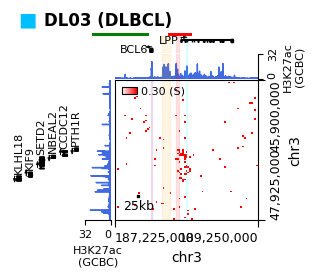

In [69]:
arima_sample = [s for s in arima_samples if s.id == "DL03"][0]
sample = [s for s in samples if s.meta.id_paper == "DL03"][0]

chr_search = "chr3"
pos_search = 46910000
breakpoints = arima_sample.breakpoints
bpoint = [bpoint for bpoint in breakpoints if bpoint.breakendA.chrom == chr_search and bpoint.breakendA.pos == pos_search][0]
gene_filter = ["PTH1R", "CCDC12", "NBEAL2", "SETD2", "KIF9", "KLHL18", "BCL6", "LPP"]
# gene_filter=None
resolution = 25000
radius = 40 * resolution

regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

regionY, regionX = regionX, regionY

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    figsize=(3.2, 2.4),
    gene_filter=gene_filter, 
    vmax=0.3,
    show_neoloops=False, 
    show_uvp=False,
    all_same_line=False,
    show_gene_top=True,
    gene_track_top_ratio=0.125,
    show_gene_left=True,
    gene_track_left_ratio=0.5,
)

ax_gene = fig.axes[2]

orange_start = 187971619
orange_end = 188320198
green_start = 186890568
green_end = 187706403


rect_orange = Rectangle(( orange_start, 1.5), orange_end-orange_start, 0.25, fc="red", ec="none", clip_on=False)
rect_green = Rectangle((green_start, 1.5), green_end-green_start, 0.25, fc="green", ec="none", clip_on=False)
ax_gene.add_patch(rect_orange)
ax_gene.add_patch(rect_green)
ax_center = fig.axes[0]
ax_center.axvspan(bcl6_prom_start, bcl6_prom_end, color="purple", alpha=0.1)

ax_gene.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
fig.axes[4].axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
ax_center.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)


ax_gene.axvspan(se2_start, se2_end, color="red", alpha=0.1)
fig.axes[4].axvspan(se2_start, se2_end, color="red", alpha=0.1)
ax_center.axvspan(se2_start, se2_end, color="red", alpha=0.1)

ax_gene.axvspan(se3_start, se3_end, color="cyan", alpha=0.1)
fig.axes[4].axvspan(se3_start, se3_end, color="cyan", alpha=0.1)
ax_center.axvspan(se3_start, se3_end, color="cyan", alpha=0.1)


rxmin, rxmax = regionX.start, regionX.end
rymin, rymax = regionY.start, regionY.end

fig.savefig(figure_path(f"supp4_{arima_sample.id}_BCL6_2_zoom.svg"), bbox_inches="tight")

187225000 45900000 189250000 47925000


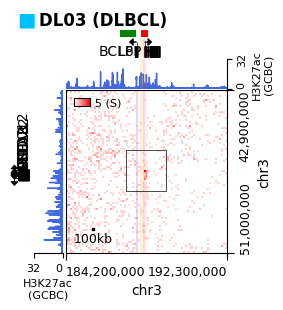

In [70]:
resolution = 100000
radius = 40 * resolution

regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

regionY, regionX = regionX, regionY

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter, 
    vmax=5,
    show_neoloops=False, 
    show_uvp=False,
    all_same_line=True,
    show_gene_top=True,
    show_gene_left=True,
    num_bins=2500,
)

ax_gene = fig.axes[2]
# ax_gene.set_fc("yellow")

orange_start = 187971619
orange_end = 188320198
green_start = 186890568
green_end = 187706403


rect_orange = Rectangle(( orange_start, 0.5), orange_end-orange_start, 0.25, fc="red", ec="none", clip_on=False)
rect_green = Rectangle((green_start, 0.5), green_end-green_start, 0.25, fc="green", ec="none", clip_on=False)
ax_gene.add_patch(rect_orange)
ax_gene.add_patch(rect_green)
ax_center = fig.axes[0]
ax_center.axvspan(bcl6_prom_start, bcl6_prom_end, color="purple", alpha=0.1)

ax_gene.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
fig.axes[4].axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
ax_center.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)


ax_gene.axvspan(se2_start, se2_end, color="red", alpha=0.1)
fig.axes[4].axvspan(se2_start, se2_end, color="red", alpha=0.1)
ax_center.axvspan(se2_start, se2_end, color="red", alpha=0.1)

ax_gene.axvspan(se3_start, se3_end, color="violet", alpha=0.1)
fig.axes[4].axvspan(se3_start, se3_end, color="violet", alpha=0.1)
ax_center.axvspan(se3_start, se3_end, color="violet", alpha=0.1)

rect = Rectangle((rxmin, rymin), rxmax-rxmin, rymax-rymin, ec="black", fc="none", lw=0.5)
print(rxmin, rymin, rxmax, rymax)
fig.axes[0].add_patch(rect)


fig.savefig(figure_path(f"supp4_{arima_sample.id}_BCL6_2_outer.svg"), bbox_inches="tight")

# MYC Case Triangles

## DL03

In [100]:
arima_sample = [s for s in arima_samples if s.id == "DL03"][0]

In [101]:
resolution = 10000
assembly = [
    GenomicRegion("chr8", 47670000, 48170000, reverse=True), 
    GenomicRegion("chr8", 127600000, 128500000),
]

assembly = [r.get_bin_aligned(resolution) for r in assembly]

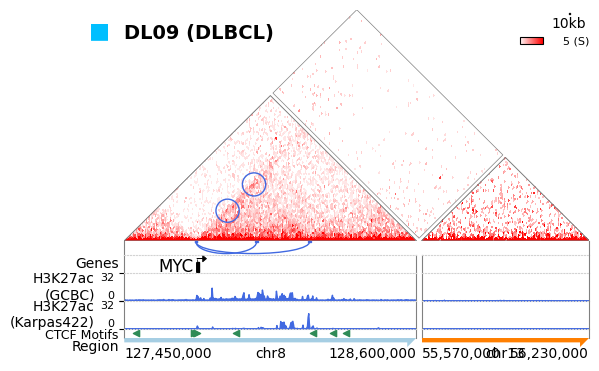

In [113]:
fig = plot_standard_triangle_plot(
    arima_sample, assembly, resolution,
    gene_filter=["MYC", "SPIDR"], 
    vmax=5, 
    gap_size=2,
    show_bw1_track=True,
    bw1_pair=BW_GERMINAL,
    show_bw2_track=True,
    bw2_pair=BW_KARPAS_DLBCL,
    plot_cnv_segments=True,
    show_loops=True,
    show_neoloops=True,
    neoloop_interchrom_only=True,
    neoloop_filter=GenomicRegion("chr8", 127725000, 127745000), # MYC promoter
    loop_filter=GenomicRegion("chr8", 127725000, 127745000), # MYC promoter
    show_triangle_arcs=True,
)
fig.savefig(figure_path("DL03_MYC-R.svg"), bbox_inches="tight")

### Extended Segments

In [107]:
resolution = 10000
assembly = [
    GenomicRegion("chr8", 64170000, 64670000),
    GenomicRegion("chr8", 48175000, 48430000, reverse=True), 
    GenomicRegion("chr8", 71570000, 71950000),
    GenomicRegion("chr8", 71950000, 72050000, reverse=True),
    GenomicRegion("chr8", 47670000, 48170000, reverse=True), 
    GenomicRegion("chr8", 127600000, 128500000),
]

assembly = [r.get_bin_aligned(resolution) for r in assembly]

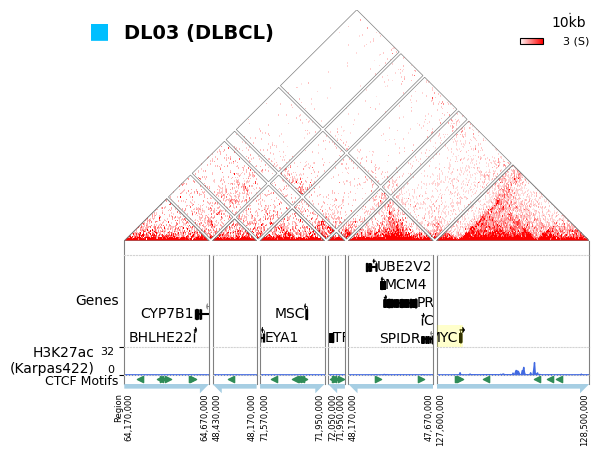

In [109]:
fig = plot_standard_triangle_plot(
    arima_sample, assembly, resolution,
    vmax=3, 
    gap_size=2,
    show_bw1_track=True,
    keygenes=["MYC"],
    bw1_pair=BW_KARPAS_DLBCL,
    show_gene_full=True,
    hr_gene=1,
    plot_cnv_segments=True,
    show_loops=False,
    show_neoloops=False,
    neoloop_interchrom_only=False,
    neoloop_filter=GenomicRegion("chr8", 127730000, 127750000),
    loop_filter=GenomicRegion("chr8", 127730000, 127750000),
    show_triangle_arcs=True,
    hide_arrow_text=True,
)
fig.savefig(figure_path("DL03_MYC-R_extended.svg"), bbox_inches="tight")

## DL09

In [110]:
arima_sample = [s for s in arima_samples if s.id == "DL09"][0]
sample = [s for s in samples if s.meta.id_paper == "DL09"][0]

In [111]:
resolution = 10000
assembly = [
    GenomicRegion("chr8", 127450000, 128600000), 
    GenomicRegion("chr13", 55570000, 56225000),
]

assembly = [r.get_bin_aligned(resolution) for r in assembly]

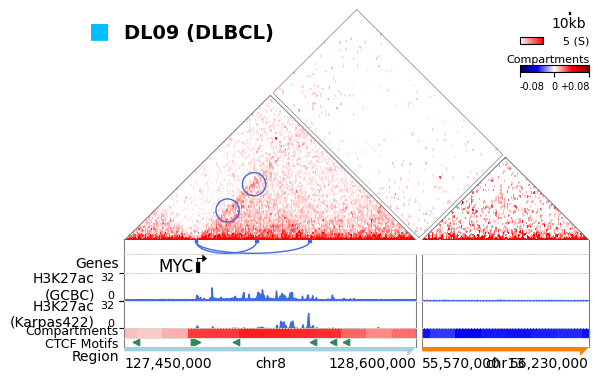

In [112]:
fig = plot_standard_triangle_plot(
    arima_sample, assembly, resolution,
    gene_filter=["MYC"], 
    vmax=5, 
    gap_size=2,
    show_bw1_track=True,
    bw1_pair=BW_GERMINAL,
    show_bw2_track=True,
    bw2_pair=BW_KARPAS_DLBCL,
    # show_cn_track=True,
    plot_cnv_segments=True,
    show_compartment_track=True,
    show_loops=True,
    show_neoloops=True,
    neoloop_interchrom_only=False,
    neoloop_filter=GenomicRegion("chr8", 127730000, 127750000),
    loop_filter=GenomicRegion("chr8", 127730000, 127750000),
    show_triangle_arcs=True,
    # hide_arrow_text=True,
)
fig.savefig(figure_path("DL09_MYC-R.svg"), bbox_inches="tight")

## PL13

In [117]:
arima_sample = [s for s in arima_samples if s.id == "PL13"][0]
sample = [s for s in samples if s.meta.id_paper == "PL13"][0]

In [118]:
resolution = 10000
assembly = [
    GenomicRegion("chr8", 126900000, 130000000), 
]

assembly = [r.get_bin_aligned(resolution) for r in assembly]

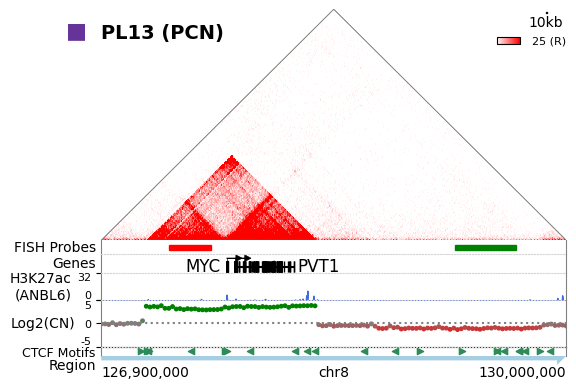

In [119]:
orange_start= 127351112
orange_end = 127628392

green_start = 129257503
green_end = 129664187

fig = plot_standard_triangle_plot(
    arima_sample, assembly, resolution,
    gene_filter=["MYC", "PVT1"], 
    norm="NONE",
    vmax=25, 
    gap_size=2,
    # show_uvp=True,
    show_bw1_track=True,
    bw1_pair=BW_MYELOMA_ANBL6,
    show_cn_track=True,
    cnv_lim=(-5, 5),
    dot_size=25,
    plot_cnv_segments=False,
    
    show_loops=True,
    loop_filter=GenomicRegion("chr8", 0, 0),
    show_triangle_arcs=True,
)

ax_probes = fig.axes[1]
ax_probes.axis('on')
probe_orange = Rectangle((orange_start, 0), orange_end-orange_start, 1, color="red")
probe_green = Rectangle((green_start, 0), green_end-green_start, 1, color="green")
ax_probes.add_patch(probe_orange)
ax_probes.add_patch(probe_green)
ax_probes.set_ylim((-1, 2))
ax_probes.set_xlim((assembly[0].start, assembly[0].end))
ax_probes.set_ylabel("FISH Probes", rotation=0, fontsize=10, ha="right", va="center")

ax_gene = fig.axes[2]
texts = ax_gene.findobj(matplotlib.text.Text)
gene_xmin, gene_xmax = ax_gene.get_xlim()
xpos = GENE_ANNOTATIONS.genes_by_name("PVT1")[0].end
texts[1].set_x(xpos + resolution*2)
texts[1].set_ha("left")
fig.savefig(figure_path(f"{arima_sample.id}_MYC-amp_TRI.svg"), bbox_inches="tight")

# MYC and Loops for Every Sample

In [120]:
def plot_loop_region_linear(axis_region: GenomicRegion, loop_regionA: GenomicRegion, loop_regionB: GenomicRegion, ax=None, loop_colour=LOOP_COLOUR):
    assert loop_regionA.chrom == loop_regionB.chrom
    assert not axis_region.reverse 
    chrom = loop_regionA.chrom
    # Plot arc, genes, H3K27ac, CTCF, chrom arrows
    region_start = axis_region.start
    region_end = axis_region.end

    posA = loop_regionA.get_center()
    posB = loop_regionB.get_center()

    midarc = (posA + posB) / 2
    arc = matplotlib.patches.Arc((int(midarc), 0), int(posA-midarc) * 2, 1, theta1=180, theta2=360, ec=loop_colour)
    rectA = Rectangle((loop_regionA.start, 0), loop_regionA.get_size(), 0.1, color=loop_colour)
    rectB = Rectangle((loop_regionB.start, 0), loop_regionB.get_size(), 0.1, color=loop_colour)
    
    ax.add_patch(arc)
    ax.add_patch(rectA)
    ax.add_patch(rectB)
    ax.set_xlim(region_start, region_end)
    ax.set_ylim(-0.6, 0.1)
    ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

In [121]:
resolution = 10000
gregion = GenomicRegion("chr8", 127100000, 128500000).get_bin_aligned(resolution)

goi_name = "MYC"
goi = GENE_ANNOTATIONS.genes_by_name(goi_name)[0]
goi_chrom = chr_prefix(goi.contig)
goi_prom = goi.start

anchor_region = GenomicRegion("chr8", goi_prom // resolution * resolution, goi_prom // resolution * resolution + resolution).get_bin_aligned(resolution)

In [122]:
groupA = """
DL01 (BCL6, IRF4)
DL02 (BCL6)
DL04 (IGH)
DL05 (PAX5)
DL07 (IRAG2)
DL08 (KYNU)
""".strip().split("\n")

groupB = """
DL03 (chr8)
DL09 (chr13)
""".strip().split("\n")

groupC = """
DL06
DL10
DL11
""".strip().split("\n")

groupD = """
PL09 (IGH)
PL05 (IGH/CCND1)
""".strip().split("\n")

groupE = """
PL12
PL13
PL11
PL08
PL07
PL06
PL10
PL04
PL02
PL14
PL03
PL01
""".strip().split("\n")

In [123]:
label_dicts = {}
for group in groupA + groupB + groupD:
    sample_id = group.split(" ")[0]
    partners = " ".join(group.split(" ")[1:])
    label_dicts[sample_id] = partners
for group in groupC + groupE:
    label_dicts[group] = None

In [124]:
groupA_arima_samples = []
groupB_arima_samples = []
groupC_arima_samples = []
groupD_arima_samples = []
groupE_arima_samples = []
for sample in arima_samples:
    if sample.id in [x.split()[0] for x in groupA]:
        groupA_arima_samples.append(sample)
    elif sample.id in [x.split()[0] for x in groupB]:
        groupB_arima_samples.append(sample)
    elif sample.id in [x.split()[0] for x in groupC]:
        groupC_arima_samples.append(sample)
    elif sample.id in [x.split()[0] for x in groupD]:
        groupD_arima_samples.append(sample)
    elif sample.id in [x.split()[0] for x in groupE]:
        groupE_arima_samples.append(sample)

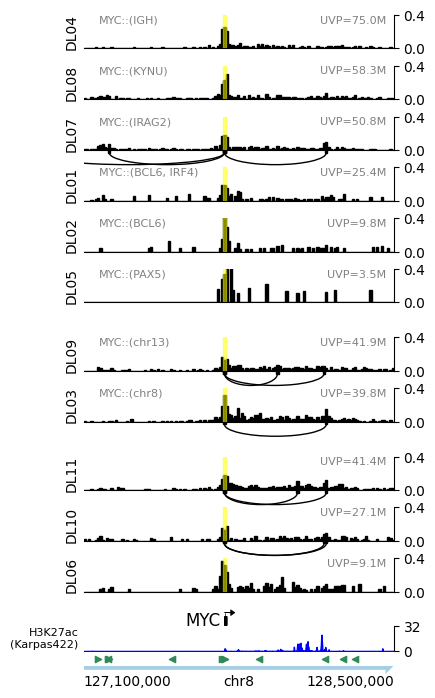

In [125]:
virtual_ymax=0.4
# grouped_samples = groupB_arima_samples

all_grouped = groupA_arima_samples + [None] + groupB_arima_samples + [None] +  \
                groupC_arima_samples
    
vmax=0.08
n = len(all_grouped)
height_ratios = [x for l in [[2, 1] if g is not None else [0.5, 0.5] for g in all_grouped ] for x in l] + [1, 1.5, 0, 0.8, 1]

fig, axes = plt.subplots(len(height_ratios), figsize=(4,n / 1.5), height_ratios=height_ratios)
fig.subplots_adjust(hspace=0.02)

for i, arima_sample in enumerate(all_grouped):
    ax_virtual = axes[i*2]
    ax_loop = axes[1+i*2]
    ax_virtual.set_fc("none")
    ax_loop.set_fc("none")
    
    if arima_sample is None:
        ax_virtual.axis('off')
        ax_loop.axis('off')
        continue
        
    sample = [s for s in samples if s.meta.id_paper == arima_sample.id][0]
    loops = read_loops(sample.profile.loops_hicexplorer)
    filtered_loops = [l for l in loops if l.regionA.chrom == "chr8" and (l.regionA.start == anchor_region.start or l.regionB.start == anchor_region.start) and l.regionB.overlaps(gregion)]
    assembly = [gregion]
    assembled = arima_sample.get_assembled_hic(assembly, resolution, norm=HIC_NORM, norm_constant_normalize=True)
    
    virtual = arima_sample.get_hic_region_data(gregion, anchor_region, resolution=resolution, normalization=HIC_NORM, norm_constant_normalize=True)
    xs = gregion.start + np.arange(virtual.shape[1]) * resolution + resolution / 2
    ax_virtual.bar(xs, virtual.flatten(), fc="black", ec="black", width=resolution)
    ax_virtual.set_xticks([])
    # print(virtual.max())
    ax_virtual.set_ylim(0, virtual_ymax)
    # ax_virtual.set_yticks([0, virtual.max()], ["0", "Window\nMax"])
    ax_virtual.set_yticks([0, virtual_ymax])
    ax_virtual.set_xlim(gregion.start, gregion.end)
    ax_virtual.set_ylabel(sample.meta.id_paper)
    ax_virtual.yaxis.tick_right()

    partner_text = label_dicts.get(sample.meta.id_paper)
    if partner_text is not None:
        ax_virtual.text(0.05, 1, "MYC::" + partner_text, ha="left", va="top", fontsize=8, transform=ax_virtual.transAxes, color="gray")

    ax_virtual.text(0.975, 1, f"UVP={sample.uvp/1e6:.1f}M", ha="right", va="top", fontsize=8, transform=ax_virtual.transAxes, color="gray")

    blank_axis(ax_loop)
    for l in filtered_loops:
        plot_loop_region_linear(gregion, l.regionA, l.regionB, ax=ax_loop, loop_colour="black")
    ax_virtual.spines[["top", "left"]].set_visible(False)
    ax_virtual.axvspan(anchor_region.start, anchor_region.end, alpha=0.5, color="yellow")

ax_gene = axes[2*n]
ax_bw1 = axes[2*n+1]
ax_bw2 = axes[2*n+2]
ax_ctcf = axes[2*n+3]
ax_arrow = axes[2*n+4]
plot_gene_track(gregion, gene_filter=["MYC"], ax=ax_gene, all_same_line=True, fontsize=12)
plot_bigwig_track(pyBigWig.open(BW_KARPAS_DLBCL[1]), gregion, ax=ax_bw1, ymax=GLOBAL_BW_MAX)
plot_bigwig_track(pyBigWig.open(BW_MYELOMA_ANBL6[1]), gregion, ax=ax_bw2, ymax=GLOBAL_BW_MAX)
ax_bw1.set_yticks([0, 32], [0, 32])
ax_bw1.yaxis.tick_right()
ax_bw1.spines[["left"]].set_visible(False)
ax_bw1.spines[["right"]].set_visible(True)
ax_bw1.set_ylabel("H3K27ac\n(Karpas422)", fontsize=8, rotation=0, ha="right", va="center")

ax_bw2.set_yticks([0, 32], [0, 32])
ax_bw2.yaxis.tick_right()
ax_bw2.set_ylabel("H3K27ac\n(ANBL6)", fontsize=8, rotation=0, ha="right", va="center")
ax_bw2.axis('off')

plot_ctcf_track(CTCF_BEDFILE, gregion, ax=ax_ctcf)
plot_arrow_track(gregion, ax=ax_arrow)

fig.savefig(figure_path("virtual_myc_locus_comparison_dl.svg"), bbox_inches="tight")

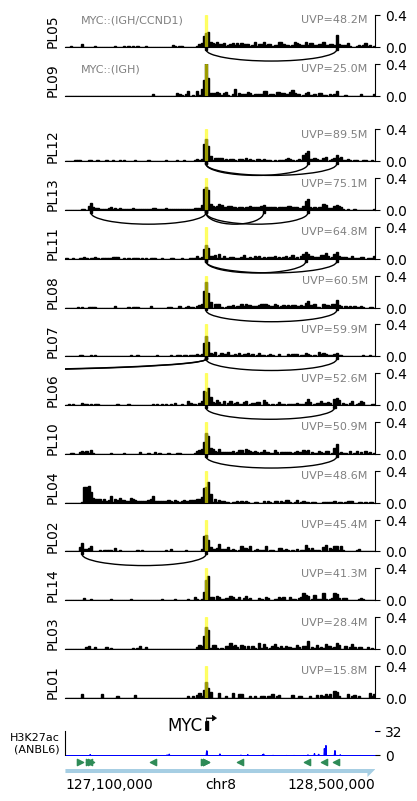

In [126]:
virtual_ymax=0.4

all_grouped = groupD_arima_samples + [None] + groupE_arima_samples
    
vmax=0.08
n = len(all_grouped)
height_ratios = [x for l in [[2, 1] if g is not None else [0.5, 0.5] for g in all_grouped ] for x in l] + [1, 0, 1.5, 0.8, 1]

fig, axes = plt.subplots(len(height_ratios), figsize=(4,n / 1.5), height_ratios=height_ratios)
fig.subplots_adjust(hspace=0.02)

for i, arima_sample in enumerate(all_grouped):
    ax_virtual = axes[i*2]
    ax_loop = axes[1+i*2]
    ax_virtual.set_fc("none")
    ax_loop.set_fc("none")
    
    if arima_sample is None:
        ax_virtual.axis('off')
        ax_loop.axis('off')
        continue
        
    sample = [s for s in samples if s.meta.id_paper == arima_sample.id][0]
    loops = read_loops(sample.profile.loops_hicexplorer)
    filtered_loops = [l for l in loops if l.regionA.chrom == "chr8" and (l.regionA.start == anchor_region.start or l.regionB.start == anchor_region.start) and l.regionB.overlaps(gregion)]
    assembly = [gregion]
    assembled = arima_sample.get_assembled_hic(assembly, resolution, norm=HIC_NORM, norm_constant_normalize=True)
    
    virtual = arima_sample.get_hic_region_data(gregion, anchor_region, resolution=resolution, normalization=HIC_NORM, norm_constant_normalize=True)
    xs = gregion.start + np.arange(virtual.shape[1]) * resolution + resolution / 2
    ax_virtual.bar(xs, virtual.flatten(), fc="black", ec="black", width=resolution)
    ax_virtual.set_xticks([])
    # print(virtual.max())
    ax_virtual.set_ylim(0, virtual_ymax)
    # ax_virtual.set_yticks([0, virtual.max()], ["0", "Window\nMax"])
    ax_virtual.set_yticks([0, virtual_ymax])
    ax_virtual.set_xlim(gregion.start, gregion.end)
    ax_virtual.set_ylabel(sample.meta.id_paper)
    ax_virtual.yaxis.tick_right()

    partner_text = label_dicts.get(sample.meta.id_paper)
    if partner_text is not None:
        ax_virtual.text(0.05, 1, "MYC::" + partner_text, ha="left", va="top", fontsize=8, transform=ax_virtual.transAxes, color="gray")
        
    ax_virtual.text(0.975, 1, f"UVP={sample.uvp/1e6:.1f}M", ha="right", va="top", fontsize=8, transform=ax_virtual.transAxes, color="gray")

    blank_axis(ax_loop)
    for l in filtered_loops:
        plot_loop_region_linear(gregion, l.regionA, l.regionB, ax=ax_loop, loop_colour="black")
    ax_virtual.spines[["top", "left"]].set_visible(False)
    ax_virtual.axvspan(anchor_region.start, anchor_region.end, alpha=0.5, color="yellow")

ax_gene = axes[2*n]
ax_bw1 = axes[2*n+1]
ax_bw2 = axes[2*n+2]
ax_ctcf = axes[2*n+3]
ax_arrow = axes[2*n+4]
plot_gene_track(gregion, gene_filter=["MYC"], ax=ax_gene, all_same_line=True, fontsize=12)
plot_bigwig_track(pyBigWig.open(BW_KARPAS_DLBCL[1]), gregion, ax=ax_bw1, ymax=GLOBAL_BW_MAX)
plot_bigwig_track(pyBigWig.open(BW_MYELOMA_ANBL6[1]), gregion, ax=ax_bw2, ymax=GLOBAL_BW_MAX)
ax_bw1.set_yticks([0, 32], [0, 32])
ax_bw1.yaxis.tick_right()
ax_bw1.spines[["left"]].set_visible(False)
ax_bw1.spines[["right"]].set_visible(True)
ax_bw1.set_ylabel("H3K27ac\n(Karpas422)", fontsize=8, rotation=0, ha="right", va="center")

ax_bw2.set_yticks([0, 32], [0, 32])
ax_bw2.yaxis.tick_right()
ax_bw2.set_ylabel("H3K27ac\n(ANBL6)", fontsize=8, rotation=0, ha="right", va="center")

ax_bw1.axis('off')

plot_ctcf_track(CTCF_BEDFILE, gregion, ax=ax_ctcf)
plot_arrow_track(gregion, ax=ax_arrow)

fig.savefig(figure_path("virtual_myc_locus_comparison_pcn.svg"), bbox_inches="tight")

# Neoloop H3K27ac

In [43]:
import random

In [ ]:
# %%time
bw = pyBigWig.open(BW_GERMINAL[1])

width = 100000
num_bins = bw.values("chr1", width-width, width+width, numpy=True).size

cum_neoloops = np.zeros(num_bins)
cum_random = np.zeros(num_bins)

total_added = 0

for sample in samples:
    print(sample.meta.id_paper)
    neoloops = read_neoloops(sample.profile.neoloops)
    for neoloop in neoloops:
        if neoloop.regionA.get_center()- width < 0 or neoloop.regionA.get_center()+width>CHROM_SIZES[neoloop.regionA.chrom]:
            print(f"{neoloop.regionA.chrom}:{neoloop.regionA.get_center()}, skipping")
            continue
        if neoloop.regionB.get_center() - width < 0 or neoloop.regionB.get_center()+width > CHROM_SIZES[neoloop.regionB.chrom]:
            print(f"{neoloop.regionB.chrom}:{neoloop.regionB.get_center()}, skipping")
            continue

        a_values = bw.values(neoloop.regionA.chrom, neoloop.regionA.get_center()-width, neoloop.regionA.get_center()+width, numpy=True)
        b_values = bw.values(neoloop.regionB.chrom, neoloop.regionB.get_center()-width, neoloop.regionB.get_center()+width, numpy=True)

        try:
            compartment_subset = COMPARTMENT_REGIONS_100kb[(COMPARTMENT_REGIONS_100kb.chr == neoloop.regionA.chrom) & (COMPARTMENT_REGIONS_100kb.blacklisted == False)]
            random_comp = random.randint(0, len(compartment_subset)-1)
            start = compartment_subset.iloc[random_comp].start
            end = compartment_subset.iloc[random_comp]. end
        except:
            start = 0
            end = CHROM_SIZES[neoloop.regionA.chrom]
        random_point_on_chrA= min(max(width, random.randint(start, end)), CHROM_SIZES[neoloop.regionA.chrom]-width)
        random_valuesA = bw.values(neoloop.regionA.chrom, random_point_on_chrA-width, random_point_on_chrA+width, numpy=True)

        try:
            compartment_subset = COMPARTMENT_REGIONS_100kb[(COMPARTMENT_REGIONS_100kb.chr == neoloop.regionB.chrom) & (COMPARTMENT_REGIONS_100kb.blacklisted == False)]
            random_comp = random.randint(0, len(compartment_subset)-1)
            start = compartment_subset.iloc[random_comp].start
            end = compartment_subset.iloc[random_comp]. end
        except:
            start = 0
            end = CHROM_SIZES[neoloop.regionB.chrom]
        random_point_on_chrB= min(max(width, random.randint(start, end)), CHROM_SIZES[neoloop.regionB.chrom]-width)
        random_valuesB = bw.values(neoloop.regionB.chrom, random_point_on_chrB-width, random_point_on_chrB+width, numpy=True)

        cum_neoloops += np.nan_to_num(a_values) + np.nan_to_num(b_values)
        cum_random += np.nan_to_num(random_valuesA) + np.nan_to_num(random_valuesB)

        total_added += 1

In [48]:
print(total_added)

7859


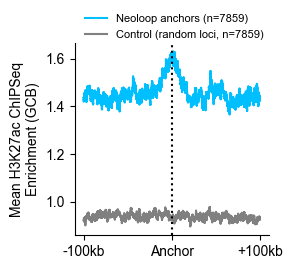

In [50]:
fig, ax = plt.subplots(figsize=(2.5,2.5))

ax.plot(cum_neoloops / (total_added * 2), c="deepskyblue", label=f"Neoloop anchors (n={total_added})")
ax.plot(cum_random / (total_added * 2) , c="gray", label=f"Control (random loci, n={total_added})")
midpoint = num_bins / 2
ax.axvline(midpoint, c="black", linestyle=":")
ax.set_ylabel("Mean H3K27ac ChIPSeq\nEnrichment (GCB)")
ax.set_xticks([0, midpoint, num_bins], [f"-{width//1000}kb", "Anchor", f"+{width//1000}kb"])
ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon=False, loc="upper left", prop={"size": 8}, bbox_to_anchor=(0, 1.2))

fig.savefig(figure_path("supp_neoloop_h3k27ac_enrichment.svg"), bbox_inches="tight")

# LMO2 and TAL1::STIL Copy Number

## TA01

In [130]:
arima_sample = [s for s in arima_samples if s.id == "TA01"][0]
sample = [s for s in samples if s.meta.id_paper == "TA01"][0]

In [131]:
resolution = 25000
assembly = [
    GenomicRegion("chr11", 33000000, 37500000), 
]

assembly = [r.get_bin_aligned(resolution) for r in assembly]

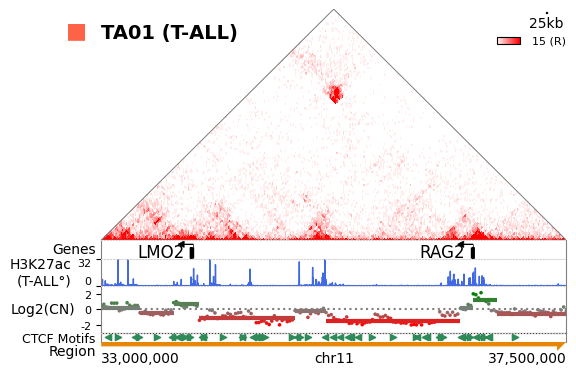

In [132]:
fig = plot_standard_triangle_plot(
    arima_sample, assembly, resolution,
    gene_filter=["LMO2", "RAG2"], 
    norm="NONE",
    vmax=15, 
    gap_size=2,
    show_bw1_track=True,
    bw1_pair=BW_TALL,
    show_cn_track=True,
    dot_size=10,
    cnv_lim=(-3, 3),
    plot_cnv_segments=True,
    bw_num_bins=4000,
    
)
fig.savefig(figure_path(f"{arima_sample.id}_MYC-amp_TRI.svg"), bbox_inches="tight")

## TA02

In [133]:
arima_sample = [s for s in arima_samples if s.id == "TA02"][0]
sample = [s for s in samples if s.meta.id_paper == "TA02"][0]

In [134]:
resolution = 5000
assembly = [
    GenomicRegion("chr1", 47000000, 47500000), 
]

assembly = [r.get_bin_aligned(resolution) for r in assembly]

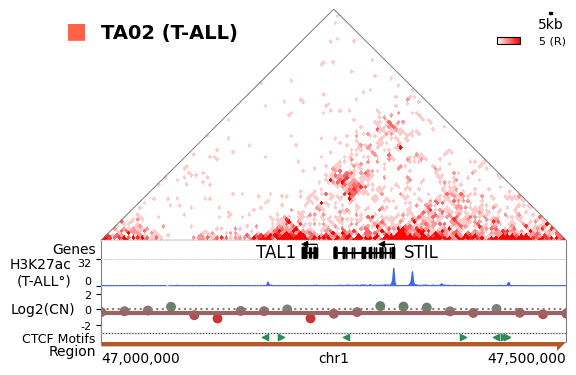

In [135]:
fig = plot_standard_triangle_plot(
    arima_sample, assembly, resolution,
    gene_filter=["TAL1", "STIL"], 
    norm="NONE",
    vmax=5, 
    gap_size=2,
    show_bw1_track=True,
    bw1_pair=BW_TALL,
    show_cn_track=True,
    dot_size=150,
    cnv_lim=(-3, 3),
    plot_cnv_segments=True,
    bw_num_bins=400,

)

ax_gene = fig.axes[2]
texts = ax_gene.findobj(matplotlib.text.Text)
gene_xmin, gene_xmax = ax_gene.get_xlim()
xpos = GENE_ANNOTATIONS.genes_by_name("STIL")[0].end
texts[1].set_x(xpos + resolution*2)
texts[1].set_ha("left")

fig.savefig(figure_path(f"fig6_{arima_sample.id}_MYC-amp_TRI.svg"), bbox_inches="tight")

# BCL6 Complex Rearrangement

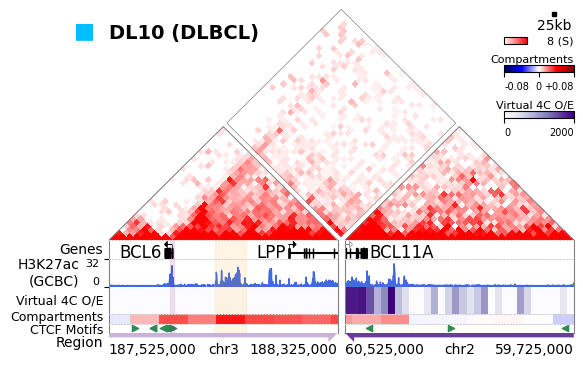

In [140]:
arima_sample = [a for a in arima_samples if a.id == "DL10"][0]
resolution = 25000

assembly = [
    GenomicRegion("chr3", 187525000, 188325000),
    GenomicRegion("chr2", 59725000, 60525000, reverse=True),
]
assembly = [a.get_bin_aligned(resolution) for a in assembly]

fig = plot_standard_triangle_plot(
    arima_sample,
    assembly,
    resolution,
    gene_filter=["BCL6", "LPP", "BCL11A"],
    show_bw1_track=True,
    bw1_pair=BW_GERMINAL,
    show_cn_track=False,
    plot_cnv_segments=True,
    show_compartment_track=True,
    vmax=8,
    bw_num_bins=1000,
    show_bw2_track=True,
    bw2_pair=BW_GERMINAL,
)

ax_new_left = fig.axes[4]
ax_new_mid = fig.axes[12]
ax_new_right = fig.axes[20]

ax_new_left.clear()
# ax_new_mid.clear()
ax_new_right.clear()


goi = GENE_ANNOTATIONS.genes_by_name("BCL6")[0]
goi_promoter = goi.end
goi_chrom = chr_prefix(goi.contig)

viewpoint_bin = GenomicRegion(goi_chrom, goi_promoter//resolution*resolution, goi_promoter//resolution*resolution+resolution-1).get_bin_aligned(resolution)

data_left = arima_sample.get_hic_region_data(assembly[0], viewpoint_bin, resolution=resolution, measure="oe", normalization="SCALE")
data_right = arima_sample.get_hic_region_data(assembly[1], viewpoint_bin, resolution=resolution, measure="oe", normalization="SCALE")

cmap = "Purples"
vmax = 2000
vmin = 0
ax_new_left.matshow(data_left, cmap=cmap, vmin=vmin, vmax=vmax, aspect="auto", extent=[assembly[0].start, assembly[0].end, 0, 1])
ax_new_right.matshow(data_right, cmap=cmap, vmin=vmin, vmax=vmax, aspect="auto", extent=[assembly[1].end, assembly[1].start, 0, 1])
blank_axis(ax_new_left)
blank_axis(ax_new_right)

ax_new_left.spines[["left", "right"]].set_visible(True)
ax_new_left.spines[["left", "right"]].set_ec("gray")
ax_new_right.spines[["left", "right"]].set_visible(True)
ax_new_right.spines[["left", "right"]].set_ec("gray")
ax_new_left.set_ylabel("Virtual 4C O/E", rotation=0, fontsize=9, va="center", ha="right")

bcl6_prom_start = 187745725 - 7500
bcl6_prom_end = 187745725 + 7500
enhancer_start = 187745725 +150000
enhancer_end = 187745725 +260000

ax_lefts = [fig.axes[i] for i in [2, 3, 4, 7]]
for ax in ax_lefts:
    ax.axvspan(enhancer_start, enhancer_end, color="orange", alpha=0.1)
    ax.axvspan(bcl6_prom_start,bcl6_prom_end, color="purple", alpha=0.1)

# O/E colorbar
cax = fig.axes[0].inset_axes([0.85, 0.53, 0.15, 0.03])
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), cax=cax, orientation='horizontal', ticks=[0, vmax])
cax.tick_params(labelsize=7)
cax.get_xticklabels()[0].set_ha("left")
cax.get_xticklabels()[-1].set_ha("right")
cax.text(1,1.1, "Virtual 4C O/E", ha="right", va="bottom", transform=cax.transAxes, fontsize=8)

fig.savefig(figure_path("BCL6_complex.svg"), bbox_inches="tight")

# PCN vs DLBCL Compartments

In [144]:
def bin_align_value(value: int, resolution: int) -> int:
    return value // resolution * resolution

samples_compartments = samples_all_merge
all_compartments_full = np.array([read_compartments(s.profile.compartments) for s in samples_compartments])

comp_dlbcl = all_compartments_full[[ i for i, s in enumerate(samples_compartments) if s.meta.group == "DLBCL" and get_uvp(s.meta.id_file) > 10000000], :]
comp_pcn = all_compartments_full[[ i for i, s in enumerate(samples_compartments) if s.meta.group == "PCN" and get_uvp(s.meta.id_file) > 10000000], :]

label_dlbcl = [ s.meta.id_paper for i, s in enumerate(samples_compartments) if s.meta.group == "DLBCL" and get_uvp(s.meta.id_file) > 10000000]
label_pcn = [ s.meta.id_paper for i, s in enumerate(samples_compartments) if s.meta.group == "PCN" and get_uvp(s.meta.id_file) > 10000000]

print("DLBCL above threshold, n=", len(comp_dlbcl))
print("PCN above threshold, n=", len(comp_pcn))

print(", ".join(label_dlbcl))
print(", ".join(label_pcn))

n_dlbcl = len(comp_dlbcl)
n_pcn = len(comp_pcn)

df_compartments = pd.DataFrame(np.hstack([comp_dlbcl.T, comp_pcn.T]), columns=label_dlbcl + label_pcn)

DLBCL above threshold, n= 8
PCN above threshold, n= 14
DL04, DL08, DL07, DL09, DL11, DL03, DL10, DL01
PL12, PL13, PL11, PL08, PL07, PL06, PL10, PL04, PL05, PL02, PL14, PL03, PL09, PL01


In [145]:
comp_dict = defaultdict(list)
res = 100000
indices = []
for gene in GENE_ANNOTATIONS.genes():
    if gene.biotype != "protein_coding": # protein-coding only
        continue
    if gene.contig == "X" or gene.contig == "Y": # exclude chrX and chrY
        continue
    if gene.strand == "+":
        promoter_pos = gene.start
    elif gene.strand == "-":
        promoter_pos = gene.end 
        
    chrom = chr_prefix(gene.contig)
    start = bin_align_value(promoter_pos, res)

    subset_chr = COMPARTMENT_REGIONS_100kb[(COMPARTMENT_REGIONS_100kb.chr == chrom)]
    try:
        row = subset_chr[subset_chr.start == start]
        subset_start = row.index[0]
    except IndexError: # exclude out of bounds
        continue
    if row.blacklisted.iloc[0]: # exclude blacklisted
        continue
    indices.append(subset_start)
    comp_dict[(chrom, start, start+res-1)].append(gene.gene_name if gene.gene_name != "" else gene.gene_id)

indices = sorted(list(set(indices)))

df_compartments = df_compartments.loc[indices, :]
gene_column = []
compartment_column = []
for index in indices:
    row = COMPARTMENT_REGIONS_100kb.iloc[index, :]
    compartment_string = f"{row.chr}:{row.start}-{row.end}"
    genes = comp_dict[(row.chr, row.start, row.end)]
    gene_column.append(", ".join(genes))
    compartment_column.append(compartment_string)
df_compartments["gene_promoters"] = gene_column
df_compartments["compartment_bin"] = compartment_column

In [146]:
df = df_compartments.copy()

def get_pairings_dlbcl_pcn(df):
    # DLBCL is grouped first in the columns
    df_dlbcl = df.drop(["compartment_bin", "gene_promoters"], axis=1).iloc[:, :n_dlbcl]
    df_pcn = df.drop(["compartment_bin", "gene_promoters"], axis=1).iloc[:, n_dlbcl:]

    print(df_pcn.shape)
    assert df_dlbcl.shape[1] == n_dlbcl
    assert df_pcn.shape[1]  == n_pcn
    
    df_dlbcl_medians = df_dlbcl.median(axis=1)
    df_pcn_medians = df_pcn.median(axis=1)
    
    df["medians_dlbcl"] = df_dlbcl_medians
    df["medians_pcn"] = df_pcn_medians
    
    # Allocate into two groups depending on compartment switching
    pairings = []
    compartments_ordered = []
    pairing_dictionary = {}
    for dlbcl_row_index, dlbcl_row, pcn_row_index, pcn_row in zip(df_dlbcl.index, df_dlbcl_medians, df_pcn.index, df_pcn_medians):
        assert dlbcl_row_index == pcn_row_index
        compartment_row = COMPARTMENT_REGIONS_100kb.iloc[dlbcl_row_index, :]
        compartment = (compartment_row.chr, compartment_row.start, compartment_row.end)
        dlbcl_compartment = "A" if dlbcl_row > 0 else "B"
        pcn_compartment = "A" if pcn_row > 0 else "B"
        pairing = (dlbcl_compartment, pcn_compartment)
        
        pairings.append(pairing)
        pairing_dictionary[compartment] = pairing
    
    pairing_counts = Counter(pairings)
    print(pairing_counts)
    
    total_comparisons = sum(pairing_counts.values())
    assert total_comparisons == len(df_dlbcl_medians)
    
    pairing_props = { k: v/total_comparisons*100 for k, v in pairing_counts.items() }
    print(pairing_props)

    # Perform statistical testing
    results = []
    for i, row in df.iterrows():
        compartment_row = COMPARTMENT_REGIONS_100kb.loc[i, :]
        compartment = (compartment_row.chr, compartment_row.start, compartment_row.end)
        pairing = pairing_dictionary[compartment] 
        if pairing == ("A", "B") or pairing == ("B", "A"):
            group_dlbcl = row[:n_dlbcl].astype(float)
            group_pcn = row[n_dlbcl:n_pcn+n_dlbcl].astype(float)
            assert len(group_dlbcl) == n_dlbcl
            assert len(group_pcn) == n_pcn
            filtered_genes = row.gene_promoters
            result = stats.mannwhitneyu(group_dlbcl, group_pcn)
            results.append((compartment, filtered_genes, result, pairing))
    adj_ps = stats.false_discovery_control([r[2].pvalue for r in results])
    results_df = []
    for ((compartment, genes, result, pairing), adj_p) in zip(results, adj_ps):
        row = {"compartment_bin": f"{compartment[0]}:{compartment[1]}-{compartment[2]}", "gene_promoters": genes, "dlbcl_pcn_compartment": f"{pairing[0]}_{pairing[1]}", 
               "pvalue": result.pvalue, "adj_pvalue": adj_p}
        results_df.append(row)
    results_df = pd.DataFrame(results_df).sort_values(["dlbcl_pcn_compartment", "pvalue"], ascending=True)

    return pairing_props, results_df, total_comparisons

pairing_props, results_df, total_comparisons = get_pairings_dlbcl_pcn(df)

results_df.to_csv("../temp/analysis/dlbcl_pcn_different_A_B_all.csv", index=False)
results_df[results_df.adj_pvalue < 0.05].to_csv("../temp/analysis/dlbcl_pcn_different_A_B_significant.csv", index=False)

(9900, 14)
Counter({('A', 'A'): 7339, ('B', 'B'): 1704, ('B', 'A'): 486, ('A', 'B'): 371})
{('A', 'A'): 74.13131313131314, ('B', 'A'): 4.909090909090909, ('B', 'B'): 17.21212121212121, ('A', 'B'): 3.7474747474747474}


## Plotting

Bigwig track ylim:  (0.0, 20.0)
Bigwig track ylim:  (0.0, 20.0)
Bigwig track ylim:  (0.0, 20.0)
Bigwig track ylim:  (0.0, 20.0)
Bigwig track ylim:  (0.0, 20.0)
Bigwig track ylim:  (0.0, 20.0)
Bigwig track ylim:  (0.0, 20.0)


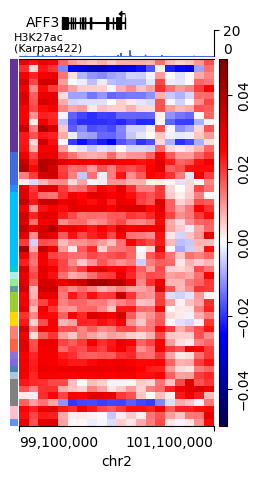

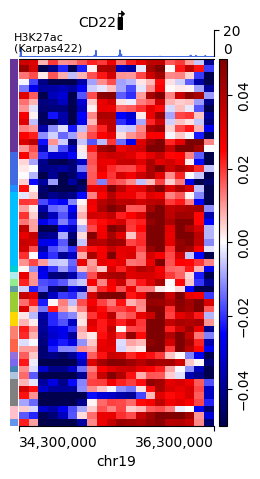

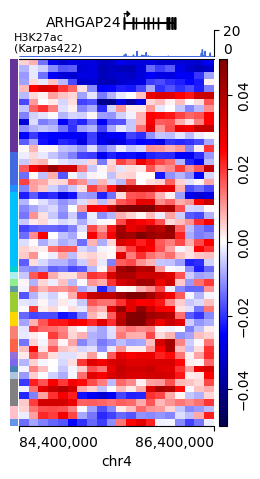

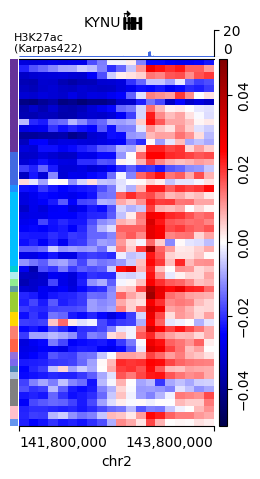

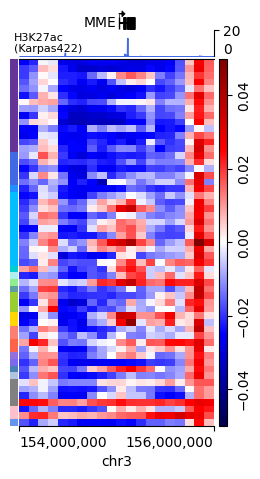

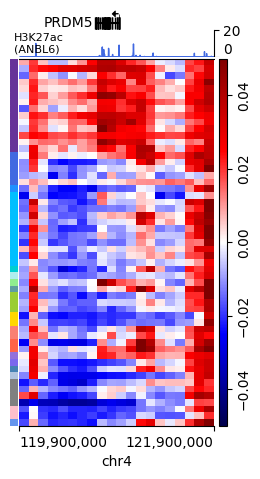

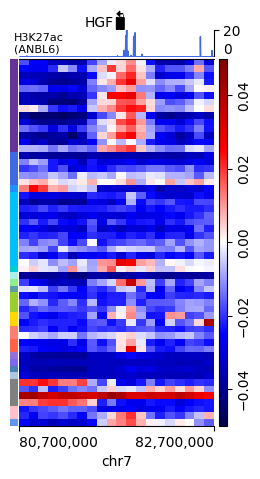

In [44]:
max_num = 10
num =0 
for _, result in results_df.iterrows():
    compartment = result.compartment_bin
    chrom, region = compartment.split(":")
    start, end = list(map(int, region.split("-")))
    gene_filter = result.gene_promoters.split(", ")
    if gene_filter[0] in ["MME", "CD22", "AFF3", "ARHGAP24", "KYNU", "HGF", "PRDM5"] :
        gene_filter = [gene_filter[0]]
        if result.dlbcl_pcn_compartment == "A_B":
            fig = plot_compartments(samples_compartments, chrom, start, gene_filter=gene_filter, bw_pair=BW_KARPAS_DLBCL)
        elif result.dlbcl_pcn_compartment == "B_A":
            fig = plot_compartments(samples_compartments, chrom, start, gene_filter=gene_filter, bw_pair=BW_MYELOMA_ANBL6)
        fig.savefig(figure_path(f"cohort_compartments_{gene_filter[0]}.svg"), bbox_inches="tight")
        

# Copy Number Profiles of Myelomas

## 500kb

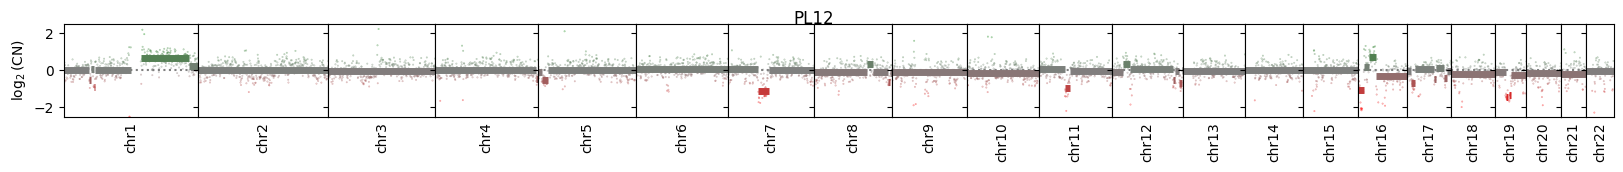

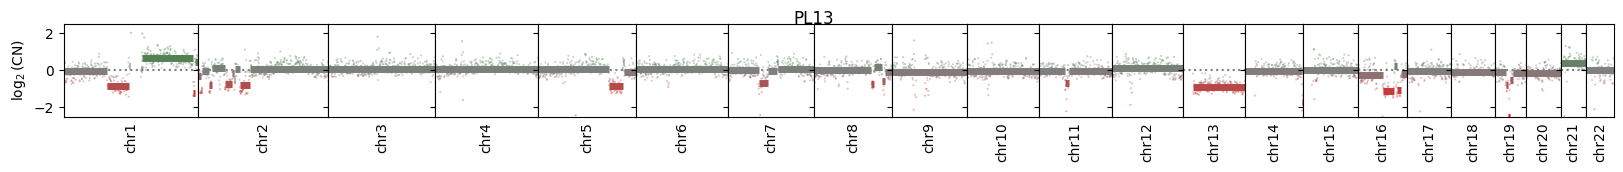

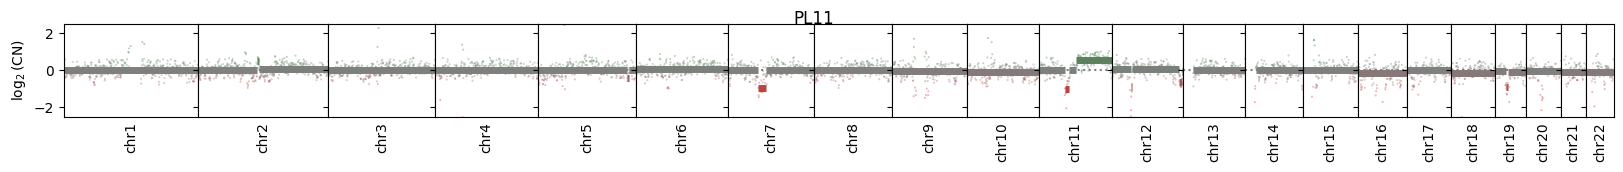

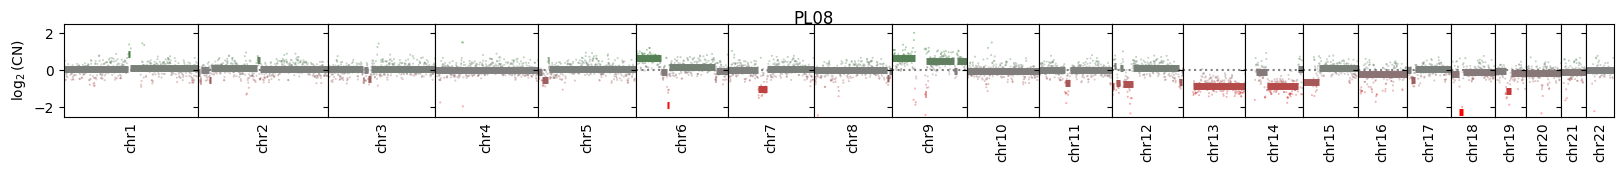

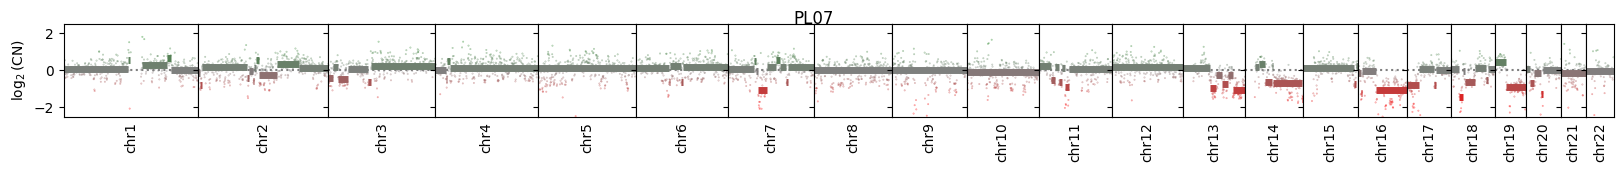

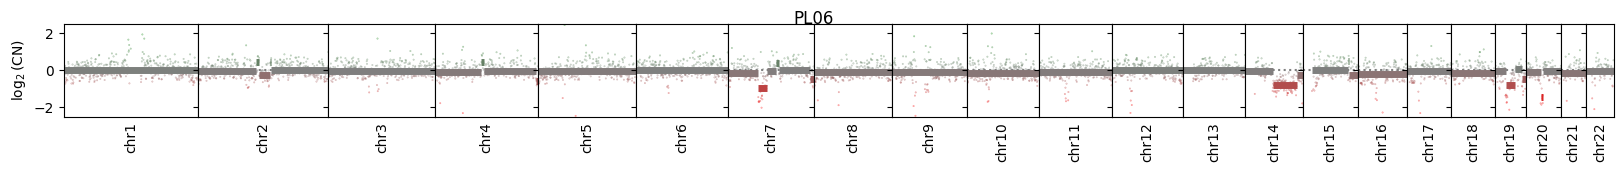

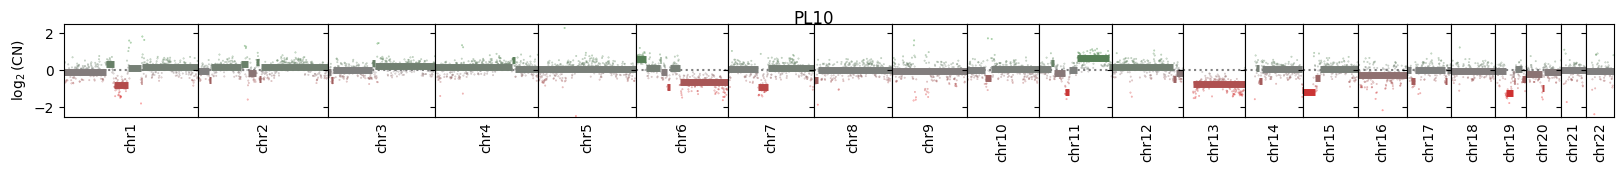

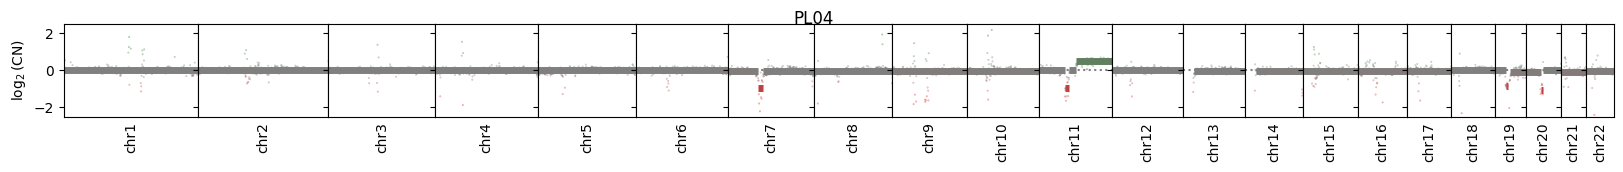

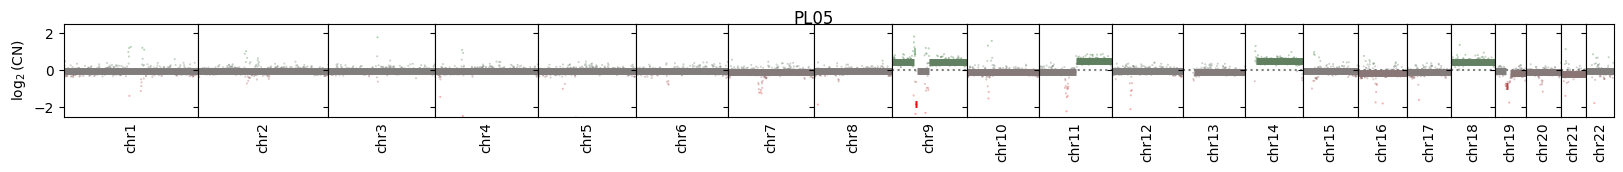

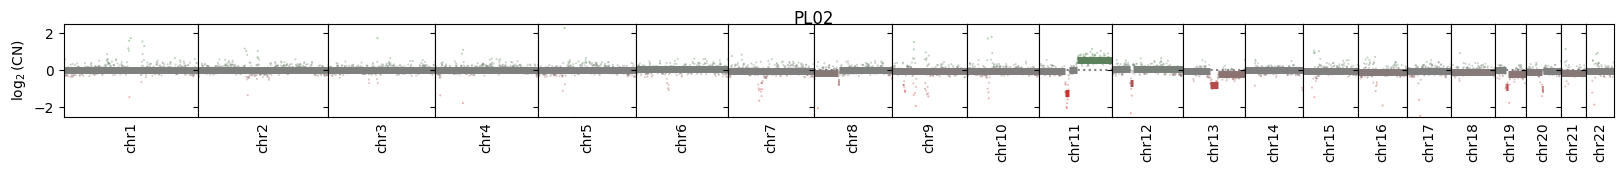

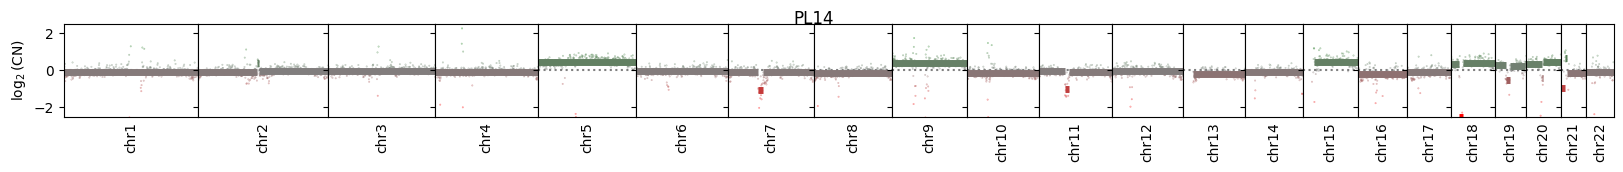

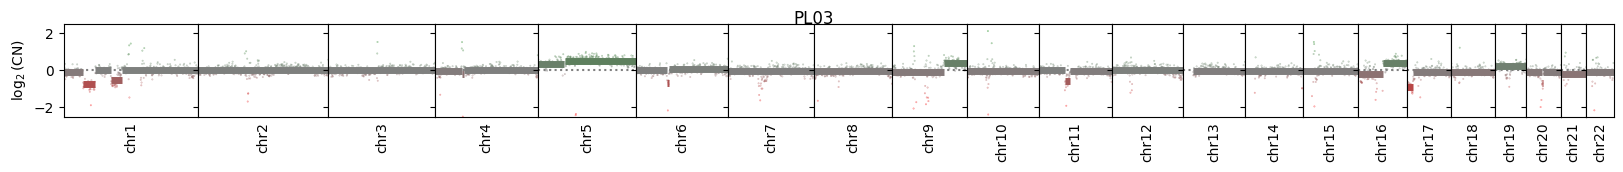

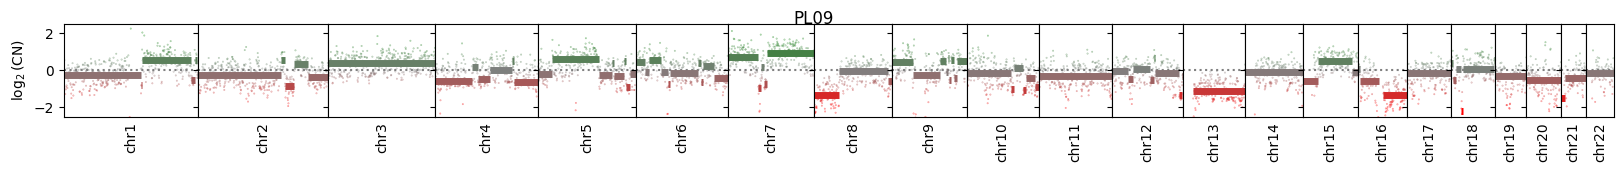

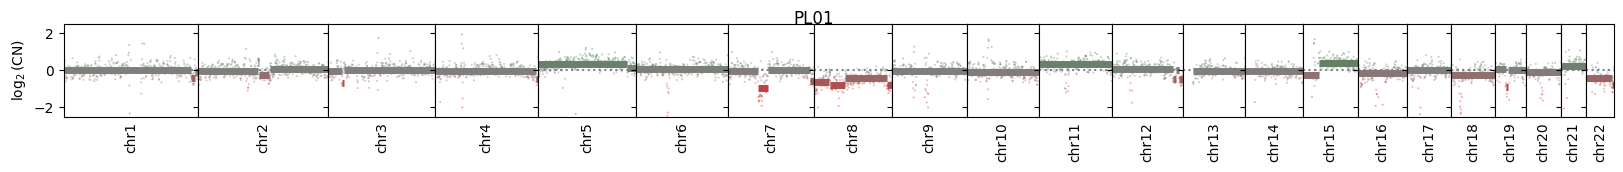

In [49]:
for sample in samples:
    if sample.meta.group == "PCN":
        chroms_autosomal = [(chrom, size) for chrom, size in CHROM_SIZES.items() if chrom != "chrX" and chrom != "chrY"]
        width_ratios = [size for (_, size) in chroms_autosomal]
        fig, axes = plt.subplots(ncols=22, sharey=True, width_ratios=width_ratios, figsize=(20, 1.2))
        for i, (chrom, _) in enumerate(chroms_autosomal):
            plot_cnv_track(sample.profile.cnv_profile_500kb, sample.profile.cnv_segment_500kb, chrom, cnv_res=500000, cnv_lim=(-2.5, 2.5), linewidth=5, show_zero_line=True, ax=axes[i], plot_scatter=True)
            # axes[i].axhline(0.5, ls="-")
            # axes[i].axhline(-0.5, ls="-")
            if i > 0:
                axes[i].set_ylabel("")
            axes[i].set_xlabel(chrom, rotation=90)
        plt.subplots_adjust(wspace=0, hspace=0)
        fig.suptitle(sample.meta.id_paper, y=1)

# Loci in Normal Cell Lines

In [148]:
def plot_insulations_all_for_subset(sample_subset, gregion, gene_filter=None, bw_pair=[BW_KARPAS_DLBCL, BW_MYELOMA_ANBL6]):

    chrom = gregion.chrom
    assembly_start = gregion.start
    assembly_end = gregion.end
    
    insulation_subset_all = []
    for sample in sample_subset:
        insulation_table = pd.read_csv(f"../data/insulations/res_10000_window_100000/{sample.meta.id_file}_insulation_r10000_w100000.csv")
        insulation_subset = insulation_table[(insulation_table.chrom == chrom) & (insulation_table.start >= assembly_start) & (insulation_table.end <= assembly_end)]
        insulation_subset_all.append(insulation_subset.log2_insulation_score_100000.values)
        insulation_xaxis = insulation_subset["start"].values 
    
    n_samples = len(sample_subset)
    
    nrows = n_samples + 5
    height_ratios = [1] * n_samples + [0.5, 0.5, 0.5, 0.25, 0.5]
    
    fig, axes = plt.subplots(nrows, figsize=(3, nrows / 2,), height_ratios=height_ratios)
    fig.subplots_adjust(hspace=0.05)
    
    ymin = -1
    ymax = 1
    for i, (sample, insulations) in enumerate(zip(sample_subset, insulation_subset_all)):
        ax=axes[i]
        ax.plot(insulation_xaxis, insulations, color=GROUP_COLORS[sample.meta.group], alpha=1, clip_on=False)
        ax.set_fc("none")
        ax.set_ylabel(sample.meta.id_paper)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((assembly_start, assembly_end))
        ax.spines[["top", "right", "bottom"]].set_visible(False)
        ax.set_xticks([])
        ax.get_yticklabels()[0].set_fontsize(9)
        ax.get_yticklabels()[-1].set_fontsize(9)
        ax.get_yticklabels()[0].set_va("bottom")
        ax.get_yticklabels()[-1].set_va("top")
    ax_bw1 = axes[n_samples]
    ax_bw2 = axes[n_samples+1]
    ax_gene = axes[n_samples+2]
    ax_ctcf = axes[n_samples+3]
    ax_arrow = axes[n_samples+4]
    
    plot_gene_track(gregion, gene_filter=gene_filter, fontsize=11, min_rows=0, max_rows=1, ax=ax_gene, all_same_line=True)
    plot_bigwig_track(pyBigWig.open(bw_pair[0][1]), gregion, ymax=GLOBAL_BW_MAX, ax=ax_bw1, label=bw_pair[0][0])
    plot_bigwig_track(pyBigWig.open(bw_pair[1][1]), gregion, ymax=GLOBAL_BW_MAX, ax=ax_bw2, label=bw_pair[1][0])
    

    ax_bw1.set_yticks([0, GLOBAL_BW_MAX], [0, GLOBAL_BW_MAX], fontsize=9)
    ax_bw1.spines[["left"]].set_visible(True)
    ax_bw1.get_yticklabels()[0].set_va("bottom")
    ax_bw1.get_yticklabels()[-1].set_va("top")
    ax_bw2.set_yticks([0, GLOBAL_BW_MAX], [0, GLOBAL_BW_MAX], fontsize=9)
    ax_bw2.spines[["left"]].set_visible(True)
    ax_bw2.get_yticklabels()[0].set_va("bottom")
    ax_bw2.get_yticklabels()[-1].set_va("top")

    plot_ctcf_track(CTCF_BEDFILE, gregion, ax_ctcf)
    plot_arrow_track(gregion, ax=ax_arrow)
   
    # pvt1_gene = ax_gene.findobj(matplotlib.text.Text)[1]
    # pvt1_gene.set_x(128220000)
    # pvt1_gene.set_ha("left")

    return fig

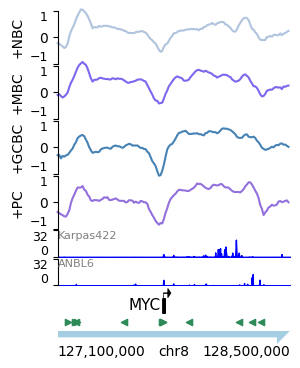

In [149]:
sort_order = {"NBC": 0, "MBC": 1, "GCBC": 2, "PC": 3}
subset = sorted(samples_pub_merge, key=lambda x: sort_order[x.meta.id_file.strip("+").strip("_merge")])

chrom = "chr8"
assembly_start = 127100000
assembly_end = 128500000

gregion=GenomicRegion(chrom, assembly_start, assembly_end)

fig = plot_insulations_all_for_subset(subset, gregion, gene_filter=["MYC"])
fig.savefig(f"../figures/insulations_MYC.svg", bbox_inches="tight")

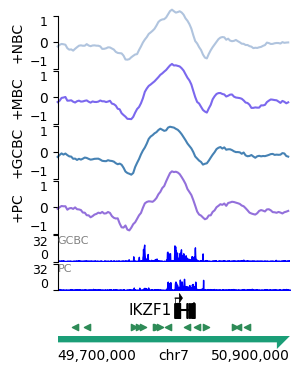

In [150]:
sort_order = {"NBC": 0, "MBC": 1, "GCBC": 2, "PC": 3}
subset = sorted(samples_pub_merge, key=lambda x: sort_order[x.meta.id_file.strip("+").strip("_merge")])

chrom = "chr7"
assembly_start = 49700000
assembly_end = 50900000

gregion=GenomicRegion(chrom, assembly_start, assembly_end)

fig = plot_insulations_all_for_subset(subset, gregion, gene_filter=["IKZF1"], bw_pair=[BW_GERMINAL, BW_PLASMA])
fig.savefig(f"../figures/insulations_IKZF1.svg", bbox_inches="tight")

## CTCF Site Comparisons

### MYC

In [133]:
chrom = "chr8"
ctcfA = 128191258
ctcfB = 128322839

gcb_A= []
gcb_B= []
pc_A = []
pc_B = []

for sample in samples_pub_rep:
    insulation_df = pd.read_csv(sample.profile.insulations)
    if sample.meta.group == "GCBC":
        listA = gcb_A
        listB = gcb_B
    elif sample.meta.group == "PC":
        listA = pc_A
        listB = pc_B
    else:
        continue
    for i, row in insulation_df[insulation_df.chrom == chrom].iterrows():
        if row.start <= ctcfA <= row.end:
            listA.append(row["log2_insulation_score_100000"])
        elif row.start <= ctcfB <= row.end:
            listB.append(row["log2_insulation_score_100000"])

In [135]:
pvalA = scipy.stats.mannwhitneyu(gcb_A, pc_A)
print(pvalA)

MannwhitneyuResult(statistic=4.0, pvalue=1.0)


In [136]:
pvalB = scipy.stats.mannwhitneyu(gcb_B, pc_B)
print(pvalB)

MannwhitneyuResult(statistic=9.0, pvalue=0.1)


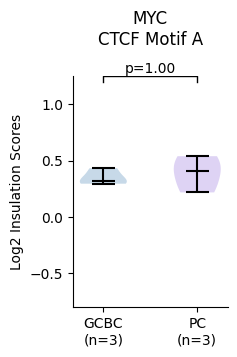

In [137]:
fig, ax = plt.subplots(figsize=(2, 3))
parts = ax.violinplot([gcb_A, pc_A], vert=True, positions=[0, 1], showmedians=True)

parts['bodies'][0].set_facecolor(GROUP_COLORS["GCBC"])
parts['bodies'][1].set_facecolor(GROUP_COLORS["PC"])
parts['cmedians'].set_edgecolor("black")
parts['cbars'].set_edgecolor("black")
parts['cmins'].set_edgecolor("black")
parts['cmaxes'].set_edgecolor("black")


ax.plot([0,0, 1, 1], [1.2, 1.25, 1.25, 1.2], linewidth=1, color='k')
ax.set_ylabel("Log2 Insulation Scores")
ax.spines[["top", "right"]].set_visible(False)
ax.text(0.5, 1.25, f"p={pvalA.pvalue:.2f}", ha="center", va="bottom")
ax.set_xticks([0, 1], [f"GCBC\n(n={len(gcb_A)})", f"PC\n(n={len(pc_A)})"])
ax.set_title(f"MYC\nCTCF Motif A", y=1.1)
ax.set_ylim(-0.8, 1.25)
fig.savefig(figure_path("MYC_insulation_GCBC_PC_boxplot_A.svg"), bbox_inches="tight")

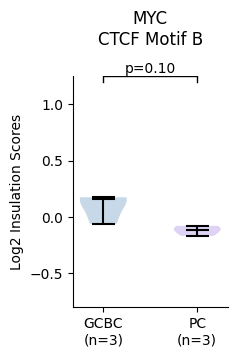

In [139]:
fig, ax = plt.subplots(figsize=(2, 3))

parts = ax.violinplot([gcb_B, pc_B], vert=True, positions=[0, 1], showmedians=True)

parts['bodies'][0].set_facecolor(GROUP_COLORS["GCBC"])
parts['bodies'][1].set_facecolor(GROUP_COLORS["PC"])
parts['cmedians'].set_edgecolor("black")
parts['cbars'].set_edgecolor("black")
parts['cmins'].set_edgecolor("black")
parts['cmaxes'].set_edgecolor("black")

ax.plot([0,0, 1, 1], [1.2, 1.25, 1.25, 1.2], linewidth=1, color='k')
ax.set_ylabel("Log2 Insulation Scores")
ax.spines[["top", "right"]].set_visible(False)
ax.text(0.5, 1.25, f"p={pvalB.pvalue:.2f}", ha="center", va="bottom")
ax.set_title(f"MYC\nCTCF Motif B", y=1.1)
ax.set_xticks([0, 1], [f"GCBC\n(n={len(gcb_B)})", f"PC\n(n={len(pc_B)})"])
ax.set_ylim(-0.8, 1.25)
fig.savefig(figure_path("MYC_insulation_GCBC_PC_boxplot_B.svg"), bbox_inches="tight")

### IKZF1

In [152]:
chrom = "chr7"
ctcfA = 50092658
ctcfB = 50205513

gcb_A= []
gcb_B= []
pc_A = []
pc_B = []

for sample in samples_pub_rep:
    insulation_df = pd.read_csv(sample.profile.insulations)
    if sample.meta.group == "GCBC":
        listA = gcb_A
        listB = gcb_B
    elif sample.meta.group == "PC":
        listA = pc_A
        listB = pc_B
    else:
        continue
    for i, row in insulation_df[insulation_df.chrom == chrom].iterrows():
        if row.start <= ctcfA <= row.end:
            listA.append(row["log2_insulation_score_100000"])
        elif row.start <= ctcfB <= row.end:
            listB.append(row["log2_insulation_score_100000"])

In [154]:
pvalA = scipy.stats.mannwhitneyu(gcb_A, pc_A)
print(pvalA)

MannwhitneyuResult(statistic=1.0, pvalue=0.2)


In [155]:
pvalB = scipy.stats.mannwhitneyu(gcb_B, pc_B)
print(pvalB)

MannwhitneyuResult(statistic=9.0, pvalue=0.1)


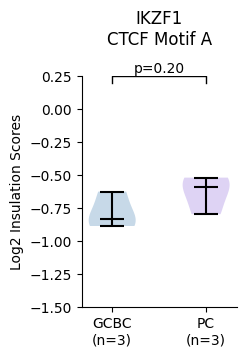

In [156]:
fig, ax = plt.subplots(figsize=(2, 3))
parts = ax.violinplot([gcb_A, pc_A], vert=True, positions=[0, 1], showmedians=True)

parts['bodies'][0].set_facecolor(GROUP_COLORS["GCBC"])
parts['bodies'][1].set_facecolor(GROUP_COLORS["PC"])
parts['cmedians'].set_edgecolor("black")
parts['cbars'].set_edgecolor("black")
parts['cmins'].set_edgecolor("black")
parts['cmaxes'].set_edgecolor("black")


ypos = 0.2
ax.plot([0,0, 1, 1], [ypos, ypos+0.05, ypos+0.05, ypos], linewidth=1, color='k')
ax.set_ylabel("Log2 Insulation Scores")
ax.spines[["top", "right"]].set_visible(False)
ax.text(0.5, ypos+0.05, f"p={pvalA.pvalue:.2f}", ha="center", va="bottom")
ax.set_xticks([0, 1], [f"GCBC\n(n={len(gcb_A)})", f"PC\n(n={len(pc_A)})"])
ax.set_title(f"IKZF1\nCTCF Motif A", y=1.1)
ax.set_ylim(-1.5, .25)
fig.savefig(figure_path("IKZF1_insulation_GCBC_PC_boxplot_A.svg"), bbox_inches="tight")

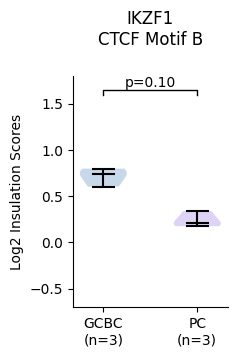

In [159]:
fig, ax = plt.subplots(figsize=(2, 3))
parts = ax.violinplot([gcb_B, pc_B], vert=True, positions=[0, 1], showmedians=True)

parts['bodies'][0].set_facecolor(GROUP_COLORS["GCBC"])
parts['bodies'][1].set_facecolor(GROUP_COLORS["PC"])
parts['cmedians'].set_edgecolor("black")
parts['cbars'].set_edgecolor("black")
parts['cmins'].set_edgecolor("black")
parts['cmaxes'].set_edgecolor("black")


ypos = 1.6
ax.plot([0,0, 1, 1], [ypos, ypos+0.05, ypos+0.05, ypos], linewidth=1, color='k')
ax.set_ylabel("Log2 Insulation Scores")
ax.spines[["top", "right"]].set_visible(False)
ax.text(0.5, ypos+0.05, f"p={pvalB.pvalue:.2f}", ha="center", va="bottom")
ax.set_xticks([0, 1], [f"GCBC\n(n={len(gcb_B)})", f"PC\n(n={len(pc_B)})"])
ax.set_title(f"IKZF1\nCTCF Motif B", y=1.1)
ax.set_ylim(-0.7, 1.8)
fig.savefig(figure_path("IKZF1_insulation_GCBC_PC_boxplot_B.svg"), bbox_inches="tight")

## Hi-C Triangles

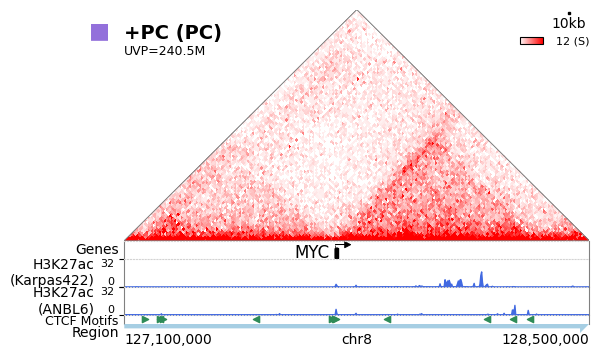

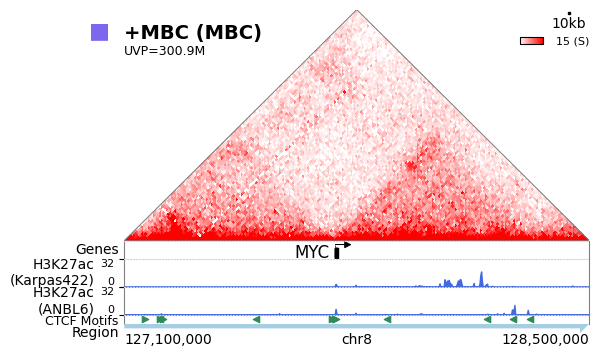

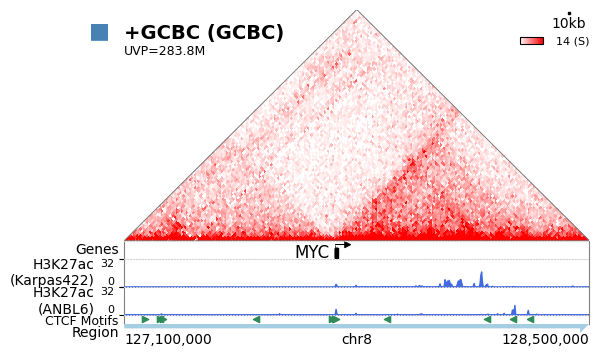

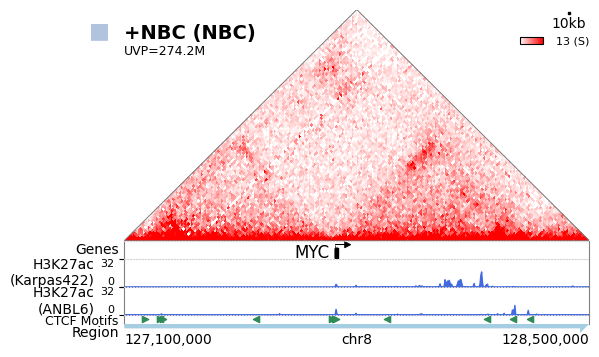

In [34]:
chrom = "chr8"
assembly_start = 127100000
assembly_end = 128500000
resolution = 10000

gregion = GenomicRegion(chrom, assembly_start, assembly_end).get_bin_aligned(resolution)
assembly = [gregion]

for arima_sample in arima_samples_merge:
    sample = SAMPLE_DICT[arima_sample.id]
    gene_filter = ["MYC"]

    fig = plot_standard_triangle_plot(
        arima_sample, assembly, resolution,
        gene_filter=gene_filter, gap_size=3,
        show_uvp=True,
        show_bw1_track=True,
        bw1_pair=BW_KARPAS_DLBCL,
        show_bw2_track=True,
        bw2_pair=BW_MYELOMA_ANBL6,
        vmax=sample.uvp//20e6
    )

    fig.savefig(f"../figures/{sample.meta.id_file}_{gene_filter[0]}_triangle.svg", bbox_inches="tight")

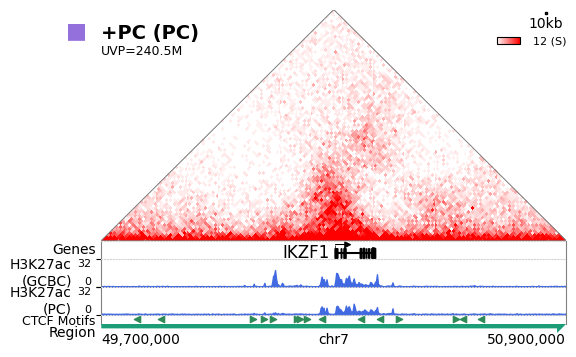

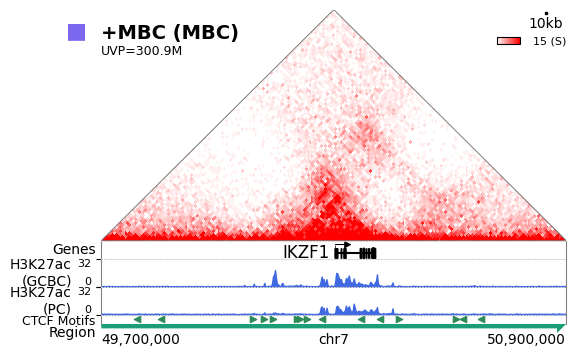

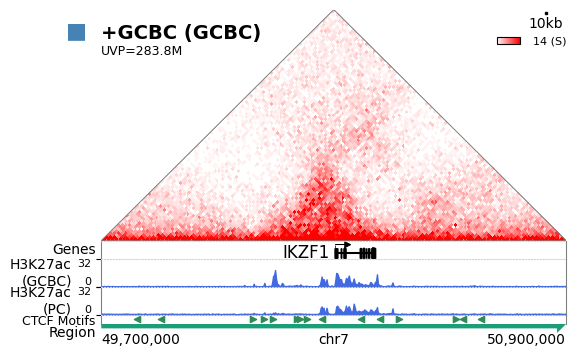

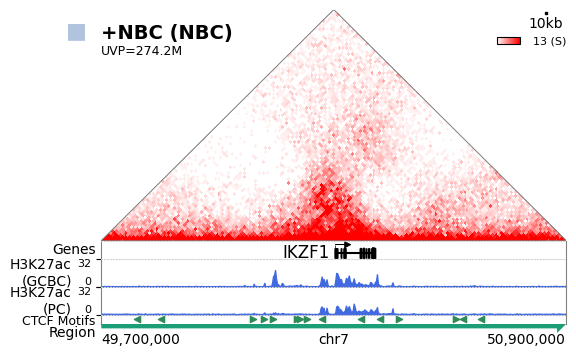

In [35]:
chrom = "chr7"
assembly_start = 49700000
assembly_end = 50900000
resolution = 10000

gregion = GenomicRegion(chrom, assembly_start, assembly_end).get_bin_aligned(resolution)
assembly = [gregion]

for arima_sample in arima_samples_merge:
    sample = SAMPLE_DICT[arima_sample.id]
    gene_filter = ["IKZF1"]

    fig = plot_standard_triangle_plot(
        arima_sample, assembly, resolution,
        gene_filter=gene_filter, gap_size=3,
        show_uvp=True,
        show_bw1_track=True,
        bw1_pair=BW_GERMINAL,
        show_bw2_track=True,
        bw2_pair=BW_PLASMA,
        vmax=sample.uvp//20e6
    )
    
    fig.savefig(f"../figures/{sample.meta.id_file}_{gene_filter[0]}_triangle.svg", bbox_inches="tight")

# Matrix Plots for Regions of Interest

### DC05 PD-L1 IGH

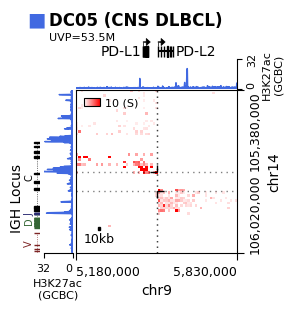

In [147]:
sample_id = "DC05"
gene_filter = ["CD274", "PDCD1LG2"]
chromA = "chr9"
chromB = "chr14"
bpoint_index = 1
resolution = 10000
radius = 320000


goi_1 = GENE_ANNOTATIONS.genes_by_name(gene_filter[0])[0]
goi_2 = GENE_ANNOTATIONS.genes_by_name(gene_filter[1])[0]

neoloop_region_filter = GenomicRegion("chr9", goi_1.start-resolution, goi_2.start+resolution)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == chromA and bpoint.breakendB.chrom == chromB][bpoint_index]
regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter,
    show_neoloops=True, show_uvp=True, vmax=10,
    neoloop_region_filter=neoloop_region_filter,
)

ax_gene = fig.axes[2]

# PD-L1 text
gene_text = ax_gene.findobj(matplotlib.text.Text)[0]
gene_text.set_text("PD-L1")

# PD-L1 text + position
gene_text = ax_gene.findobj(matplotlib.text.Text)[1]
gene_text.set_x(gene_text.get_position()[0]+radius/4)
gene_text.set_text("PD-L2")
gene_text.set_ha("left")

fig.savefig(figure_path(f"{arima_sample.id}_{'_'.join(gene_filter)}_matrix.svg"), bbox_inches="tight")

### PM01 PD-L1 ZCCHC7

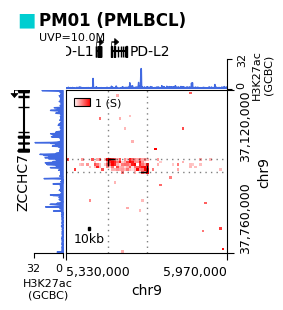

In [76]:
sample_id = "PM01"
gene_filter = ["CD274", "PDCD1LG2", "ZCCHC7", "PAX5"]
chromA = "chr9"
chromB = "chr9"
bpoint_index = 1
resolution = 10000
radius = 320000

goi_1 = GENE_ANNOTATIONS.genes_by_name(gene_filter[0])[0]
goi_2 = GENE_ANNOTATIONS.genes_by_name(gene_filter[1])[0]
neoloop_region_filter = GenomicRegion("chr9", goi_1.start-resolution, goi_2.start+resolution)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == chromA and bpoint.breakendB.chrom == chromB][bpoint_index]
regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter,
    show_neoloops=True, show_uvp=True, vmax=1,
    neoloop_region_filter=neoloop_region_filter,
)

ax_gene = fig.axes[2]

# PD-L1 text
gene_text = ax_gene.findobj(matplotlib.text.Text)[0]
gene_text.set_text("PD-L1")

# PD-L1 text + position
gene_text = ax_gene.findobj(matplotlib.text.Text)[1]
gene_text.set_x(gene_text.get_position()[0]+radius/4)
gene_text.set_text("PD-L2")
gene_text.set_ha("left")

fig.savefig(figure_path(f"{arima_sample.id}_{'_'.join(gene_filter)}_matrix.svg"), bbox_inches="tight")

### TA02 LMO2 TRA/D

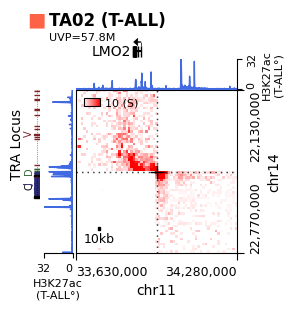

In [148]:
sample_id = "TA02"
gene_filter = ["LMO2"]
chromA = "chr11"
chromB = "chr14"
bpoint_index = 0
resolution = 10000
radius = 320000
goi_name = "LMO2"
neoloop_filter_radius = resolution*2

goi = GENE_ANNOTATIONS.genes_by_name(goi_name)[0]
neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.end-neoloop_filter_radius, goi.end+neoloop_filter_radius)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == chromA and bpoint.breakendB.chrom == chromB][bpoint_index]
regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter,
    show_neoloops=True, show_uvp=True, vmax=10,
    neoloop_region_filter=neoloop_region_filter,
)

fig.savefig(figure_path(f"{arima_sample.id}_{'_'.join(gene_filter)}_matrix.svg"), bbox_inches="tight")

### TA01

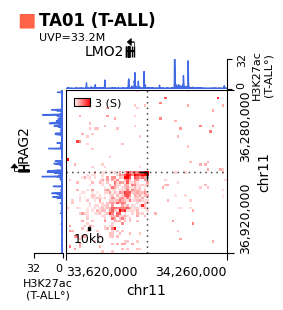

In [149]:
sample_id = "TA01"
gene_filter = ["LMO2", "RAG2"]
chromA = "chr11"
chromB = "chr11"
bpoint_index = 0
resolution = 10000
radius = 320000
goi_name = "LMO2"
neoloop_filter_radius = resolution

goi = GENE_ANNOTATIONS.genes_by_name(goi_name)[0]
neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.end-neoloop_filter_radius, goi.end+neoloop_filter_radius)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == chromA and bpoint.breakendB.chrom == chromB][bpoint_index]
regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter,
    show_neoloops=True, show_uvp=True,vmax=3,
    neoloop_region_filter=neoloop_region_filter,
)

fig.savefig(figure_path(f"{arima_sample.id}_{'_'.join(gene_filter)}_matrix.svg"), bbox_inches="tight")

### DL02 MYC BCL6

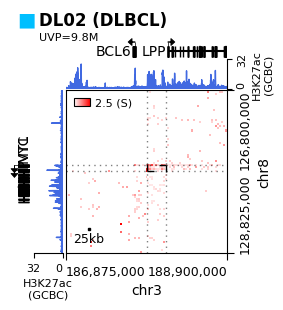

In [761]:
sample_id = "DL02"
gene_filter = ["MYC", "BCL6", "PVT1", "LPP"]
chromA = "chr3"
chromB = "chr8"
bpoint_index = 0
resolution = 25000
radius = 1000000
goi_name = "MYC"
neoloop_filter_radius = resolution

goi = GENE_ANNOTATIONS.genes_by_name(goi_name)[0]
if goi.strand == "+":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.start-neoloop_filter_radius, goi.start+neoloop_filter_radius)
elif goi.strand == "-":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.end-neoloop_filter_radius, goi.end+neoloop_filter_radius)
else:
    raise ValueError(goi.strand)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == chromA and bpoint.breakendB.chrom == chromB][bpoint_index]
regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter,
    show_neoloops=True, show_uvp=True,
    neoloop_region_filter=neoloop_region_filter,
)

# fig.savefig(figure_path(f"{arima_sample.id}_{'_'.join(gene_filter)}_matrix.svg"), bbox_inches="tight")

### DL01 MYC BCL6

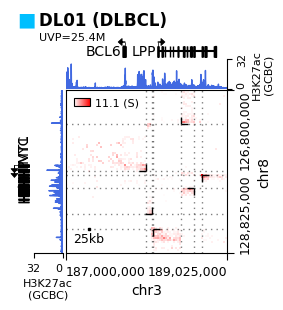

In [763]:
sample_id = "DL01"
gene_filter = ["MYC", "BCL6", "PVT1", "LPP"]
chromA = "chr3"
chromB = "chr8"
bpoint_index = 1
resolution = 25000
radius = 1000000
goi_name = "MYC"
neoloop_filter_radius = resolution

goi = GENE_ANNOTATIONS.genes_by_name(goi_name)[0]
if goi.strand == "+":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.start-neoloop_filter_radius, goi.start+neoloop_filter_radius)
elif goi.strand == "-":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.end-neoloop_filter_radius, goi.end+neoloop_filter_radius)
else:
    raise ValueError(goi.strand)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == chromA and bpoint.breakendB.chrom == chromB][bpoint_index]
regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter,
    show_neoloops=True, show_uvp=True,
    neoloop_region_filter=neoloop_region_filter,
)

# fig.savefig(figure_path(f"{arima_sample.id}_{'_'.join(gene_filter)}_matrix.svg"), bbox_inches="tight")

### DL05 MYC PAX5

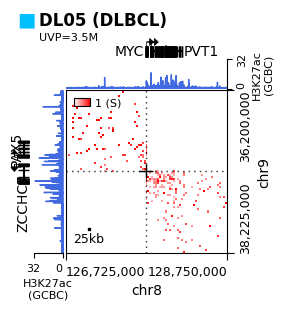

In [766]:
sample_id = "DL05"
gene_filter = ["MYC", "PAX5", "ZCCHC7", "PVT1"]
chromA = "chr8"
chromB = "chr9"
bpoint_index = 0
resolution = 25000
radius = 1000000
goi_name = "MYC"
neoloop_filter_radius = resolution

goi = GENE_ANNOTATIONS.genes_by_name(goi_name)[0]
if goi.strand == "+":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.start-neoloop_filter_radius, goi.start+neoloop_filter_radius)
elif goi.strand == "-":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.end-neoloop_filter_radius, goi.end+neoloop_filter_radius)
else:
    raise ValueError(goi.strand)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == chromA and bpoint.breakendB.chrom == chromB][bpoint_index]
regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter,
    show_neoloops=True, show_uvp=True, vmax=1,
    neoloop_region_filter=neoloop_region_filter,
)

ax = fig.get_axes()[2]
ax.findobj(plt.Text)[1].set_x(128210000)
ax.findobj(plt.Text)[1].set_ha("left")

ax = fig.get_axes()[1]
ax.findobj(plt.Text)[1].set_y(37600000)
ax.findobj(plt.Text)[1].set_va("top")
ax.findobj(plt.Text)[1].set_va("center")
ax.findobj(plt.Text)[0].set_y(36930000)
ax.findobj(plt.Text)[0].set_va("center")
ax.findobj(plt.Text)[0].set_ha("right")

fig.savefig(figure_path(f"{arima_sample.id}_{'_'.join(gene_filter)}_matrix.svg"), bbox_inches="tight")

### DL07 MYC IRAG2

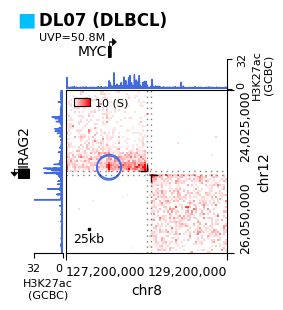

In [52]:
sample_id = "DL07"
gene_filter = ["MYC", "IRAG2"]
chromA = "chr8"
chromB = "chr12"
bpoint_index = 0
resolution = 25000
radius = 1000000
goi_name = "MYC"
neoloop_filter_radius = resolution

goi = GENE_ANNOTATIONS.genes_by_name(goi_name)[0]
if goi.strand == "+":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.start-neoloop_filter_radius, goi.start+neoloop_filter_radius)
elif goi.strand == "-":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.end-neoloop_filter_radius, goi.end+neoloop_filter_radius)
else:
    raise ValueError(goi.strand)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == chromA and bpoint.breakendB.chrom == chromB][bpoint_index]
regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter,
    show_neoloops=True, show_uvp=True, vmax=10,
    neoloop_region_filter=neoloop_region_filter,
)

fig.savefig(figure_path(f"{arima_sample.id}_{'_'.join(gene_filter)}_matrix.svg"), bbox_inches="tight")

### DL08 KYNU MYC

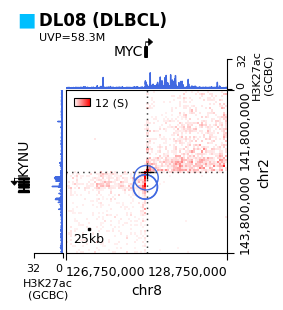

In [53]:
sample_id = "DL08"
gene_filter = ["MYC", "KYNU"]
chromA = "chr2"
chromB = "chr8"
bpoint_index = 0
resolution = 25000
radius = 1000000
goi_name = "MYC"
neoloop_filter_radius = resolution

goi = GENE_ANNOTATIONS.genes_by_name(goi_name)[0]
if goi.strand == "+":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.start-neoloop_filter_radius, goi.start+neoloop_filter_radius)
elif goi.strand == "-":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.end-neoloop_filter_radius, goi.end+neoloop_filter_radius)
else:
    raise ValueError(goi.strand)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == chromA and bpoint.breakendB.chrom == chromB][bpoint_index]
regionY, regionX = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter,
    show_neoloops=True, show_uvp=True, vmax=12,
    neoloop_region_filter=neoloop_region_filter,
)

fig.savefig(figure_path(f"{arima_sample.id}_{'_'.join(gene_filter)}_matrix.svg"), bbox_inches="tight")

### BA01 MYC TRA

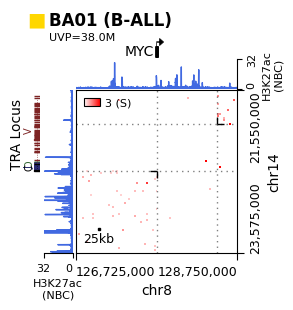

In [58]:
sample_id = "BA01"
gene_filter = ["MYC",]
chromA = "chr8"
chromB = "chr14"
bpoint_index = 0
resolution = 25000
radius = 1000000
goi_name = "MYC"
neoloop_filter_radius = resolution

goi = GENE_ANNOTATIONS.genes_by_name(goi_name)[0]
if goi.strand == "+":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.start-neoloop_filter_radius, goi.start+neoloop_filter_radius)
elif goi.strand == "-":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.end-neoloop_filter_radius, goi.end+neoloop_filter_radius)
else:
    raise ValueError(goi.strand)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == chromA and bpoint.breakendB.chrom == chromB][bpoint_index]
regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter,
    show_neoloops=True, show_uvp=True, vmax=3,
    neoloop_region_filter=neoloop_region_filter,
)

fig.savefig(figure_path(f"{arima_sample.id}_{'_'.join(gene_filter)}_matrix.svg"), bbox_inches="tight")

### MC02 MYCN ARHGAP24

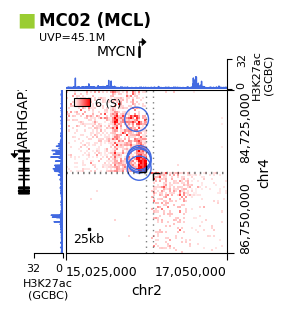

In [55]:
sample_id = "MC02"
gene_filter = ["MYCN", "ARHGAP24"]
chromA = "chr2"
chromB = "chr4"
bpoint_index = 0
resolution = 25000
radius = 1000000
goi_name = "MYCN"
neoloop_filter_radius = resolution

goi = GENE_ANNOTATIONS.genes_by_name(goi_name)[0]
if goi.strand == "+":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.start-neoloop_filter_radius, goi.start+neoloop_filter_radius)
elif goi.strand == "-":
    neoloop_region_filter = GenomicRegion(chr_prefix(goi.contig), goi.end-neoloop_filter_radius, goi.end+neoloop_filter_radius)
else:
    raise ValueError(goi.strand)

arima_sample =  [s for s in arima_samples if s.id == sample_id][0]
sample = SAMPLE_DICT[arima_sample.id]
bpoint = [bpoint for bpoint in arima_sample.breakpoints if bpoint.breakendA.chrom == chromA and bpoint.breakendB.chrom == chromB][bpoint_index]
regionX, regionY = bpoint.get_centered_regions_with_radius(radius)
regionX = regionX.get_bin_aligned(resolution)
regionY = regionY.get_bin_aligned(resolution)
bw_tuple = BW_DICT[sample.meta.group]

fig = plot_standard_matrix_plot(
    arima_sample, regionX, regionY, resolution, bw_tuple=bw_tuple, 
    gene_filter=gene_filter,
    show_neoloops=True, show_uvp=True, vmax=6,
    neoloop_region_filter=neoloop_region_filter,
)

fig.savefig(figure_path(f"{arima_sample.id}_{'_'.join(gene_filter)}_matrix.svg"), bbox_inches="tight")